# Install and Set up

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive/')

In [2]:
# import sys
# sys.path.append('/content/gdrive/MyDrive/PrimeVisionProj')

In [3]:
# %cd /content/gdrive/MyDrive/PrimeVisionProj
# !ls

In [4]:
# !pip install rl4co==0.3.3
# !pip install torch==2.3.0
# !pip install matplotlib

# Build Model and test untrained model

In [5]:
from SPPembeddings import SPPInitEmbedding, SPPContext, StaticEmbedding
from rl4co.models.zoo import AttentionModel, AutoregressivePolicy, POMO, POMOPolicy
from SPPenv import SPPEnv
from FPenv import FPEnv

# env = SPPEnv(num_loc=100)
env = FPEnv(fp_path="Floorplans/quad-infeed/butterfly/14x11/floorplan.json")

# from SPPv2env import SPPv2Env
# env = SPPv2Env(num_loc=100)

# Instantiate policy with the embeddings we created above
emb_dim = 64
# policy = AutoregressivePolicy(env,
#                               embedding_dim=emb_dim,
#                               init_embedding=SPPInitEmbedding(emb_dim),
#                               context_embedding=SPPContext(emb_dim),
#                               dynamic_embedding=StaticEmbedding(emb_dim),
#                               train_decode_type="multistart_greedy",
#                               val_decode_type="greedy",
#                               test_decode_type="greedy",
#                               num_starts=2
# )

policy = POMOPolicy(env,
                    embedding_dim=emb_dim,
                    init_embedding=SPPInitEmbedding(emb_dim),
                    context_embedding=SPPContext(emb_dim),
                    dynamic_embedding=StaticEmbedding(emb_dim),
                    train_decode_type="greedy",
                    val_decode_type="greedy",
                    test_decode_type="greedy"
                    )

# model = POMO(env, policy=policy,
#                   baseline='shared',
#                   batch_size=3,
#                   train_data_size=100,
#                   val_data_size=100,)

# Model: default is AM with REINFORCE and greedy rollout baseline
model = AttentionModel(env,
                       policy=policy,
                       baseline='rollout',
                       train_data_size=100_00,
                       val_data_size=100_0,
                       batch_size=4,
                       val_batch_size=4,
                       test_batch_size=4)

/home/pvadmin/yifei_rl_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


num_loc: 568


/home/pvadmin/yifei_rl_env/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
/home/pvadmin/yifei_rl_env/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.


batch_size in reset: [4]
batch_size: 4
self.locs.shape before unsqueeze: torch.Size([568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568


Problem 1 | Cost: 1000.000


/home/pvadmin/yifei_rl_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


Problem 2 | Cost: 1000.000


Problem 3 | Cost: 1000.000


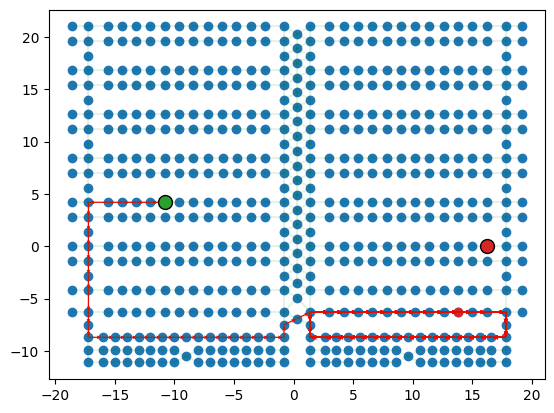

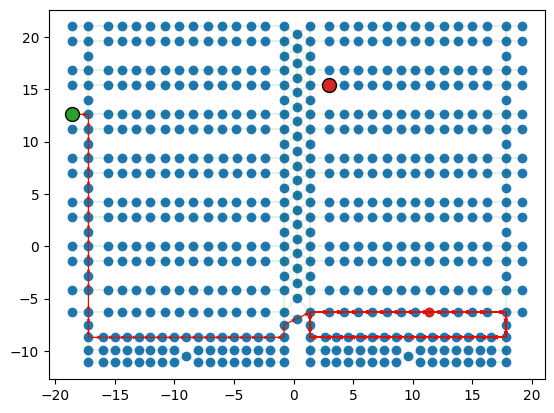

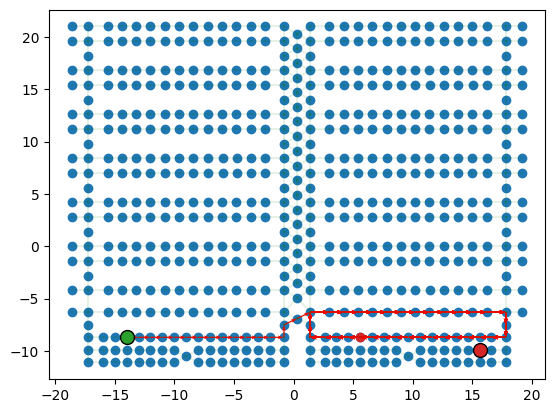

In [6]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
td_init = env.reset(batch_size=[4]).to(device)
model = model.to(device)
out = model(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)
actions_untrained = out["actions"].cpu().detach()
rewards_untrained = out["reward"].cpu().detach()

for i in range(3):
    print(f"Problem {i+1} | Cost: {-rewards_untrained[i]:.3f}")
    env.render(td_init[i], actions_untrained[i])

# Train model

In [7]:
from rl4co.utils.trainer import RL4COTrainer

trainer = RL4COTrainer(
    max_epochs=100,
    accelerator="gpu",
    devices=1,
    logger=None
)

trainer.fit(model)

# Save the model
torch.save(model, 'Models/TrainOnFloorplansResults5.pth')

Using 16bit Automatic Mixed Precision (AMP)


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


/home/pvadmin/yifei_rl_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
val_file not set. Generating dataset instead


test_file not set. Generating dataset instead


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



  | Name     | Type           | Params
--------------------------------------------
0 | env      | FPEnv          | 0     
1 | policy   | POMOPolicy     | 527 K 
2 | baseline | WarmupBaseline | 527 K 
--------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.217     Total estimated model params size (MB)


Sanity Checking: |                                                                                                                                                                                           | 0/? [00:00<?, ?it/s]

Sanity Checking:   0%|                                                                                                                                                                                       | 0/1 [00:00<?, ?it/s]

Sanity Checking DataLoader 0:   0%|                                                                                                                                                                          | 0/1 [00:00<?, ?it/s]

/home/pvadmin/yifei_rl_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


init_locs is not None, batch_size = init_locs.shape[:-2]


Sanity Checking DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.51it/s]

/home/pvadmin/yifei_rl_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.
/home/pvadmin/yifei_rl_env/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                                                                                                                                  | 0/? [00:00<?, ?it/s]

Training:   0%|                                                                                                                                                                                              | 0/1 [00:00<?, ?it/s]

Epoch 0:   0%|                                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.77it/s]

Epoch 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.77it/s, v_num=13, train/reward=-1e+3, train/loss=0.000]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]

Epoch 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.52it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-514.]

Epoch 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.52it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-514.]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 0:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-514.]

Epoch 1:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-514.]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-514.]

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-765., train/loss=1.68e+4, val/reward=-514.]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.68it/s]

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-765., train/loss=1.68e+4, val/reward=-753.]

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-765., train/loss=1.68e+4, val/reward=-753.]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 1:   0%|                                                                                                                           | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-765., train/loss=1.68e+4, val/reward=-753.]

Epoch 2:   0%|                                                                                                                           | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-765., train/loss=1.68e+4, val/reward=-753.]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.01it/s, v_num=13, train/reward=-765., train/loss=1.68e+4, val/reward=-753.]

Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.01it/s, v_num=13, train/reward=-755., train/loss=1.64e+4, val/reward=-753.]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]

Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-755., train/loss=1.64e+4, val/reward=-1e+3]

Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.62it/s, v_num=13, train/reward=-755., train/loss=1.64e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 2:   0%|                                                                                                                           | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-755., train/loss=1.64e+4, val/reward=-1e+3]

Epoch 3:   0%|                                                                                                                           | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-755., train/loss=1.64e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-755., train/loss=1.64e+4, val/reward=-1e+3]

Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-754., train/loss=421.0, val/reward=-1e+3]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.71it/s]

Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-754., train/loss=421.0, val/reward=-765.]

Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-754., train/loss=421.0, val/reward=-765.]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 3:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-754., train/loss=421.0, val/reward=-765.]

Epoch 4:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-754., train/loss=421.0, val/reward=-765.]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-754., train/loss=421.0, val/reward=-765.]

Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-765.]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]

Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 4:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Epoch 5:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Epoch 5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s, v_num=13, train/reward=-1e+3, train/loss=-2.02e+4, val/reward=-1e+3]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]

Epoch 5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=-2.02e+4, val/reward=-1e+3]

Epoch 5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=-2.02e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 5:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=-2.02e+4, val/reward=-1e+3]

Epoch 6:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=-2.02e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 6: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-1e+3, train/loss=-2.02e+4, val/reward=-1e+3]

Epoch 6: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-758., train/loss=-2.35e+4, val/reward=-1e+3]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]

Epoch 6: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-758., train/loss=-2.35e+4, val/reward=-759.]

Epoch 6: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-758., train/loss=-2.35e+4, val/reward=-759.]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 6:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-758., train/loss=-2.35e+4, val/reward=-759.]

Epoch 7:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-758., train/loss=-2.35e+4, val/reward=-759.]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 7: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.89it/s, v_num=13, train/reward=-758., train/loss=-2.35e+4, val/reward=-759.]

Epoch 7: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.89it/s, v_num=13, train/reward=-759., train/loss=-2.94e+4, val/reward=-759.]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]

Epoch 7: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.58it/s, v_num=13, train/reward=-759., train/loss=-2.94e+4, val/reward=-759.]

Epoch 7: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.58it/s, v_num=13, train/reward=-759., train/loss=-2.94e+4, val/reward=-759.]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 7:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-759., train/loss=-2.94e+4, val/reward=-759.]

Epoch 8:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-759., train/loss=-2.94e+4, val/reward=-759.]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 8: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-759., train/loss=-2.94e+4, val/reward=-759.]

Epoch 8: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-759.]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]

Epoch 8: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Epoch 8: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 8:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Epoch 9:   0%|                                                                                                                             | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Epoch 9: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-1e+3, train/loss=-4.24e+4, val/reward=-1e+3]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]

Epoch 9: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=-4.24e+4, val/reward=-754.]

Epoch 9: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=-4.24e+4, val/reward=-754.]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 9:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=-4.24e+4, val/reward=-754.]

Epoch 10:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=-4.24e+4, val/reward=-754.]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-1e+3, train/loss=-4.24e+4, val/reward=-754.]

Epoch 10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-513., train/loss=-1.05e+4, val/reward=-754.]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.67it/s]

Epoch 10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-513., train/loss=-1.05e+4, val/reward=-1e+3]

Epoch 10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-513., train/loss=-1.05e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 10:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-513., train/loss=-1.05e+4, val/reward=-1e+3]

Epoch 11:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-513., train/loss=-1.05e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 11: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s, v_num=13, train/reward=-513., train/loss=-1.05e+4, val/reward=-1e+3]

Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s, v_num=13, train/reward=-765., train/loss=1.62e+4, val/reward=-1e+3]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]

Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.62it/s, v_num=13, train/reward=-765., train/loss=1.62e+4, val/reward=-1e+3]

Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.62it/s, v_num=13, train/reward=-765., train/loss=1.62e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 11:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-765., train/loss=1.62e+4, val/reward=-1e+3]

Epoch 12:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-765., train/loss=1.62e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-765., train/loss=1.62e+4, val/reward=-1e+3]

Epoch 12: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-754., train/loss=-2.83e+3, val/reward=-1e+3]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]

Epoch 12: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-754., train/loss=-2.83e+3, val/reward=-1e+3]

Epoch 12: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-754., train/loss=-2.83e+3, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 12:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-754., train/loss=-2.83e+3, val/reward=-1e+3]

Epoch 13:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-754., train/loss=-2.83e+3, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 13: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-754., train/loss=-2.83e+3, val/reward=-1e+3]

Epoch 13: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-758., train/loss=-1.72e+4, val/reward=-1e+3]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]

Epoch 13: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-758., train/loss=-1.72e+4, val/reward=-762.]

Epoch 13: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-758., train/loss=-1.72e+4, val/reward=-762.]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 13:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-758., train/loss=-1.72e+4, val/reward=-762.]

Epoch 14:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-758., train/loss=-1.72e+4, val/reward=-762.]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 14: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-758., train/loss=-1.72e+4, val/reward=-762.]

Epoch 14: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-1e+3, train/loss=-6.25e+4, val/reward=-762.]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]

Epoch 14: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=-6.25e+4, val/reward=-1e+3]

Epoch 14: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=-6.25e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 14:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=-6.25e+4, val/reward=-1e+3]

Epoch 15:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=-6.25e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.90it/s, v_num=13, train/reward=-1e+3, train/loss=-6.25e+4, val/reward=-1e+3]

Epoch 15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.90it/s, v_num=13, train/reward=-1e+3, train/loss=-1.93e+4, val/reward=-1e+3]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]

Epoch 15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.58it/s, v_num=13, train/reward=-1e+3, train/loss=-1.93e+4, val/reward=-1e+3]

Epoch 15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.58it/s, v_num=13, train/reward=-1e+3, train/loss=-1.93e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 15:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=-1.93e+4, val/reward=-1e+3]

Epoch 16:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=-1.93e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 16: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s, v_num=13, train/reward=-1e+3, train/loss=-1.93e+4, val/reward=-1e+3]

Epoch 16: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s, v_num=13, train/reward=-522., train/loss=-1.08e+4, val/reward=-1e+3]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]

Epoch 16: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-522., train/loss=-1.08e+4, val/reward=-1e+3]

Epoch 16: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-522., train/loss=-1.08e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 16:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-522., train/loss=-1.08e+4, val/reward=-1e+3]

Epoch 17:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-522., train/loss=-1.08e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 17: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-522., train/loss=-1.08e+4, val/reward=-1e+3]

Epoch 17: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]

Epoch 17: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Epoch 17: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 17:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Epoch 18:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 18: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Epoch 18: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]

Epoch 18: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Epoch 18: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 18:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Epoch 19:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Epoch 19: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-1e+3, train/loss=-3.75e+4, val/reward=-1e+3]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]

Epoch 19: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=-3.75e+4, val/reward=-1e+3]

Epoch 19: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=-3.75e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 19:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=-3.75e+4, val/reward=-1e+3]

Epoch 20:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=-3.75e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-1e+3, train/loss=-3.75e+4, val/reward=-1e+3]

Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-761., train/loss=1.09e+4, val/reward=-1e+3]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]

Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-761., train/loss=1.09e+4, val/reward=-761.]

Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-761., train/loss=1.09e+4, val/reward=-761.]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 20:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-761., train/loss=1.09e+4, val/reward=-761.]

Epoch 21:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-761., train/loss=1.09e+4, val/reward=-761.]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-761., train/loss=1.09e+4, val/reward=-761.]

Epoch 21: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-761.]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]

Epoch 21: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Epoch 21: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 21:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Epoch 22:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 22: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-516., train/loss=2.96e+4, val/reward=-1e+3]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]

Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-516., train/loss=2.96e+4, val/reward=-761.]

Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-516., train/loss=2.96e+4, val/reward=-761.]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 22:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-516., train/loss=2.96e+4, val/reward=-761.]

Epoch 23:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-516., train/loss=2.96e+4, val/reward=-761.]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.90it/s, v_num=13, train/reward=-516., train/loss=2.96e+4, val/reward=-761.]

Epoch 23: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.90it/s, v_num=13, train/reward=-1e+3, train/loss=-3.71e+4, val/reward=-761.]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]

Epoch 23: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.58it/s, v_num=13, train/reward=-1e+3, train/loss=-3.71e+4, val/reward=-1e+3]

Epoch 23: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.58it/s, v_num=13, train/reward=-1e+3, train/loss=-3.71e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 23:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=-3.71e+4, val/reward=-1e+3]

Epoch 24:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=-3.71e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 24: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s, v_num=13, train/reward=-1e+3, train/loss=-3.71e+4, val/reward=-1e+3]

Epoch 24: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.67it/s]

Epoch 24: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.62it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Epoch 24: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.62it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 24:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Epoch 25:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.01it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Epoch 25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.01it/s, v_num=13, train/reward=-1e+3, train/loss=-1.54e+4, val/reward=-1e+3]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]

Epoch 25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.62it/s, v_num=13, train/reward=-1e+3, train/loss=-1.54e+4, val/reward=-1e+3]

Epoch 25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.62it/s, v_num=13, train/reward=-1e+3, train/loss=-1.54e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 25:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=-1.54e+4, val/reward=-1e+3]

Epoch 26:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=-1.54e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 26: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-1e+3, train/loss=-1.54e+4, val/reward=-1e+3]

Epoch 26: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]

Epoch 26: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-526.]

Epoch 26: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-526.]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 26:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-526.]

Epoch 27:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-526.]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 27: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-526.]

Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-756., train/loss=-7.6e+4, val/reward=-526.]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]

Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-756., train/loss=-7.6e+4, val/reward=-753.]

Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-756., train/loss=-7.6e+4, val/reward=-753.]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 27:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-756., train/loss=-7.6e+4, val/reward=-753.]

Epoch 28:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-756., train/loss=-7.6e+4, val/reward=-753.]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-756., train/loss=-7.6e+4, val/reward=-753.]

Epoch 28: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-512., train/loss=-1.99e+4, val/reward=-753.]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]

Epoch 28: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-512., train/loss=-1.99e+4, val/reward=-760.]

Epoch 28: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-512., train/loss=-1.99e+4, val/reward=-760.]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 28:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-512., train/loss=-1.99e+4, val/reward=-760.]

Epoch 29:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-512., train/loss=-1.99e+4, val/reward=-760.]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 29: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.90it/s, v_num=13, train/reward=-512., train/loss=-1.99e+4, val/reward=-760.]

Epoch 29: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.90it/s, v_num=13, train/reward=-1e+3, train/loss=-4.53e+4, val/reward=-760.]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]

Epoch 29: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.58it/s, v_num=13, train/reward=-1e+3, train/loss=-4.53e+4, val/reward=-758.]

Epoch 29: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.58it/s, v_num=13, train/reward=-1e+3, train/loss=-4.53e+4, val/reward=-758.]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 29:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=-4.53e+4, val/reward=-758.]

Epoch 30:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=-4.53e+4, val/reward=-758.]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-1e+3, train/loss=-4.53e+4, val/reward=-758.]

Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-755., train/loss=3.98e+3, val/reward=-758.]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]

Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-755., train/loss=3.98e+3, val/reward=-754.]

Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-755., train/loss=3.98e+3, val/reward=-754.]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 30:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-755., train/loss=3.98e+3, val/reward=-754.]

Epoch 31:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-755., train/loss=3.98e+3, val/reward=-754.]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-755., train/loss=3.98e+3, val/reward=-754.]

Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-513., train/loss=7.04e+3, val/reward=-754.]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]

Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-513., train/loss=7.04e+3, val/reward=-1e+3]

Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-513., train/loss=7.04e+3, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 31:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-513., train/loss=7.04e+3, val/reward=-1e+3]

Epoch 32:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-513., train/loss=7.04e+3, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-513., train/loss=7.04e+3, val/reward=-1e+3]

Epoch 32: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]

Epoch 32: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Epoch 32: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 32:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Epoch 33:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 33: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Epoch 33: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]

Epoch 33: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-769.]

Epoch 33: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-769.]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 33:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-769.]

Epoch 34:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-769.]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 34: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-769.]

Epoch 34: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-1e+3, train/loss=-5.03e+4, val/reward=-769.]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]

Epoch 34: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=-5.03e+4, val/reward=-1e+3]

Epoch 34: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=-5.03e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 34:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=-5.03e+4, val/reward=-1e+3]

Epoch 35:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=-5.03e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 35: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-1e+3, train/loss=-5.03e+4, val/reward=-1e+3]

Epoch 35: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]

Epoch 35: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Epoch 35: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 35:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Epoch 36:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 36: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.91it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Epoch 36: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.91it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.68it/s]

Epoch 36: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.58it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Epoch 36: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.58it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 36:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Epoch 37:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 37: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Epoch 37: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.01it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]

Epoch 37: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.62it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-760.]

Epoch 37: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.62it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-760.]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 37:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-760.]

Epoch 38:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-760.]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 38: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-760.]

Epoch 38: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-1e+3, train/loss=-4.84e+4, val/reward=-760.]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]

Epoch 38: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=-4.84e+4, val/reward=-753.]

Epoch 38: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=-4.84e+4, val/reward=-753.]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 38:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=-4.84e+4, val/reward=-753.]

Epoch 39:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=-4.84e+4, val/reward=-753.]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 39: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-1e+3, train/loss=-4.84e+4, val/reward=-753.]

Epoch 39: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-753.]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]

Epoch 39: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Epoch 39: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 39:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Epoch 40:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Epoch 40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]

Epoch 40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Epoch 40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 40:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Epoch 41:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 41: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Epoch 41: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]

Epoch 41: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Epoch 41: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 41:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Epoch 42:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 42: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Epoch 42: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s, v_num=13, train/reward=-1e+3, train/loss=-2.35e+4, val/reward=-1e+3]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]

Epoch 42: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=-2.35e+4, val/reward=-1e+3]

Epoch 42: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=-2.35e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 42:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=-2.35e+4, val/reward=-1e+3]

Epoch 43:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=-2.35e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 43: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s, v_num=13, train/reward=-1e+3, train/loss=-2.35e+4, val/reward=-1e+3]

Epoch 43: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s, v_num=13, train/reward=-1e+3, train/loss=-6.67e+4, val/reward=-1e+3]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]

Epoch 43: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=-6.67e+4, val/reward=-1e+3]

Epoch 43: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=-6.67e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 43:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=-6.67e+4, val/reward=-1e+3]

Epoch 44:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=-6.67e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 44: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.90it/s, v_num=13, train/reward=-1e+3, train/loss=-6.67e+4, val/reward=-1e+3]

Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.90it/s, v_num=13, train/reward=-758., train/loss=1.53e+4, val/reward=-1e+3]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]

Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.58it/s, v_num=13, train/reward=-758., train/loss=1.53e+4, val/reward=-755.]

Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.58it/s, v_num=13, train/reward=-758., train/loss=1.53e+4, val/reward=-755.]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 44:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-758., train/loss=1.53e+4, val/reward=-755.]

Epoch 45:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-758., train/loss=1.53e+4, val/reward=-755.]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-758., train/loss=1.53e+4, val/reward=-755.]

Epoch 45: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-756., train/loss=904.0, val/reward=-755.]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]

Epoch 45: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-756., train/loss=904.0, val/reward=-753.]

Epoch 45: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-756., train/loss=904.0, val/reward=-753.]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 45:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-756., train/loss=904.0, val/reward=-753.]

Epoch 46:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-756., train/loss=904.0, val/reward=-753.]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 46: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-756., train/loss=904.0, val/reward=-753.]

Epoch 46: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-754., train/loss=973.0, val/reward=-753.]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]

Epoch 46: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-754., train/loss=973.0, val/reward=-1e+3]

Epoch 46: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-754., train/loss=973.0, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 46:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-754., train/loss=973.0, val/reward=-1e+3]

Epoch 47:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-754., train/loss=973.0, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 47: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s, v_num=13, train/reward=-754., train/loss=973.0, val/reward=-1e+3]

Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-518., train/loss=5.19e+4, val/reward=-1e+3]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.71it/s]

Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-518., train/loss=5.19e+4, val/reward=-763.]

Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-518., train/loss=5.19e+4, val/reward=-763.]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 47:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-518., train/loss=5.19e+4, val/reward=-763.]

Epoch 48:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-518., train/loss=5.19e+4, val/reward=-763.]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s, v_num=13, train/reward=-518., train/loss=5.19e+4, val/reward=-763.]

Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-754., train/loss=2.27e+4, val/reward=-763.]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]

Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-754., train/loss=2.27e+4, val/reward=-1e+3]

Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-754., train/loss=2.27e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 48:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-754., train/loss=2.27e+4, val/reward=-1e+3]

Epoch 49:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-754., train/loss=2.27e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-754., train/loss=2.27e+4, val/reward=-1e+3]

Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-764., train/loss=-1.8e+4, val/reward=-1e+3]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]

Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-764., train/loss=-1.8e+4, val/reward=-1e+3]

Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-764., train/loss=-1.8e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 49:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-764., train/loss=-1.8e+4, val/reward=-1e+3]

Epoch 50:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-764., train/loss=-1.8e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-764., train/loss=-1.8e+4, val/reward=-1e+3]

Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s, v_num=13, train/reward=-758., train/loss=3.76e+4, val/reward=-1e+3]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]

Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-758., train/loss=3.76e+4, val/reward=-1e+3]

Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-758., train/loss=3.76e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 50:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-758., train/loss=3.76e+4, val/reward=-1e+3]

Epoch 51:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-758., train/loss=3.76e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-758., train/loss=3.76e+4, val/reward=-1e+3]

Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-288., train/loss=4.38e+4, val/reward=-1e+3]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]

Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-288., train/loss=4.38e+4, val/reward=-756.]

Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-288., train/loss=4.38e+4, val/reward=-756.]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 51:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-288., train/loss=4.38e+4, val/reward=-756.]

Epoch 52:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-288., train/loss=4.38e+4, val/reward=-756.]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-288., train/loss=4.38e+4, val/reward=-756.]

Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-515., train/loss=5.41e+4, val/reward=-756.]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]

Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-515., train/loss=5.41e+4, val/reward=-1e+3]

Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-515., train/loss=5.41e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 52:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-515., train/loss=5.41e+4, val/reward=-1e+3]

Epoch 53:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-515., train/loss=5.41e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-515., train/loss=5.41e+4, val/reward=-1e+3]

Epoch 53: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-768., train/loss=1.9e+4, val/reward=-1e+3]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]

Epoch 53: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-768., train/loss=1.9e+4, val/reward=-1e+3]

Epoch 53: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-768., train/loss=1.9e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 53:   0%|                                                                                                                           | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-768., train/loss=1.9e+4, val/reward=-1e+3]

Epoch 54:   0%|                                                                                                                           | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-768., train/loss=1.9e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 54: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s, v_num=13, train/reward=-768., train/loss=1.9e+4, val/reward=-1e+3]

Epoch 54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s, v_num=13, train/reward=-751., train/loss=1.25e+3, val/reward=-1e+3]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]

Epoch 54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.62it/s, v_num=13, train/reward=-751., train/loss=1.25e+3, val/reward=-1e+3]

Epoch 54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.62it/s, v_num=13, train/reward=-751., train/loss=1.25e+3, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 54:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-751., train/loss=1.25e+3, val/reward=-1e+3]

Epoch 55:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-751., train/loss=1.25e+3, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 55: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-751., train/loss=1.25e+3, val/reward=-1e+3]

Epoch 55: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]

Epoch 55: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Epoch 55: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 55:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Epoch 56:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 56: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Epoch 56: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-762., train/loss=4.39e+4, val/reward=-1e+3]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.71it/s]

Epoch 56: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-762., train/loss=4.39e+4, val/reward=-762.]

Epoch 56: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-762., train/loss=4.39e+4, val/reward=-762.]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 56:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-762., train/loss=4.39e+4, val/reward=-762.]

Epoch 57:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-762., train/loss=4.39e+4, val/reward=-762.]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 57: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-762., train/loss=4.39e+4, val/reward=-762.]

Epoch 57: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-762.]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]

Epoch 57: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Epoch 57: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 57:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Epoch 58:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 58: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Epoch 58: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-769., train/loss=-585., val/reward=-1e+3]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]

Epoch 58: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-769., train/loss=-585., val/reward=-1e+3]

Epoch 58: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-769., train/loss=-585., val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 58:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-769., train/loss=-585., val/reward=-1e+3]

Epoch 59:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-769., train/loss=-585., val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 59: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.01it/s, v_num=13, train/reward=-769., train/loss=-585., val/reward=-1e+3]

Epoch 59: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.01it/s, v_num=13, train/reward=-759., train/loss=2.5e+4, val/reward=-1e+3]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]

Epoch 59: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.62it/s, v_num=13, train/reward=-759., train/loss=2.5e+4, val/reward=-768.]

Epoch 59: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.62it/s, v_num=13, train/reward=-759., train/loss=2.5e+4, val/reward=-768.]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 59:   0%|                                                                                                                           | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-759., train/loss=2.5e+4, val/reward=-768.]

Epoch 60:   0%|                                                                                                                           | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-759., train/loss=2.5e+4, val/reward=-768.]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 60: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.90it/s, v_num=13, train/reward=-759., train/loss=2.5e+4, val/reward=-768.]

Epoch 60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.90it/s, v_num=13, train/reward=-523., train/loss=6.21e+4, val/reward=-768.]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]

Epoch 60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.58it/s, v_num=13, train/reward=-523., train/loss=6.21e+4, val/reward=-282.]

Epoch 60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.58it/s, v_num=13, train/reward=-523., train/loss=6.21e+4, val/reward=-282.]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 60:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-523., train/loss=6.21e+4, val/reward=-282.]

Epoch 61:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-523., train/loss=6.21e+4, val/reward=-282.]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-523., train/loss=6.21e+4, val/reward=-282.]

Epoch 61: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-282.]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.66it/s]

Epoch 61: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-512.]

Epoch 61: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-512.]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 61:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-512.]

Epoch 62:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-512.]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 62: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-512.]

Epoch 62: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s, v_num=13, train/reward=-756., train/loss=2.31e+3, val/reward=-512.]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.68it/s]

Epoch 62: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-756., train/loss=2.31e+3, val/reward=-1e+3]

Epoch 62: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-756., train/loss=2.31e+3, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 62:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-756., train/loss=2.31e+3, val/reward=-1e+3]

Epoch 63:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-756., train/loss=2.31e+3, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 63: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s, v_num=13, train/reward=-756., train/loss=2.31e+3, val/reward=-1e+3]

Epoch 63: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]

Epoch 63: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-764.]

Epoch 63: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-764.]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 63:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-764.]

Epoch 64:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-764.]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 64: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-764.]

Epoch 64: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-765., train/loss=-1.07e+4, val/reward=-764.]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]

Epoch 64: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-765., train/loss=-1.07e+4, val/reward=-755.]

Epoch 64: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-765., train/loss=-1.07e+4, val/reward=-755.]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 64:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-765., train/loss=-1.07e+4, val/reward=-755.]

Epoch 65:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-765., train/loss=-1.07e+4, val/reward=-755.]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 65: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-765., train/loss=-1.07e+4, val/reward=-755.]

Epoch 65: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-1e+3, train/loss=-1.52e+4, val/reward=-755.]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]

Epoch 65: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=-1.52e+4, val/reward=-1e+3]

Epoch 65: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=-1.52e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 65:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=-1.52e+4, val/reward=-1e+3]

Epoch 66:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=-1.52e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 66: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-1e+3, train/loss=-1.52e+4, val/reward=-1e+3]

Epoch 66: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]

Epoch 66: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-760.]

Epoch 66: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-760.]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 66:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-760.]

Epoch 67:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-760.]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 67: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.90it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-760.]

Epoch 67: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.90it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-760.]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]

Epoch 67: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.58it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-764.]

Epoch 67: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.58it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-764.]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 67:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-764.]

Epoch 68:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-764.]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 68: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-764.]

Epoch 68: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-1e+3, train/loss=-3.57e+4, val/reward=-764.]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.68it/s]

Epoch 68: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=-3.57e+4, val/reward=-1e+3]

Epoch 68: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=-3.57e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 68:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=-3.57e+4, val/reward=-1e+3]

Epoch 69:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=-3.57e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 69: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-1e+3, train/loss=-3.57e+4, val/reward=-1e+3]

Epoch 69: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-757., train/loss=-398., val/reward=-1e+3]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]

Epoch 69: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-757., train/loss=-398., val/reward=-760.]

Epoch 69: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-757., train/loss=-398., val/reward=-760.]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 69:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-757., train/loss=-398., val/reward=-760.]

Epoch 70:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-757., train/loss=-398., val/reward=-760.]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 70: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s, v_num=13, train/reward=-757., train/loss=-398., val/reward=-760.]

Epoch 70: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-760.]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]

Epoch 70: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Epoch 70: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 70:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Epoch 71:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 71: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Epoch 71: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-753., train/loss=15.50, val/reward=-1e+3]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.67it/s]

Epoch 71: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-753., train/loss=15.50, val/reward=-1e+3]

Epoch 71: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-753., train/loss=15.50, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 71:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-753., train/loss=15.50, val/reward=-1e+3]

Epoch 72:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-753., train/loss=15.50, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 72: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s, v_num=13, train/reward=-753., train/loss=15.50, val/reward=-1e+3]

Epoch 72: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s, v_num=13, train/reward=-754., train/loss=-1.44e+4, val/reward=-1e+3]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]

Epoch 72: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-754., train/loss=-1.44e+4, val/reward=-756.]

Epoch 72: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-754., train/loss=-1.44e+4, val/reward=-756.]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 72:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-754., train/loss=-1.44e+4, val/reward=-756.]

Epoch 73:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-754., train/loss=-1.44e+4, val/reward=-756.]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 73: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s, v_num=13, train/reward=-754., train/loss=-1.44e+4, val/reward=-756.]

Epoch 73: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s, v_num=13, train/reward=-1e+3, train/loss=-1.27e+4, val/reward=-756.]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]

Epoch 73: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=-1.27e+4, val/reward=-1e+3]

Epoch 73: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=-1.27e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 73:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=-1.27e+4, val/reward=-1e+3]

Epoch 74:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=-1.27e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 74: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-1e+3, train/loss=-1.27e+4, val/reward=-1e+3]

Epoch 74: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-1e+3, train/loss=-1.67e+4, val/reward=-1e+3]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.71it/s]

Epoch 74: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=-1.67e+4, val/reward=-762.]

Epoch 74: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=-1.67e+4, val/reward=-762.]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 74:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=-1.67e+4, val/reward=-762.]

Epoch 75:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=-1.67e+4, val/reward=-762.]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 75: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.90it/s, v_num=13, train/reward=-1e+3, train/loss=-1.67e+4, val/reward=-762.]

Epoch 75: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.90it/s, v_num=13, train/reward=-1e+3, train/loss=-1.98e+4, val/reward=-762.]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]

Epoch 75: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.58it/s, v_num=13, train/reward=-1e+3, train/loss=-1.98e+4, val/reward=-1e+3]

Epoch 75: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.58it/s, v_num=13, train/reward=-1e+3, train/loss=-1.98e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 75:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=-1.98e+4, val/reward=-1e+3]

Epoch 76:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=-1.98e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 76: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s, v_num=13, train/reward=-1e+3, train/loss=-1.98e+4, val/reward=-1e+3]

Epoch 76: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s, v_num=13, train/reward=-515., train/loss=1.57e+4, val/reward=-1e+3]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]

Epoch 76: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-515., train/loss=1.57e+4, val/reward=-1e+3]

Epoch 76: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-515., train/loss=1.57e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 76:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-515., train/loss=1.57e+4, val/reward=-1e+3]

Epoch 77:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-515., train/loss=1.57e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 77: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s, v_num=13, train/reward=-515., train/loss=1.57e+4, val/reward=-1e+3]

Epoch 77: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-752., train/loss=1.59e+4, val/reward=-1e+3]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.71it/s]

Epoch 77: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.64it/s, v_num=13, train/reward=-752., train/loss=1.59e+4, val/reward=-760.]

Epoch 77: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.64it/s, v_num=13, train/reward=-752., train/loss=1.59e+4, val/reward=-760.]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 77:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-752., train/loss=1.59e+4, val/reward=-760.]

Epoch 78:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-752., train/loss=1.59e+4, val/reward=-760.]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 78: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s, v_num=13, train/reward=-752., train/loss=1.59e+4, val/reward=-760.]

Epoch 78: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s, v_num=13, train/reward=-758., train/loss=-9.07e+3, val/reward=-760.]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]

Epoch 78: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.64it/s, v_num=13, train/reward=-758., train/loss=-9.07e+3, val/reward=-1e+3]

Epoch 78: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-758., train/loss=-9.07e+3, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 78:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-758., train/loss=-9.07e+3, val/reward=-1e+3]

Epoch 79:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-758., train/loss=-9.07e+3, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 79: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s, v_num=13, train/reward=-758., train/loss=-9.07e+3, val/reward=-1e+3]

Epoch 79: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.71it/s]

Epoch 79: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.64it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-764.]

Epoch 79: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-764.]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 79:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-764.]

Epoch 80:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-764.]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 80: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-764.]

Epoch 80: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s, v_num=13, train/reward=-1e+3, train/loss=-1.69e+4, val/reward=-764.]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.71it/s]

Epoch 80: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.64it/s, v_num=13, train/reward=-1e+3, train/loss=-1.69e+4, val/reward=-518.]

Epoch 80: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.64it/s, v_num=13, train/reward=-1e+3, train/loss=-1.69e+4, val/reward=-518.]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 80:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=-1.69e+4, val/reward=-518.]

Epoch 81:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=-1.69e+4, val/reward=-518.]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 81: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s, v_num=13, train/reward=-1e+3, train/loss=-1.69e+4, val/reward=-518.]

Epoch 81: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-764., train/loss=1.34e+4, val/reward=-518.]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]

Epoch 81: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-764., train/loss=1.34e+4, val/reward=-1e+3]

Epoch 81: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-764., train/loss=1.34e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 81:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-764., train/loss=1.34e+4, val/reward=-1e+3]

Epoch 82:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-764., train/loss=1.34e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 82: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s, v_num=13, train/reward=-764., train/loss=1.34e+4, val/reward=-1e+3]

Epoch 82: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s, v_num=13, train/reward=-760., train/loss=1.2e+4, val/reward=-1e+3]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]

Epoch 82: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.62it/s, v_num=13, train/reward=-760., train/loss=1.2e+4, val/reward=-1e+3]

Epoch 82: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.62it/s, v_num=13, train/reward=-760., train/loss=1.2e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 82:   0%|                                                                                                                           | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-760., train/loss=1.2e+4, val/reward=-1e+3]

Epoch 83:   0%|                                                                                                                           | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-760., train/loss=1.2e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 83: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s, v_num=13, train/reward=-760., train/loss=1.2e+4, val/reward=-1e+3]

Epoch 83: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-765., train/loss=-72.4, val/reward=-1e+3]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.71it/s]

Epoch 83: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-765., train/loss=-72.4, val/reward=-1e+3]

Epoch 83: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-765., train/loss=-72.4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 83:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-765., train/loss=-72.4, val/reward=-1e+3]

Epoch 84:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-765., train/loss=-72.4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 84: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.91it/s, v_num=13, train/reward=-765., train/loss=-72.4, val/reward=-1e+3]

Epoch 84: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.91it/s, v_num=13, train/reward=-759., train/loss=0.000, val/reward=-1e+3]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 39.24it/s]

Epoch 84: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.87it/s, v_num=13, train/reward=-759., train/loss=0.000, val/reward=-24.5]

Epoch 84: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.87it/s, v_num=13, train/reward=-759., train/loss=0.000, val/reward=-24.5]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 84:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-759., train/loss=0.000, val/reward=-24.5]

Epoch 85:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-759., train/loss=0.000, val/reward=-24.5]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 85: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s, v_num=13, train/reward=-759., train/loss=0.000, val/reward=-24.5]

Epoch 85: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s, v_num=13, train/reward=-1e+3, train/loss=-4.55e+4, val/reward=-24.5]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]

Epoch 85: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=-4.55e+4, val/reward=-764.]

Epoch 85: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=-4.55e+4, val/reward=-764.]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 85:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=-4.55e+4, val/reward=-764.]

Epoch 86:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=-4.55e+4, val/reward=-764.]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 86: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-1e+3, train/loss=-4.55e+4, val/reward=-764.]

Epoch 86: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-510., train/loss=3.69e+4, val/reward=-764.]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]

Epoch 86: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-510., train/loss=3.69e+4, val/reward=-1e+3]

Epoch 86: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-510., train/loss=3.69e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 86:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-510., train/loss=3.69e+4, val/reward=-1e+3]

Epoch 87:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-510., train/loss=3.69e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 87: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-510., train/loss=3.69e+4, val/reward=-1e+3]

Epoch 87: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-761., train/loss=-2.24e+4, val/reward=-1e+3]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]

Epoch 87: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-761., train/loss=-2.24e+4, val/reward=-765.]

Epoch 87: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-761., train/loss=-2.24e+4, val/reward=-765.]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 87:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-761., train/loss=-2.24e+4, val/reward=-765.]

Epoch 88:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-761., train/loss=-2.24e+4, val/reward=-765.]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 88: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s, v_num=13, train/reward=-761., train/loss=-2.24e+4, val/reward=-765.]

Epoch 88: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s, v_num=13, train/reward=-755., train/loss=2.56e+3, val/reward=-765.]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]

Epoch 88: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.64it/s, v_num=13, train/reward=-755., train/loss=2.56e+3, val/reward=-756.]

Epoch 88: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.64it/s, v_num=13, train/reward=-755., train/loss=2.56e+3, val/reward=-756.]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 88:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-755., train/loss=2.56e+3, val/reward=-756.]

Epoch 89:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-755., train/loss=2.56e+3, val/reward=-756.]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 89: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s, v_num=13, train/reward=-755., train/loss=2.56e+3, val/reward=-756.]

Epoch 89: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s, v_num=13, train/reward=-767., train/loss=-9.17e+3, val/reward=-756.]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]

Epoch 89: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-767., train/loss=-9.17e+3, val/reward=-759.]

Epoch 89: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-767., train/loss=-9.17e+3, val/reward=-759.]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 89:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-767., train/loss=-9.17e+3, val/reward=-759.]

Epoch 90:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-767., train/loss=-9.17e+3, val/reward=-759.]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 90: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s, v_num=13, train/reward=-767., train/loss=-9.17e+3, val/reward=-759.]

Epoch 90: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s, v_num=13, train/reward=-1e+3, train/loss=-3.95e+4, val/reward=-759.]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]

Epoch 90: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.64it/s, v_num=13, train/reward=-1e+3, train/loss=-3.95e+4, val/reward=-1e+3]

Epoch 90: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=-3.95e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 90:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=-3.95e+4, val/reward=-1e+3]

Epoch 91:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=-3.95e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 91: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-1e+3, train/loss=-3.95e+4, val/reward=-1e+3]

Epoch 91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-1e+3, train/loss=-3.9e+4, val/reward=-1e+3]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]

Epoch 91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=-3.9e+4, val/reward=-1e+3]

Epoch 91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=-3.9e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 91:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=-3.9e+4, val/reward=-1e+3]

Epoch 92:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=-3.9e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 92: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s, v_num=13, train/reward=-1e+3, train/loss=-3.9e+4, val/reward=-1e+3]

Epoch 92: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s, v_num=13, train/reward=-753., train/loss=-1.55e+3, val/reward=-1e+3]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.71it/s]

Epoch 92: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.64it/s, v_num=13, train/reward=-753., train/loss=-1.55e+3, val/reward=-765.]

Epoch 92: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.64it/s, v_num=13, train/reward=-753., train/loss=-1.55e+3, val/reward=-765.]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 92:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-753., train/loss=-1.55e+3, val/reward=-765.]

Epoch 93:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-753., train/loss=-1.55e+3, val/reward=-765.]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 93: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.91it/s, v_num=13, train/reward=-753., train/loss=-1.55e+3, val/reward=-765.]

Epoch 93: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.91it/s, v_num=13, train/reward=-278., train/loss=8.3e+4, val/reward=-765.]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]

Epoch 93: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.58it/s, v_num=13, train/reward=-278., train/loss=8.3e+4, val/reward=-1e+3]

Epoch 93: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.58it/s, v_num=13, train/reward=-278., train/loss=8.3e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 93:   0%|                                                                                                                           | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-278., train/loss=8.3e+4, val/reward=-1e+3]

Epoch 94:   0%|                                                                                                                           | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-278., train/loss=8.3e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 94: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s, v_num=13, train/reward=-278., train/loss=8.3e+4, val/reward=-1e+3]

Epoch 94: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-761., train/loss=1.95e+4, val/reward=-1e+3]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]

Epoch 94: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-761., train/loss=1.95e+4, val/reward=-754.]

Epoch 94: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-761., train/loss=1.95e+4, val/reward=-754.]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 94:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-761., train/loss=1.95e+4, val/reward=-754.]

Epoch 95:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-761., train/loss=1.95e+4, val/reward=-754.]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 95: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s, v_num=13, train/reward=-761., train/loss=1.95e+4, val/reward=-754.]

Epoch 95: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s, v_num=13, train/reward=-762., train/loss=-4.13e+4, val/reward=-754.]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]

Epoch 95: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-762., train/loss=-4.13e+4, val/reward=-1e+3]

Epoch 95: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-762., train/loss=-4.13e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 95:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-762., train/loss=-4.13e+4, val/reward=-1e+3]

Epoch 96:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-762., train/loss=-4.13e+4, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 96: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-762., train/loss=-4.13e+4, val/reward=-1e+3]

Epoch 96: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-752., train/loss=1.61e+3, val/reward=-1e+3]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]

Epoch 96: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-752., train/loss=1.61e+3, val/reward=-766.]

Epoch 96: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-752., train/loss=1.61e+3, val/reward=-766.]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 96:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-752., train/loss=1.61e+3, val/reward=-766.]

Epoch 97:   0%|                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-752., train/loss=1.61e+3, val/reward=-766.]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 97: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s, v_num=13, train/reward=-752., train/loss=1.61e+3, val/reward=-766.]

Epoch 97: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s, v_num=13, train/reward=-1e+3, train/loss=-1.52e+4, val/reward=-766.]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]

Epoch 97: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=-1.52e+4, val/reward=-762.]

Epoch 97: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=-1.52e+4, val/reward=-762.]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 97:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=-1.52e+4, val/reward=-762.]

Epoch 98:   0%|                                                                                                                         | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=-1.52e+4, val/reward=-762.]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 98: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s, v_num=13, train/reward=-1e+3, train/loss=-1.52e+4, val/reward=-762.]

Epoch 98: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-762.]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]

Epoch 98: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Epoch 98: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


batch_size: 4
self.locs.shape before unsqueeze: torch.Size([4, 568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 98:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Epoch 99:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

init_locs is not None, batch_size = init_locs.shape[:-2]


Epoch 99: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s, v_num=13, train/reward=-1e+3, train/loss=0.000, val/reward=-1e+3]

Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s, v_num=13, train/reward=-1e+3, train/loss=-1.2e+4, val/reward=-1e+3]

Validation: |                                                                                                                                                                                                | 0/? [00:00<?, ?it/s]

Validation:   0%|                                                                                                                                                                                            | 0/1 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

init_locs is not None, batch_size = init_locs.shape[:-2]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]

Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=-1.2e+4, val/reward=-766.]

Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=13, train/reward=-1e+3, train/loss=-1.2e+4, val/reward=-766.]

init_locs is not None, batch_size = init_locs.shape[:-2]


`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  0.46it/s, v_num=13, train/reward=-1e+3, train/loss=-1.2e+4, val/reward=-766.]

# Test trained model on grid map without obstacles


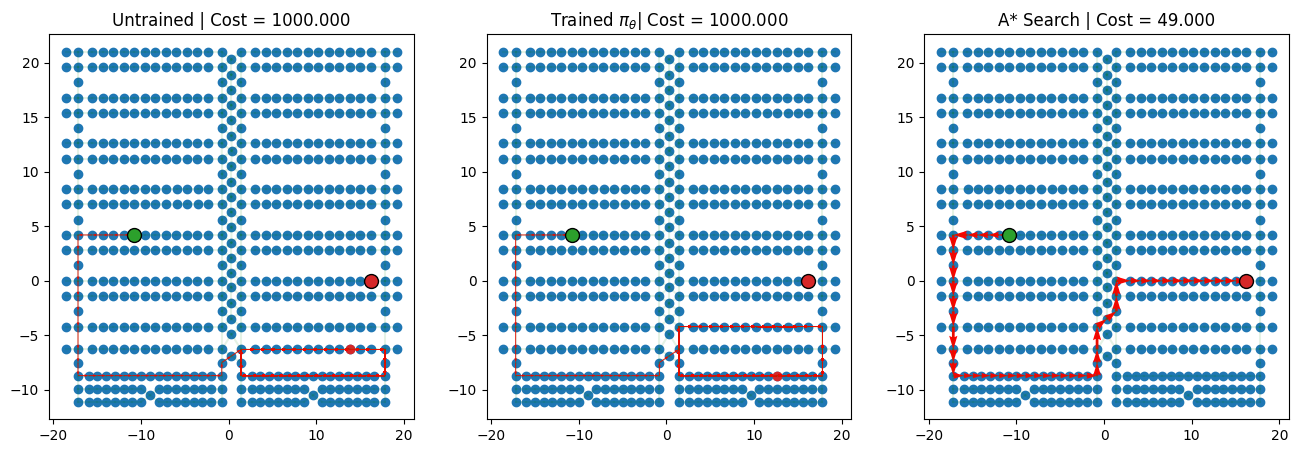

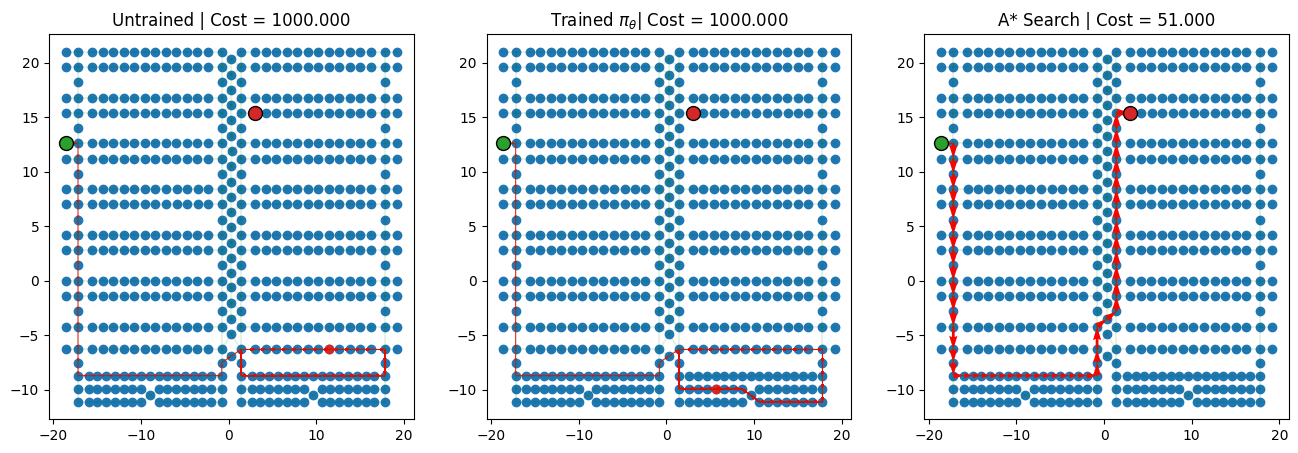

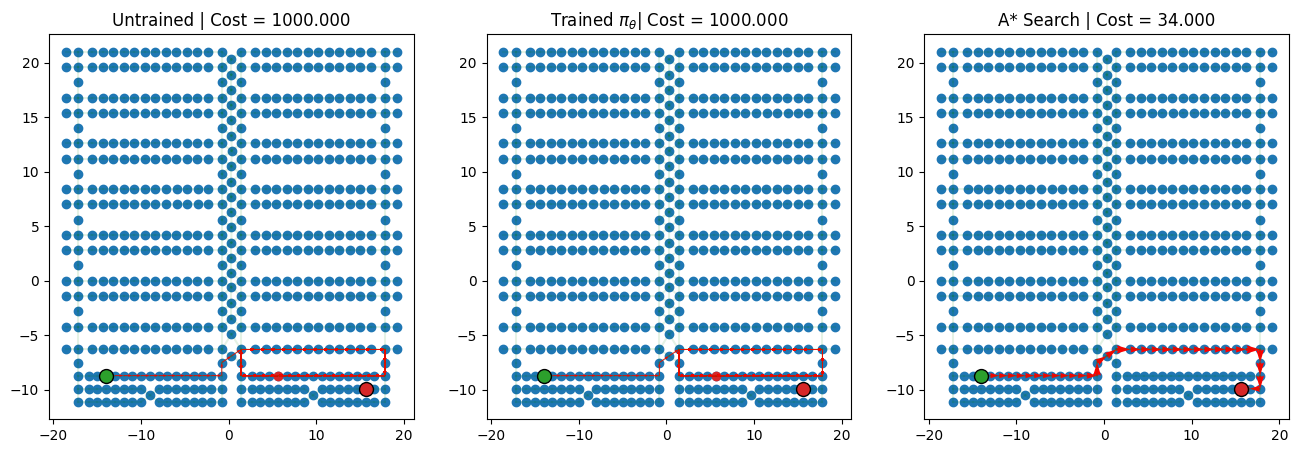

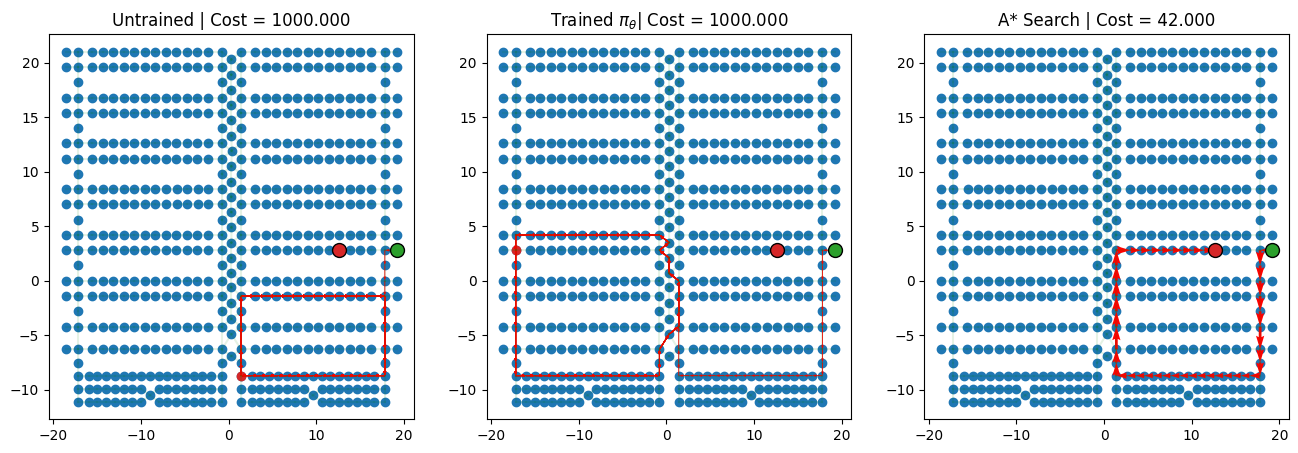

In [8]:
from astar import AStarSearch

# infer_env = SPPEnv(num_loc=500)
#from SPPenv import SPPEnv
#infer_env = SPPDynamicEnv(num_loc=100)
# infer_env = SPPEnv(num_loc=100)

# td_init = env.reset(batch_size=[3]).to(device)

# model = model.to(device)
# out = model(td_init.clone(),env=env, phase="test", decode_type="greedy",
# return_actions=True)
# actions_trained = out['actions'].cpu().detach()

policy = model.policy.to(device)
out = policy(td_init.clone(), env, phase="test", decode_type="greedy", return_actions=True)
actions_trained = out['actions'].cpu().detach()

# run A* search on the environment
astar = AStarSearch(td_init.clone())
astar_out = astar.search()
actions_astar = astar_out["actions"].cpu().detach()

# Plotting
import matplotlib.pyplot as plt
for i, td in enumerate(td_init):
    fig, axs = plt.subplots(1,3, figsize=(16,5))
    env.render(td, actions_untrained[i], ax=axs[0])
    axs[0].set_title(f"Untrained | Cost = {-rewards_untrained[i].item():.3f}")

    env.render(td, actions_trained[i], ax=axs[1])
    axs[1].set_title(r"Trained $\pi_\theta$" + f"| Cost = {-out['reward'][i].item():.3f}")

    env.render(td, actions_astar[i], ax=axs[2])
    axs[2].set_title("A* Search | Cost = {:.3f}".format(-astar_out["reward"][i].item()))

# Test trained model on grid map with obstacles

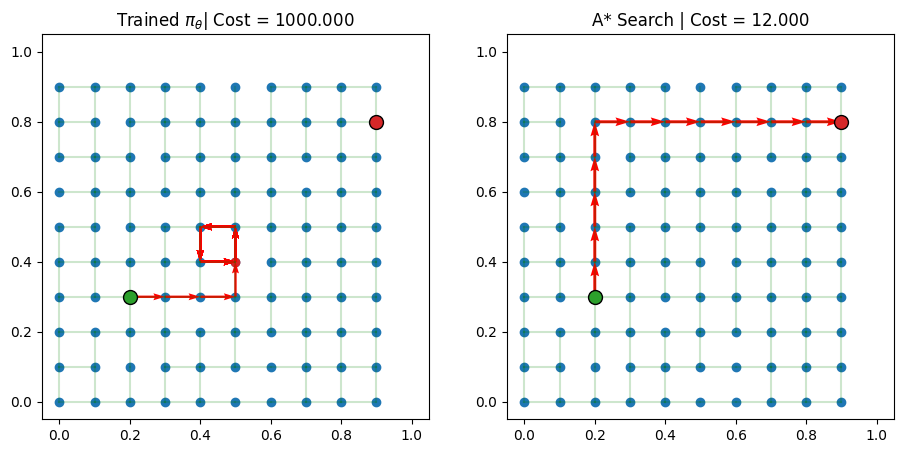

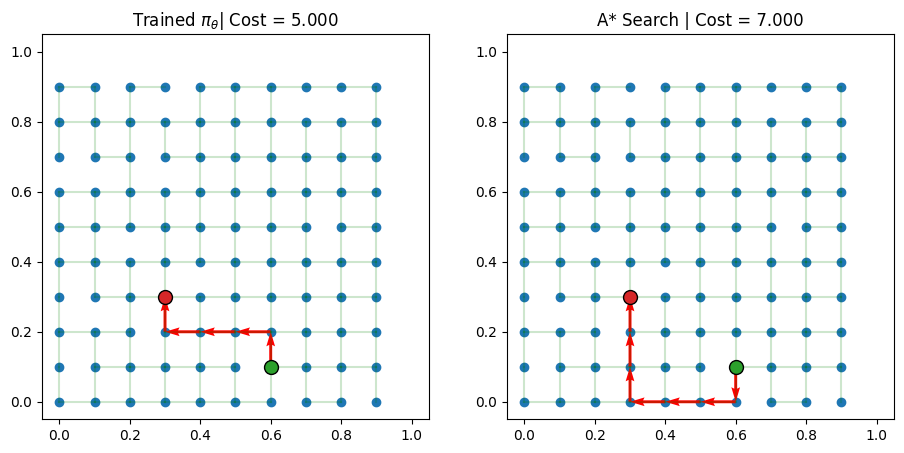

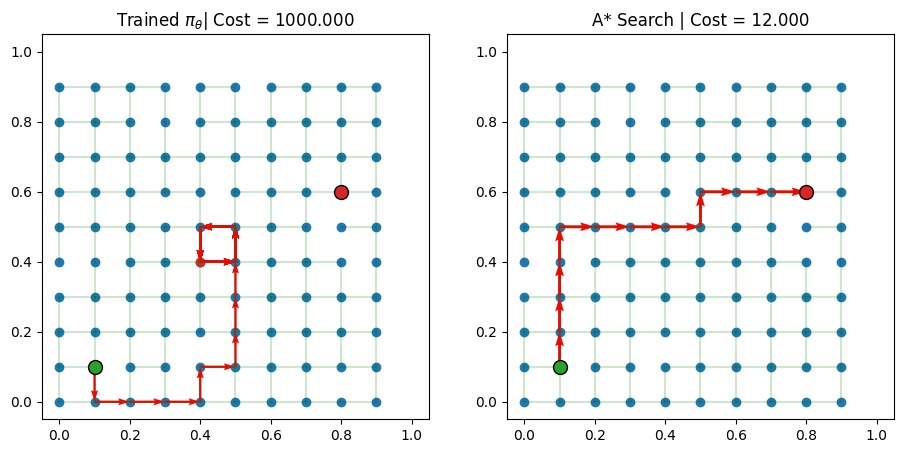

In [9]:
from SPPv2env import SPPv2Env

infer_env = SPPv2Env(num_loc=100)
td_init = infer_env.reset(batch_size=[3]).to(device)

policy = model.policy.to(device)
out = policy(td_init.clone(), infer_env, phase="test", decode_type="greedy", return_actions=True)
actions_trained = out['actions'].cpu().detach()

# run A* search on the environment
astar = AStarSearch(td_init.clone())
astar_out = astar.search()
actions_astar = astar_out["actions"].cpu().detach()

# Plotting
import matplotlib.pyplot as plt
for i, td in enumerate(td_init):
    fig, axs = plt.subplots(1,2, figsize=(11,5))

    infer_env.render(td, actions_trained[i], ax=axs[0])
    axs[0].set_title(r"Trained $\pi_\theta$" + f"| Cost = {-out['reward'][i].item():.3f}")

    infer_env.render(td, actions_astar[i], ax=axs[1])
    axs[1].set_title("A* Search | Cost = {:.3f}".format(-astar_out["reward"][i].item()))

In [10]:
# import numpy as np
# # Initialize the total costs
# total_cost_trained = 0
# total_cost_astar = 0
# cost_list_trained = np.array([])
# cost_list_astar = np.array([])
# 
# # Number of runs
# num_runs = 100
# 
# batch_size = 10
# 
# # Initialize the action lists
# actions_trained = []
# actions_astar = []
# 
# # Initialize the TensorDict list
# td_list = []
# 
# for _ in range(num_runs):
#     while True:
#         try:
#             # Initialize the action lists for the current run
#             actions_trained_run = []
#             actions_astar_run = []
# 
#             # infer_env = SPPEnv(num_loc=100)
#             # td_init = infer_env.reset(batch_size=[batch_size]).to(device)
# 
#             infer_env = SPPv2Env(num_loc=100)
#             td_init = infer_env.reset(batch_size=[batch_size]).to(device)
# 
#             # Run the trained DRL model
#             out = policy(td_init.clone(), infer_env, phase="test", decode_type="multistart_greedy", return_actions=True)
#             total_cost_trained += out['reward'].sum().item()
# 
#             # Run A* search
#             astar = AStarSearch(td_init.clone())
#             astar_out = astar.search()
#             total_cost_astar += astar_out["reward"].sum().item()
# 
#             # Store the TensorDict
#             td_list.append(td_init)
# 
#             # Store the output of the astar and trained model
#             actions_trained.append(out["actions"].cpu().detach())
#             actions_astar.append(astar_out["actions"].cpu().detach())
# 
#             # Store the cost of the trained model and A* search
#             cost_list_trained = np.append(cost_list_trained, out["reward"].cpu().detach().numpy())
#             cost_list_astar = np.append(cost_list_astar, astar_out["reward"].cpu().detach().numpy())
# 
#             break
#         except:
#             continue
# 
#     # Append the action lists for the current run to the overall action list
#     # actions_trained.append(actions_trained_run)
#     # actions_astar.append(actions_astar_run)
# 
# # How many -1000 rewards are there in the trained DRL model
# nosols_trained = np.sum(cost_list_trained == -1000)
# print(f"Number of unsolved problems in trained DRL model: {nosols_trained}")
# 
# # Remove all the -1000 rewards
# cost_list_trained_filtered = cost_list_trained[cost_list_trained != -1000]

In [11]:
# # Calculate the average costs
# print ("Mean cost of trained DRL model over {} runs: {:.3f}".format(num_runs * batch_size, cost_list_trained_filtered.mean()))
# print ("Mean cost of A* search over {} runs: {:.3f}".format(num_runs * batch_size, cost_list_astar.mean()))
# 
# # Calculate the mean and standard deviation of the costs
# print ("Median cost of trained DRL model over {} runs: {:.3f}".format(num_runs * batch_size, np.median(cost_list_trained_filtered)))
# print ("Median cost of A* search over {} runs: {:.3f}".format(num_runs * batch_size, np.median(cost_list_astar)))
# print ("Standard deviation of trained DRL model over {} runs: {:.3f}".format(num_runs * batch_size, cost_list_trained_filtered.std()))
# print ("Standard deviation of A* search over {} runs: {:.3f}".format(num_runs * batch_size, cost_list_astar.std()))
# 
# # Plot the histogram of the costs
# plt.hist(cost_list_trained_filtered, bins=20, alpha=0.7, label='Trained DRL Model')
# plt.hist(cost_list_astar, bins=20, alpha=0.7, label='A* Search')
# plt.legend(loc='upper right')
# plt.xlabel('Cost')
# plt.ylabel('Frequency')
# plt.title('Histogram of costs')
# plt.show()
# 
# # Get the indices of the runs with the highest costs
# worst_runs = np.argsort(cost_list_astar)[::-1][-3:]
# print(worst_runs)
# print(cost_list_astar[worst_runs])
# 
# # Plot the actions for the first run
# import matplotlib.pyplot as plt
# 
# for run in worst_runs:
#     quotient, remainder = divmod(run, batch_size)
#     print(quotient, remainder)
#     for i, td in enumerate(td_list[quotient]):
#         if i == remainder:
#             fig, axs = plt.subplots(1,2, figsize=(11,5))
# 
#             try:
#                 infer_env.render(td, actions_trained[quotient][i], ax=axs[0])
#                 axs[0].set_title(r"Trained $\pi_\theta$" + f"| Cost = {cost_list_trained[run]:.3f}")
#             except Exception as e:
#                 print(e)
#                 print("Error in plotting trained model")
#                 pass
# 
#             infer_env.render(td, actions_astar[quotient][i], ax=axs[1])
#             axs[1].set_title("A* Search | Cost = {:.3f}".format(cost_list_astar[run]))
# 
# # Plot the actions with the largest difference between the trained model and A* search
# diff = - cost_list_trained + cost_list_astar
# largest_diffs = np.argsort(diff)[::-1][:3]
# print(largest_diffs)
# 
# for run in largest_diffs:
#     quotient, remainder = divmod(run, batch_size)
#     print(quotient, remainder)
#     for i, td in enumerate(td_list[quotient]):
#         if i == remainder:
#             fig, axs = plt.subplots(1,2, figsize=(11,5))
# 
#             try:
#                 infer_env.render(td, actions_trained[quotient][i], ax=axs[0])
#                 axs[0].set_title(r"Trained $\pi_\theta$" + f"| Cost = {cost_list_trained[run]:.3f}")
#             except Exception as e:
#                 print(e)
#                 print("Error in plotting trained model")
#                 pass
# 
#             infer_env.render(td, actions_astar[quotient][i], ax=axs[1])
#             axs[1].set_title("A* Search | Cost = {:.3f}".format(cost_list_astar[run]))

# Real Floorplan Path Finding with Reinforcement Learning and Astar Search

## Salt Lake City Floorplan


num_loc: 58
batch_size in reset: [4]
batch_size: 4
self.locs.shape before unsqueeze: torch.Size([58, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 58, 2])
Row Length: 58
Column Length: 58
No NaN values found in the tensor dictionary.


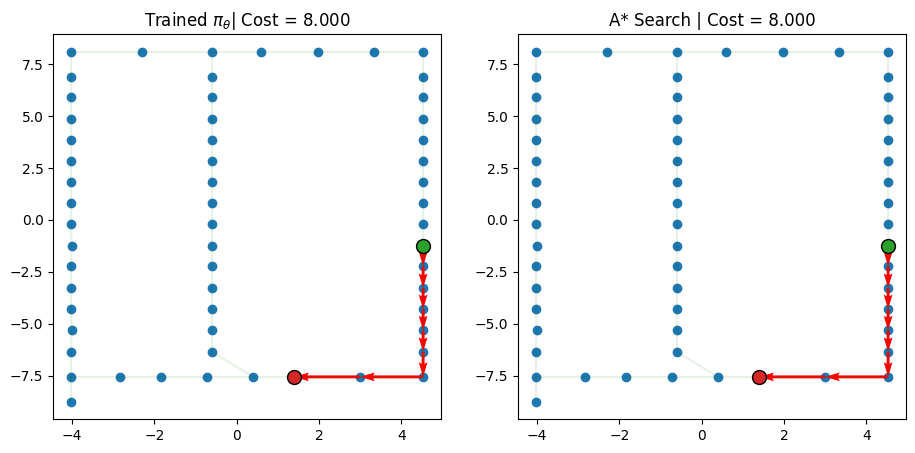

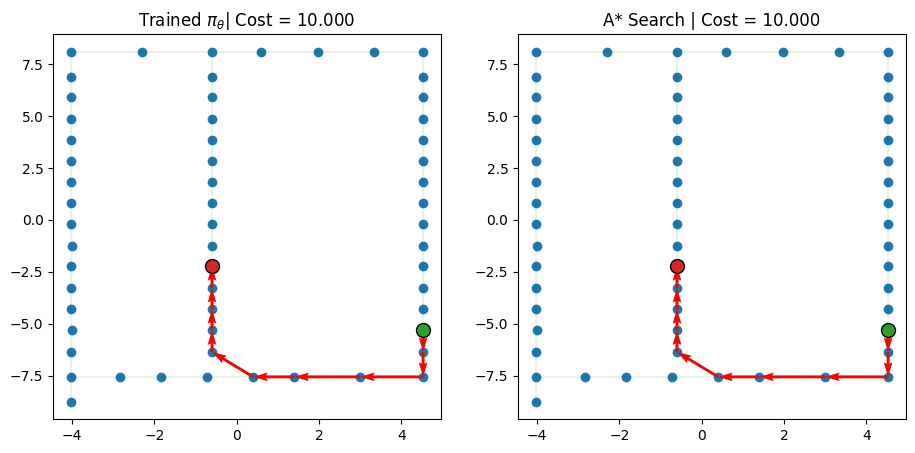

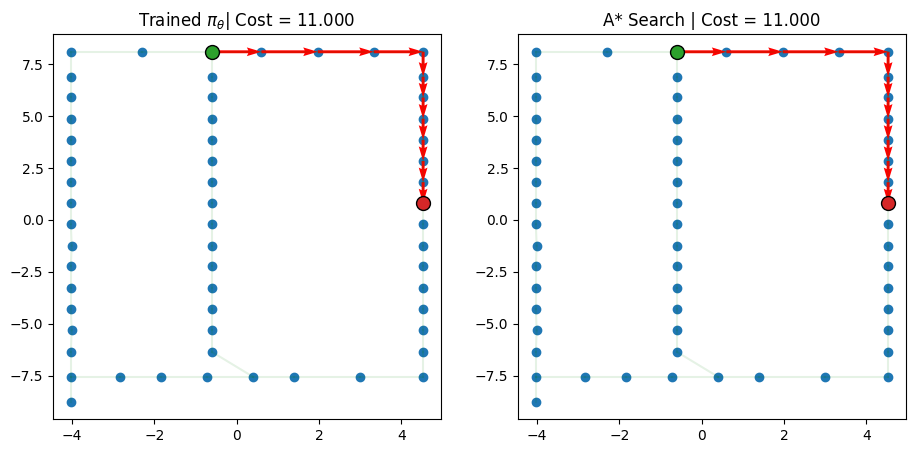

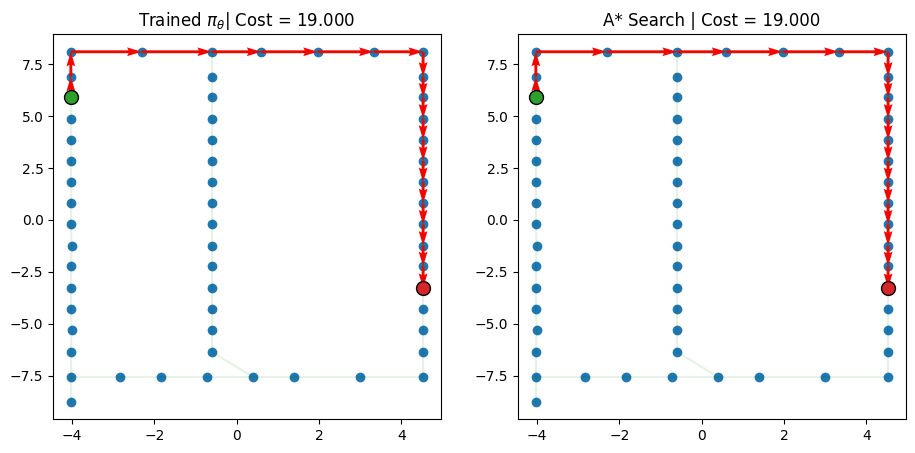

In [12]:
from FPenv import FPEnv
from astar import AStarSearch
import torch

# Setup a device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

infer_env = FPEnv(fp_path="Floorplans/USPS/0026_Salt_Lake_City/floorplan.json")
td_init = infer_env.reset(batch_size=[4]).to(device)


# Function to check for NaNs in a tensor dictionary
nan_found = False
for key, tensor in td_init.items():
    if torch.isnan(tensor).any():
        nan_found = True
        print(f"NaN values found in tensor '{key}'")
if not nan_found:
    print("No NaN values found in the tensor dictionary.")

policy = model.policy.to(device)

out = policy(td_init.clone(), infer_env, phase="test", decode_type="greedy", return_actions=True)
actions_trained = out['actions'].cpu().detach()

# run A* search on the environment
astar = AStarSearch(td_init.clone())
astar_out = astar.search()
actions_astar = astar_out["actions"].cpu().detach()

# Plotting
import matplotlib.pyplot as plt
for i, td in enumerate(td_init):
    fig, axs = plt.subplots(1,2, figsize=(11,5))

    infer_env.render(td, actions_trained[i], ax=axs[0])
    axs[0].set_title(r"Trained $\pi_\theta$" + f"| Cost = {-out['reward'][i].item():.3f}")

    infer_env.render(td, actions_astar[i], ax=axs[1])
    axs[1].set_title("A* Search | Cost = {:.3f}".format(-astar_out["reward"][i].item()))


# Butterfly 14 x 11 Floorplan

num_loc: 568
batch_size in reset: [4]
batch_size: 4
self.locs.shape before unsqueeze: torch.Size([568, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 568, 2])
Row Length: 568
Column Length: 568
No NaN values found in the tensor dictionary.


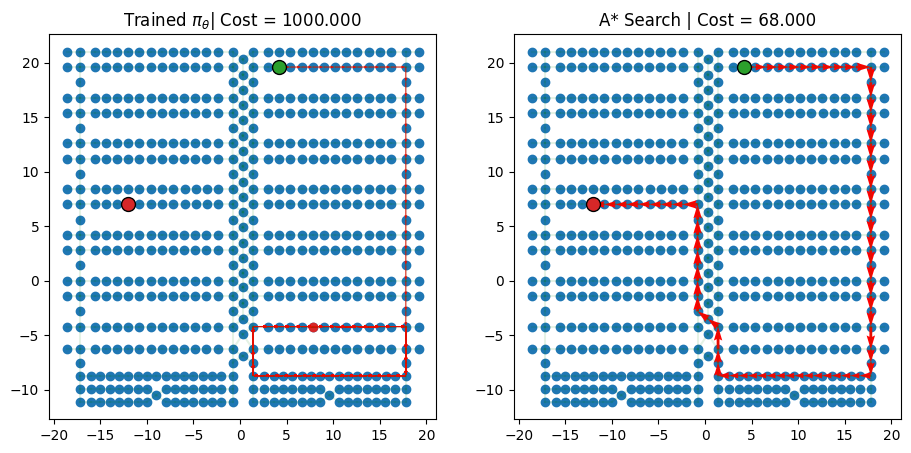

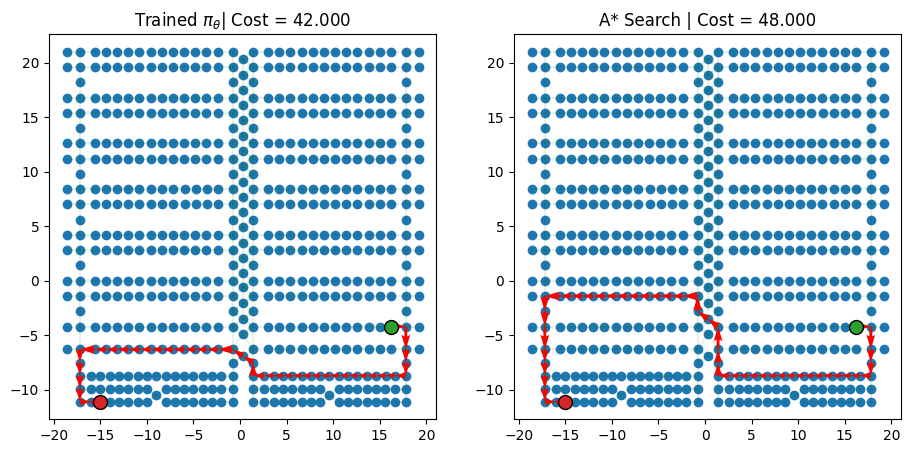

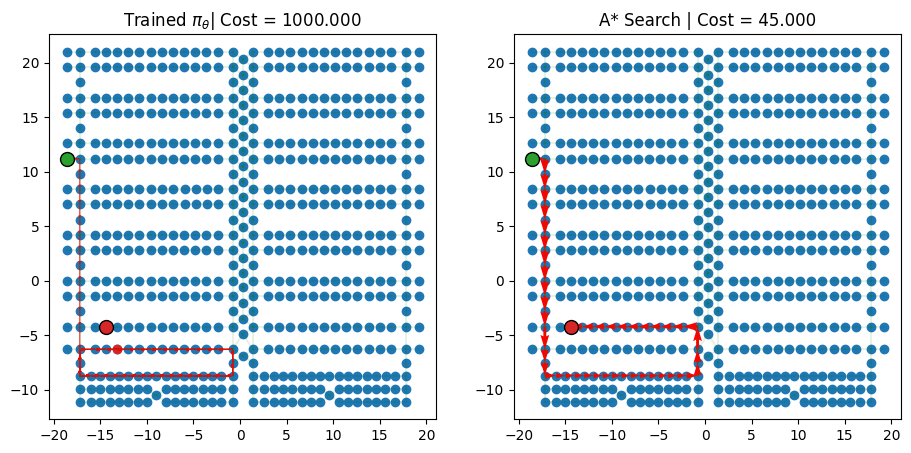

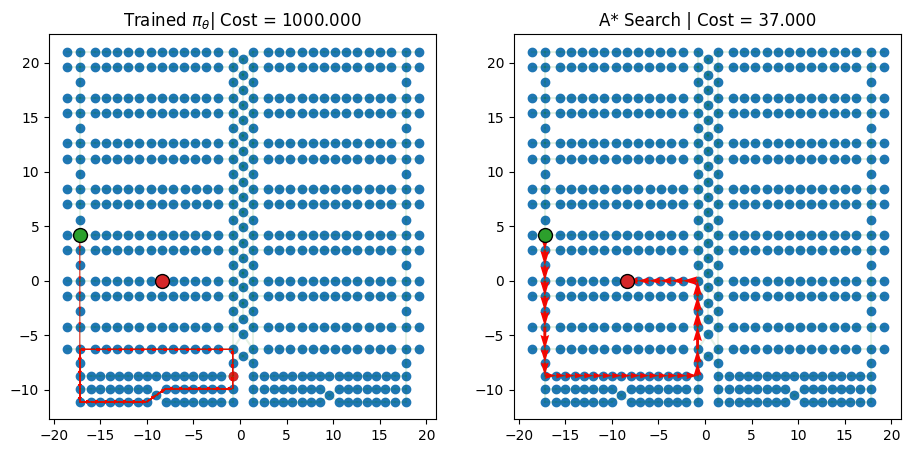

In [13]:
from FPenv import FPEnv
from astar import AStarSearch
import torch

# Setup a device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

infer_env = FPEnv(fp_path="Floorplans/quad-infeed/butterfly/14x11/floorplan.json")
td_init = infer_env.reset(batch_size=[4]).to(device)


# Function to check for NaNs in a tensor dictionary
nan_found = False
for key, tensor in td_init.items():
    if torch.isnan(tensor).any():
        nan_found = True
        print(f"NaN values found in tensor '{key}'")
if not nan_found:
    print("No NaN values found in the tensor dictionary.")

policy = model.policy.to(device)

out = policy(td_init.clone(), infer_env, phase="test", decode_type="greedy", return_actions=True)
actions_trained = out['actions'].cpu().detach()

# run A* search on the environment
astar = AStarSearch(td_init.clone())
astar_out = astar.search()
actions_astar = astar_out["actions"].cpu().detach()

# Plotting
import matplotlib.pyplot as plt
for i, td in enumerate(td_init):
    fig, axs = plt.subplots(1,2, figsize=(11,5))

    infer_env.render(td, actions_trained[i], ax=axs[0])
    axs[0].set_title(r"Trained $\pi_\theta$" + f"| Cost = {-out['reward'][i].item():.3f}")

    infer_env.render(td, actions_astar[i], ax=axs[1])
    axs[1].set_title("A* Search | Cost = {:.3f}".format(-astar_out["reward"][i].item()))


## All Floorplans

num_loc: 88
batch_size in reset: [4]
batch_size: 4
self.locs.shape before unsqueeze: torch.Size([88, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 88, 2])
Row Length: 88
Column Length: 88
No NaN values found in the tensor dictionary.


num_loc: 89
batch_size in reset: [4]
batch_size: 4
self.locs.shape before unsqueeze: torch.Size([89, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 89, 2])
Row Length: 89
Column Length: 89
No NaN values found in the tensor dictionary.


num_loc: 125
batch_size in reset: [4]
batch_size: 4
self.locs.shape before unsqueeze: torch.Size([125, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 125, 2])
Row Length: 125
Column Length: 125
No NaN values found in the tensor dictionary.


num_loc: 86
batch_size in reset: [4]
batch_size: 4
self.locs.shape before unsqueeze: torch.Size([86, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 86, 2])
Row Length: 86
Column Length: 86
No NaN values found in the tensor dictionary.


num_loc: 141
batch_size in reset: [4]
batch_size: 4
self.locs.shape before unsqueeze: torch.Size([141, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 141, 2])
Row Length: 141
Column Length: 141
No NaN values found in the tensor dictionary.


62
num_loc: 103
batch_size in reset: [4]
batch_size: 4
self.locs.shape before unsqueeze: torch.Size([103, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 103, 2])
Row Length: 103
Column Length: 103
No NaN values found in the tensor dictionary.


Tensors must have same number of dimensions: got 2 and 1
num_loc: 89
batch_size in reset: [4]
batch_size: 4
self.locs.shape before unsqueeze: torch.Size([89, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 89, 2])
Row Length: 89
Column Length: 89
No NaN values found in the tensor dictionary.


83
num_loc: 139
batch_size in reset: [4]
batch_size: 4
self.locs.shape before unsqueeze: torch.Size([139, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 139, 2])
Row Length: 139
Column Length: 139
No NaN values found in the tensor dictionary.


/tmp/ipykernel_21509/2624096729.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1,2, figsize=(11,5))


num_loc: 150
batch_size in reset: [4]
batch_size: 4
self.locs.shape before unsqueeze: torch.Size([150, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 150, 2])
Row Length: 150
Column Length: 150
No NaN values found in the tensor dictionary.


num_loc: 127
batch_size in reset: [4]
batch_size: 4
self.locs.shape before unsqueeze: torch.Size([127, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 127, 2])
Row Length: 127
Column Length: 127
No NaN values found in the tensor dictionary.


num_loc: 57
batch_size in reset: [4]
batch_size: 4
self.locs.shape before unsqueeze: torch.Size([57, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 57, 2])
Row Length: 57
Column Length: 57
No NaN values found in the tensor dictionary.


Expecting value: line 1 column 1 (char 0)
num_loc: 105
batch_size in reset: [4]
batch_size: 4
self.locs.shape before unsqueeze: torch.Size([105, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 105, 2])
Row Length: 105
Column Length: 105
No NaN values found in the tensor dictionary.


num_loc: 254
batch_size in reset: [4]
batch_size: 4
self.locs.shape before unsqueeze: torch.Size([254, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 254, 2])
Row Length: 254
Column Length: 254
No NaN values found in the tensor dictionary.


num_loc: 60
batch_size in reset: [4]
batch_size: 4
self.locs.shape before unsqueeze: torch.Size([60, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 60, 2])
Row Length: 60
Column Length: 60
No NaN values found in the tensor dictionary.


num_loc: 149
batch_size in reset: [4]
batch_size: 4
self.locs.shape before unsqueeze: torch.Size([149, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 149, 2])
Row Length: 149
Column Length: 149
No NaN values found in the tensor dictionary.


num_loc: 151
batch_size in reset: [4]
batch_size: 4
self.locs.shape before unsqueeze: torch.Size([151, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 151, 2])
Row Length: 151
Column Length: 151
No NaN values found in the tensor dictionary.


num_loc: 84
batch_size in reset: [4]
batch_size: 4
self.locs.shape before unsqueeze: torch.Size([84, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 84, 2])
Row Length: 84
Column Length: 84
No NaN values found in the tensor dictionary.


num_loc: 28
batch_size in reset: [4]
batch_size: 4
self.locs.shape before unsqueeze: torch.Size([28, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 28, 2])
Row Length: 28
Column Length: 28
No NaN values found in the tensor dictionary.
num_loc: 62
batch_size in reset: [4]
batch_size: 4
self.locs.shape before unsqueeze: torch.Size([62, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 62, 2])
Row Length: 62
Column Length: 62
No NaN values found in the tensor dictionary.


num_loc: 126
batch_size in reset: [4]
batch_size: 4
self.locs.shape before unsqueeze: torch.Size([126, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 126, 2])
Row Length: 126
Column Length: 126
No NaN values found in the tensor dictionary.


num_loc: 130
batch_size in reset: [4]
batch_size: 4
self.locs.shape before unsqueeze: torch.Size([130, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 130, 2])
Row Length: 130
Column Length: 130
No NaN values found in the tensor dictionary.


num_loc: 57
batch_size in reset: [4]
batch_size: 4
self.locs.shape before unsqueeze: torch.Size([57, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 57, 2])
Row Length: 57
Column Length: 57
No NaN values found in the tensor dictionary.


num_loc: 156
batch_size in reset: [4]
batch_size: 4
self.locs.shape before unsqueeze: torch.Size([156, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 156, 2])
Row Length: 156
Column Length: 156
No NaN values found in the tensor dictionary.


num_loc: 58
batch_size in reset: [4]
batch_size: 4
self.locs.shape before unsqueeze: torch.Size([58, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 58, 2])
Row Length: 58
Column Length: 58
No NaN values found in the tensor dictionary.


num_loc: 156
batch_size in reset: [4]
batch_size: 4
self.locs.shape before unsqueeze: torch.Size([156, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 156, 2])
Row Length: 156
Column Length: 156
No NaN values found in the tensor dictionary.


16
num_loc: 70
batch_size in reset: [4]
batch_size: 4
self.locs.shape before unsqueeze: torch.Size([70, 2])
self.locs.shape after unsqueeze and repeat: torch.Size([4, 70, 2])
Row Length: 70
Column Length: 70
No NaN values found in the tensor dictionary.


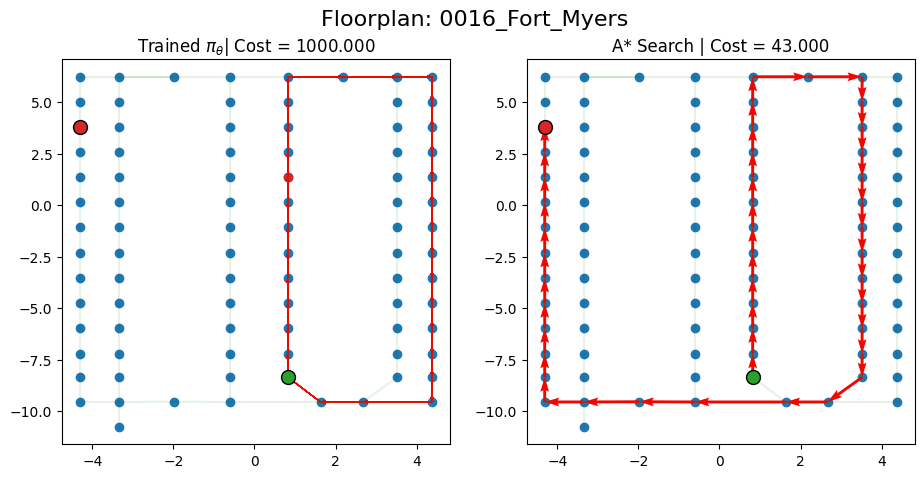

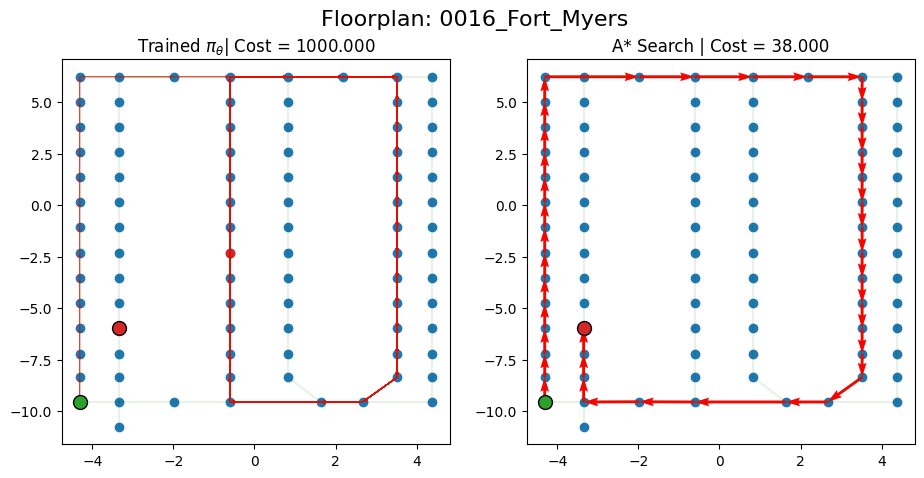

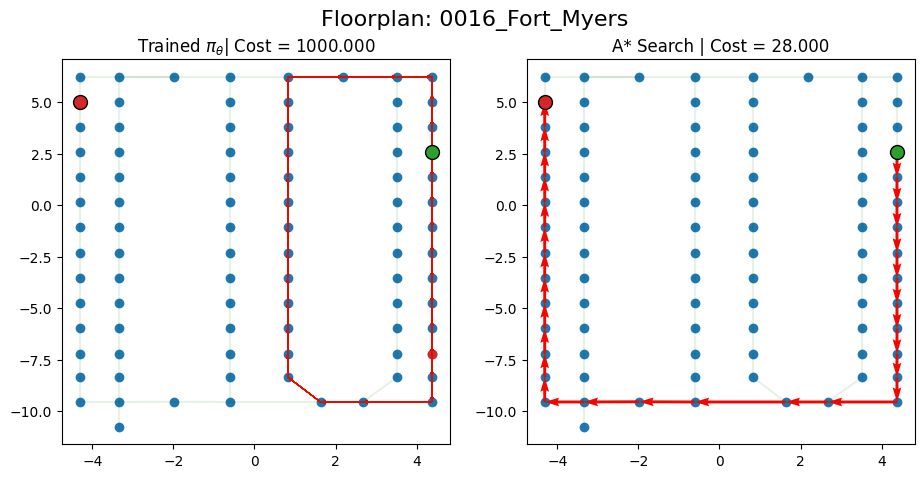

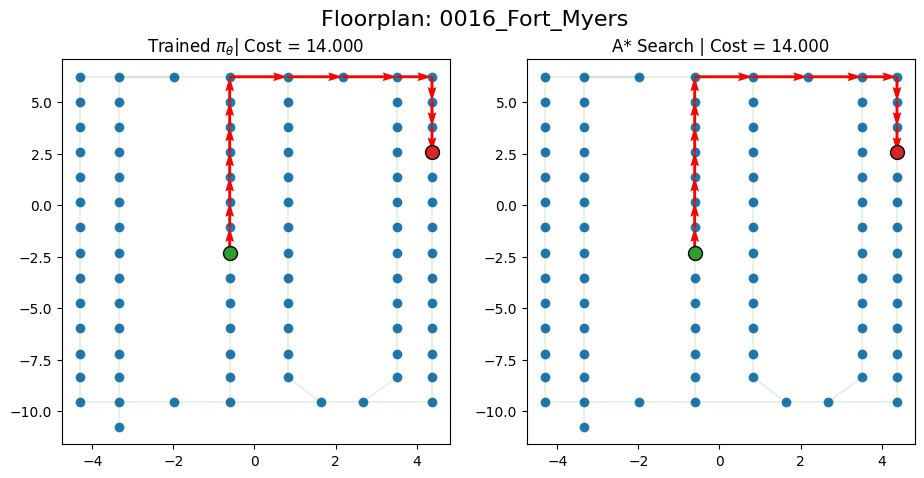

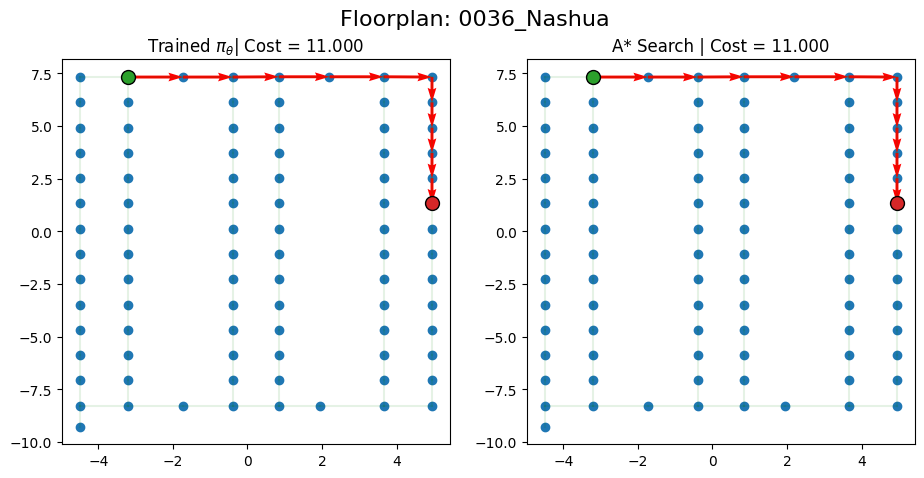

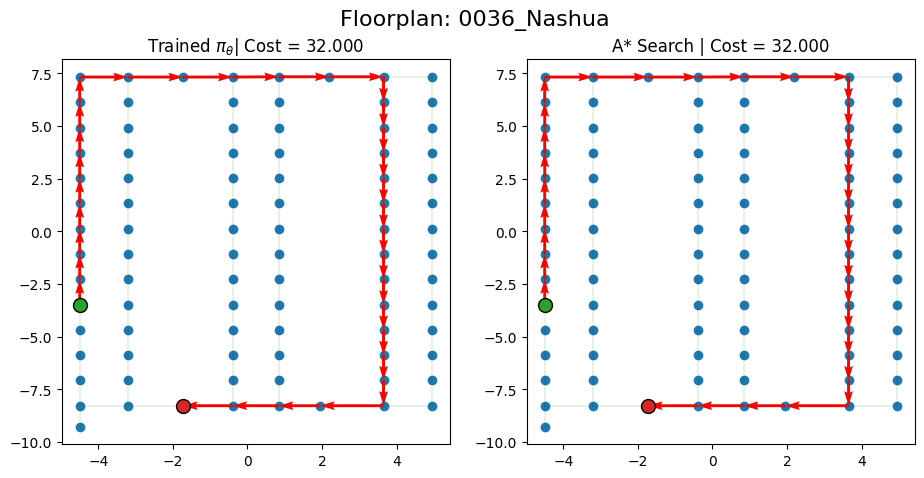

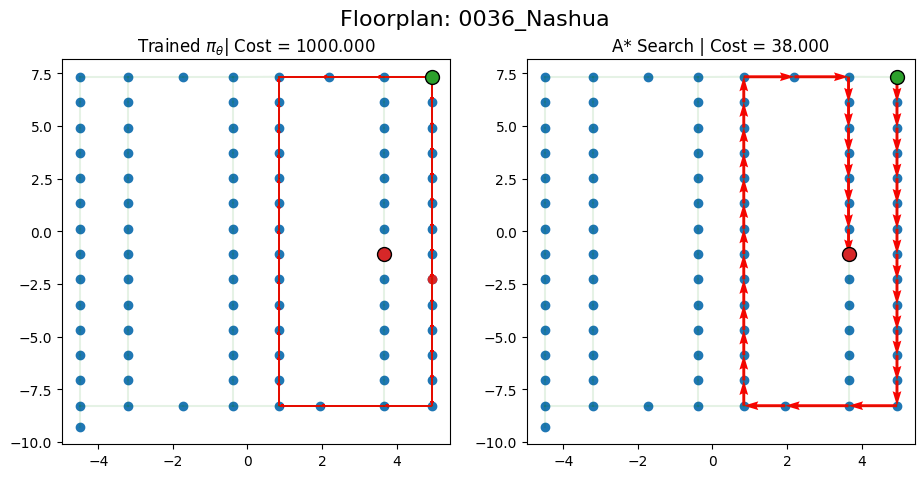

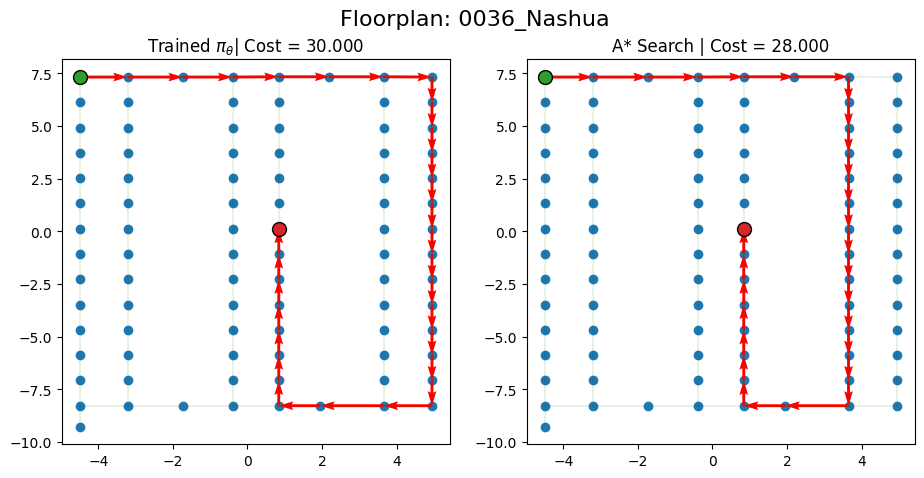

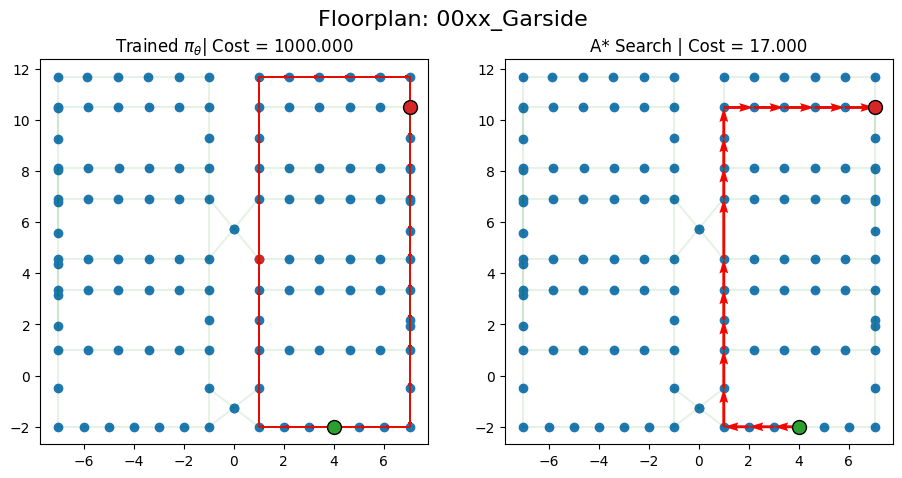

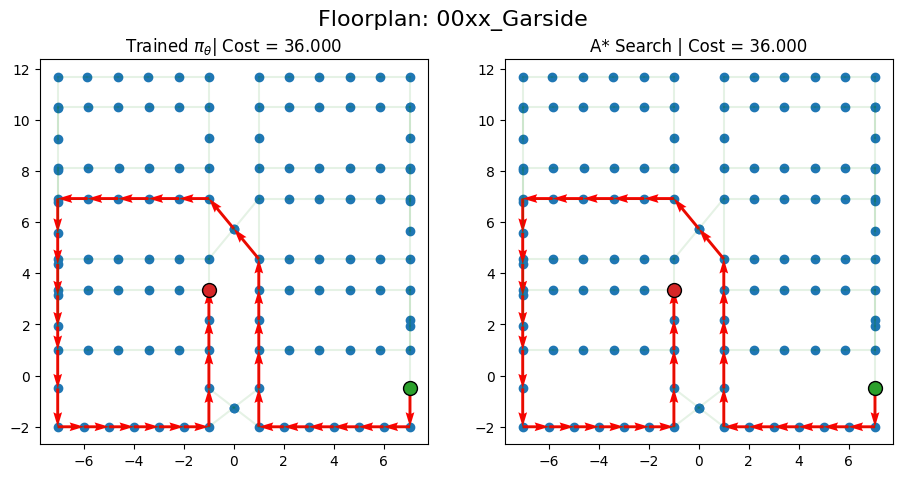

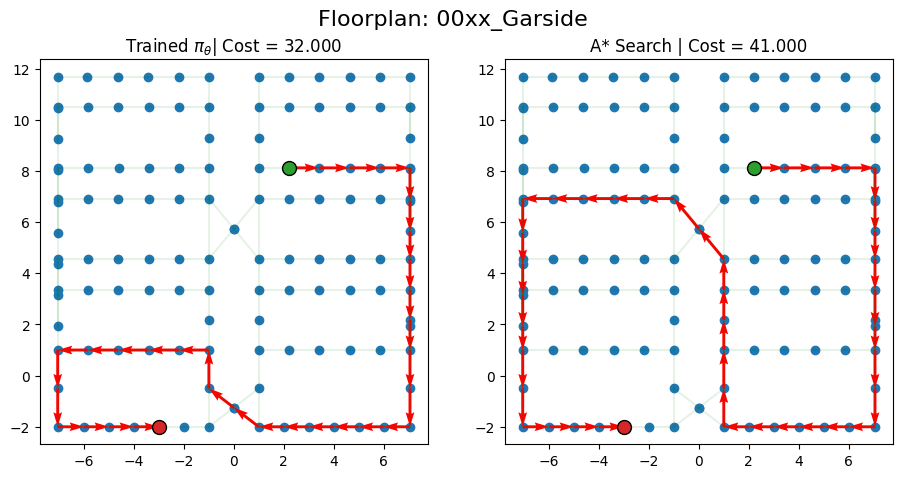

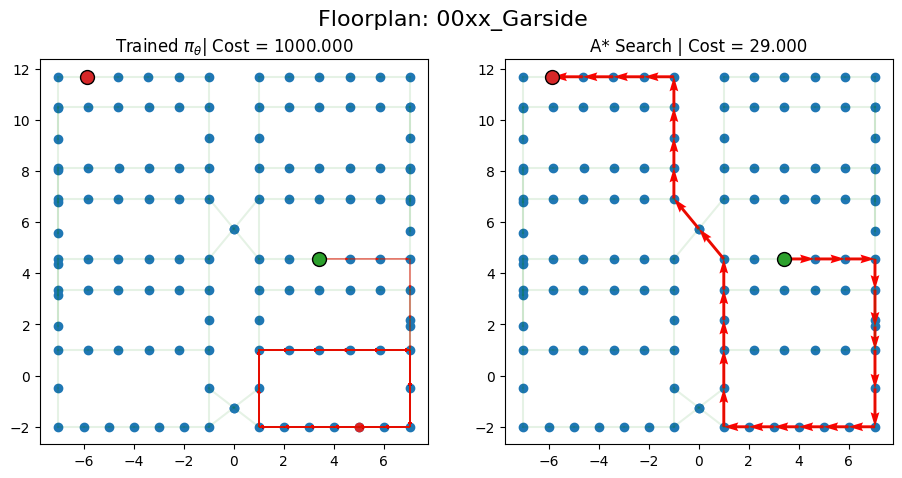

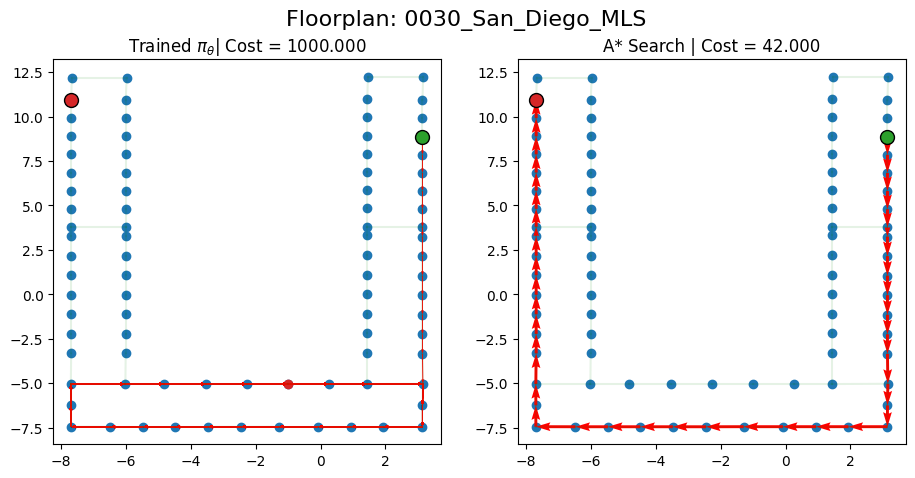

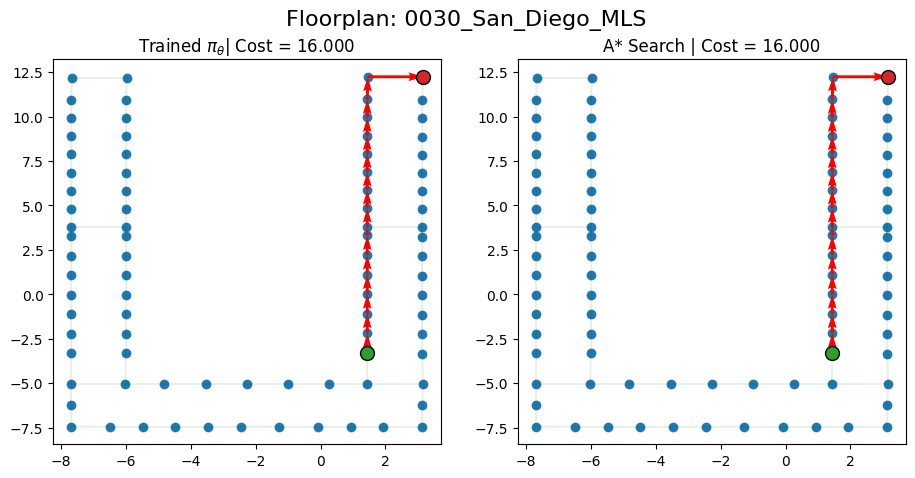

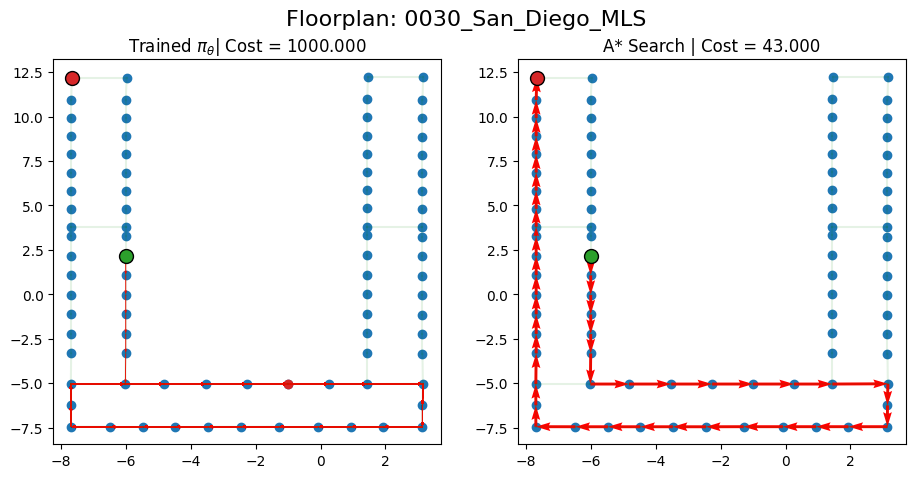

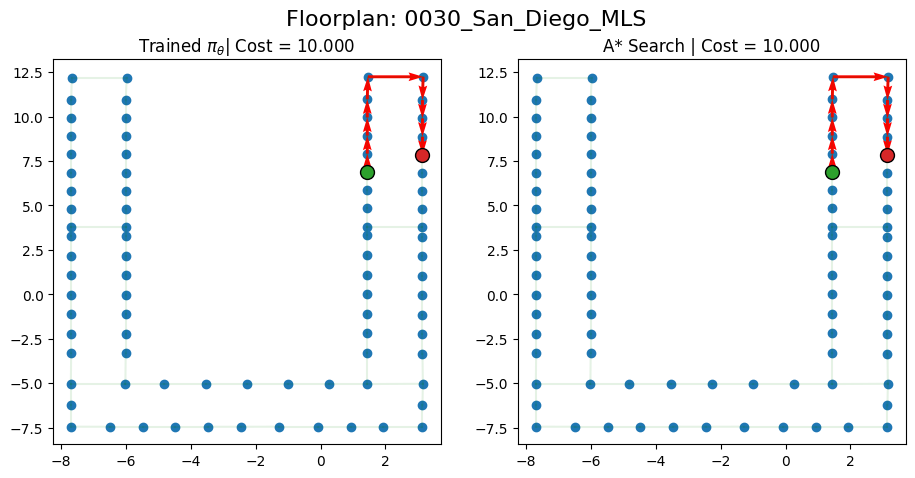

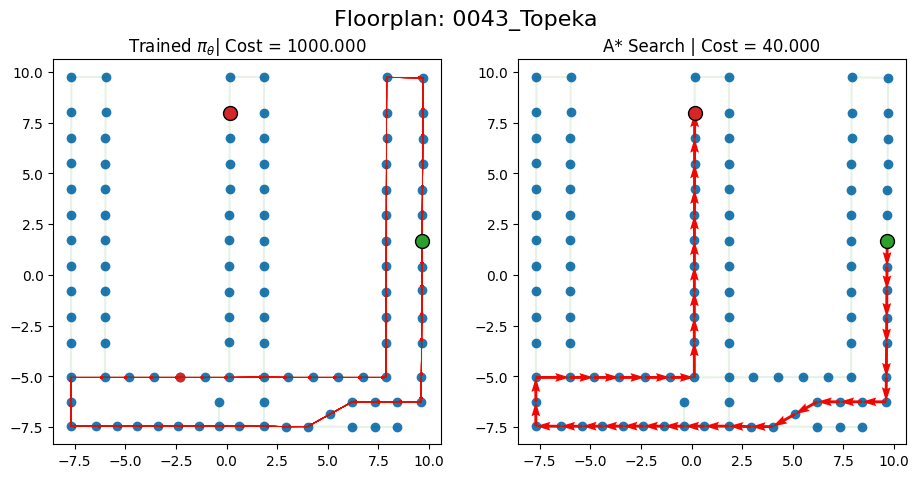

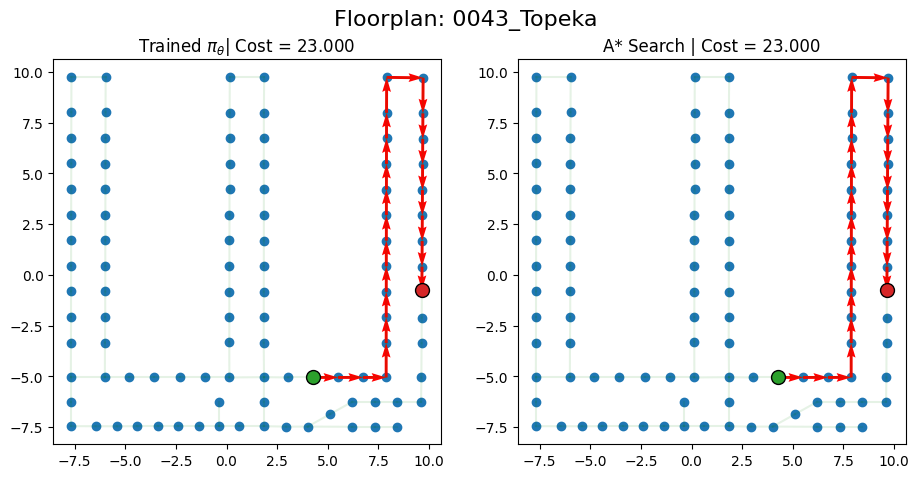

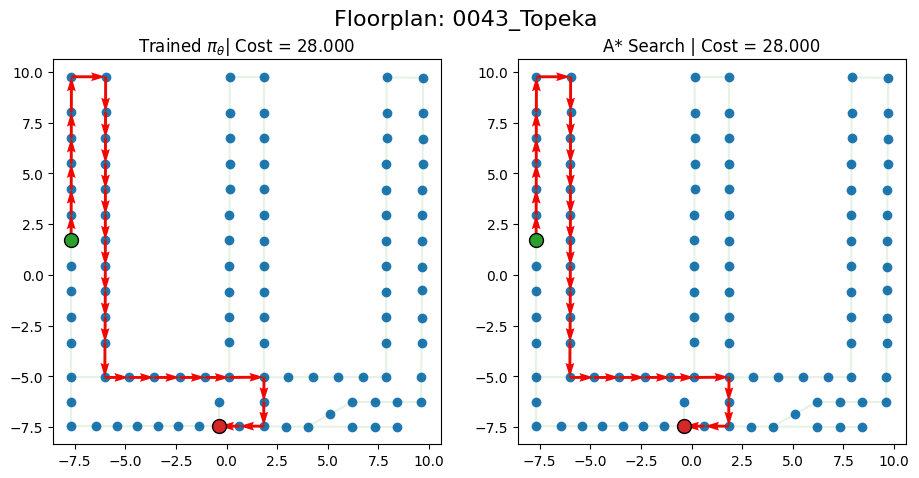

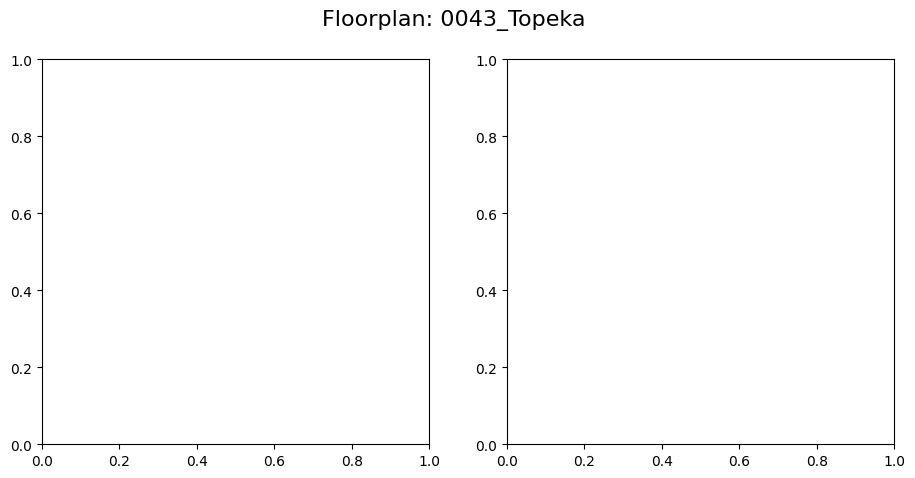

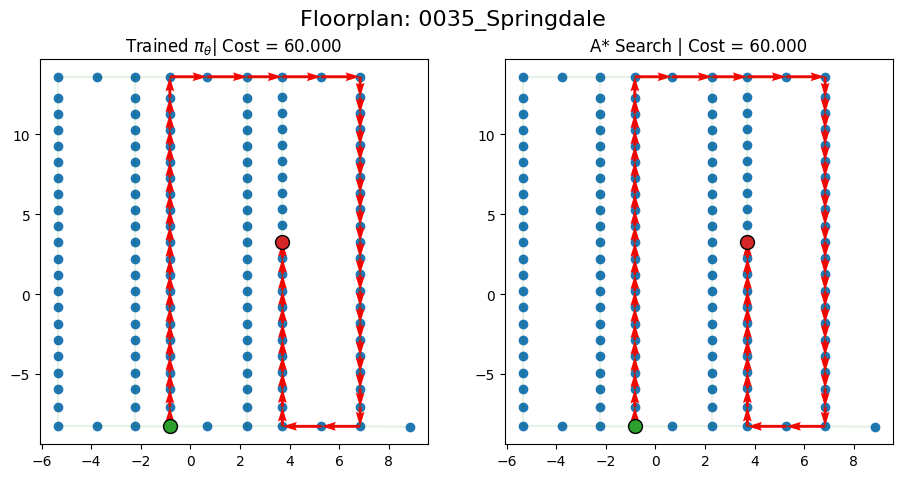

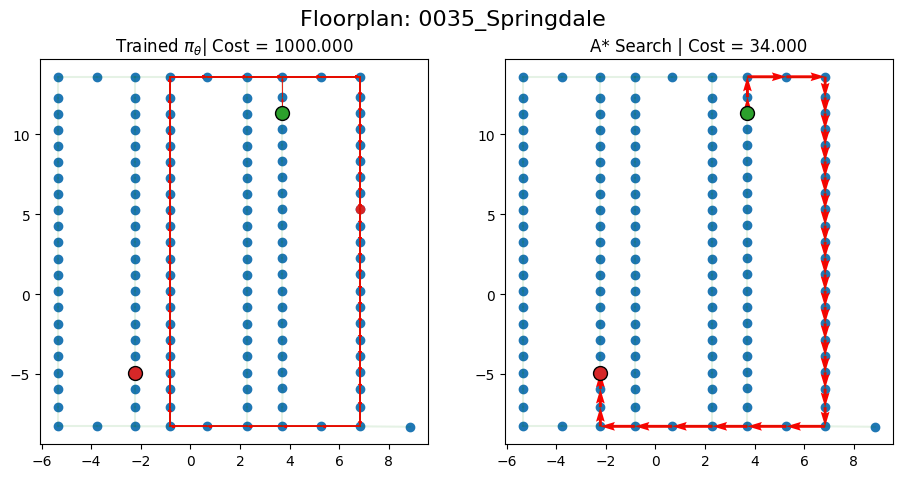

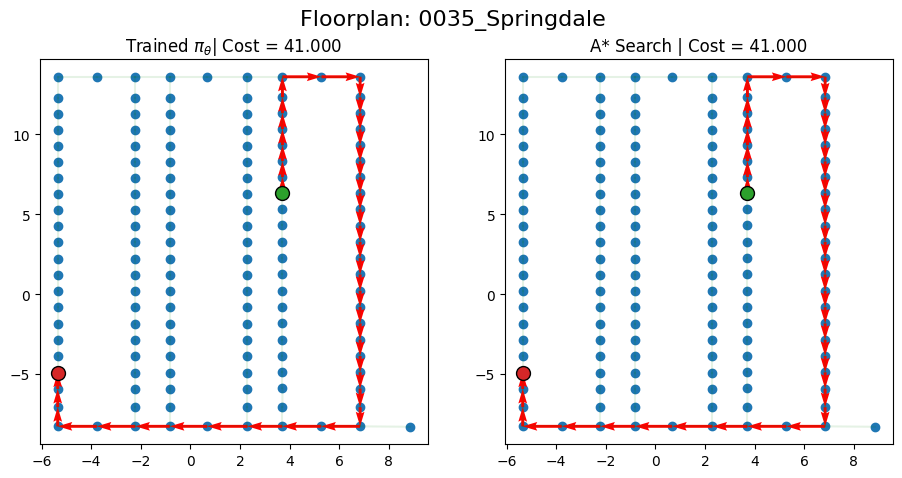

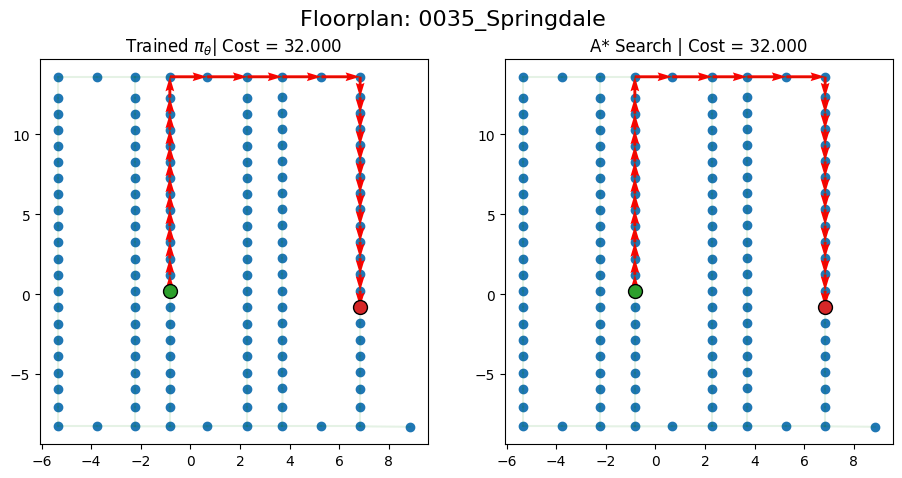

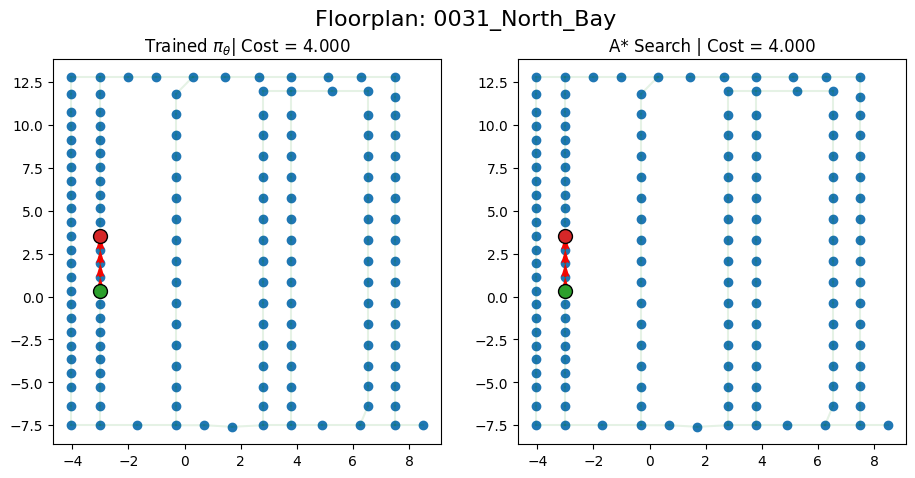

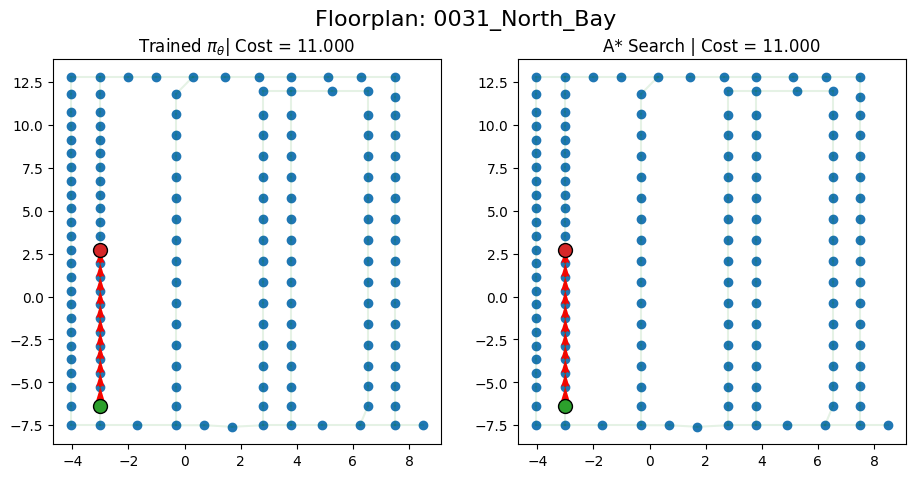

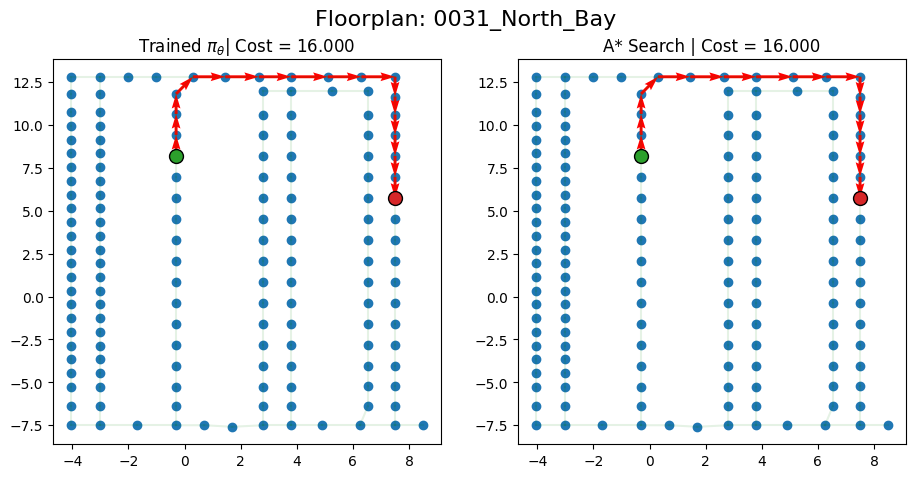

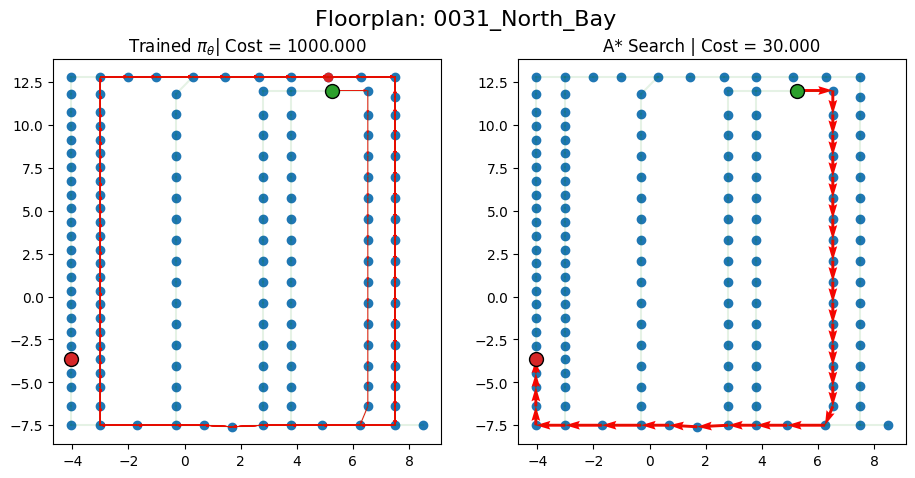

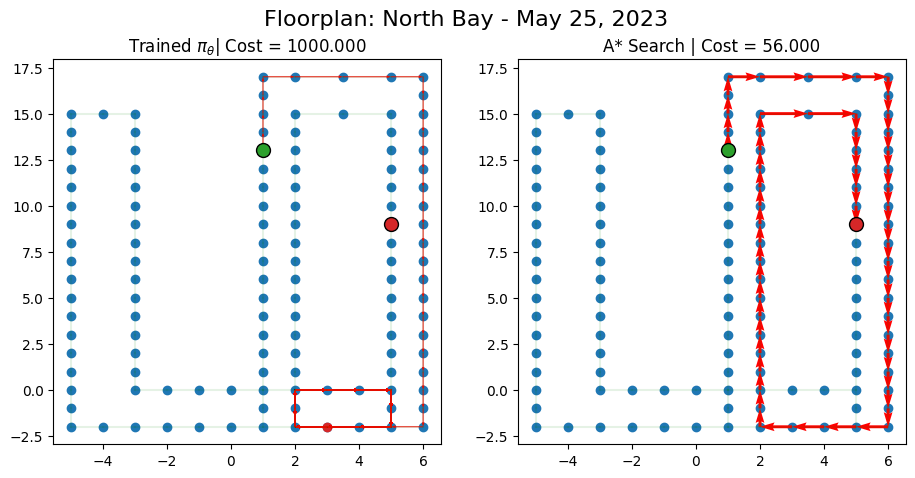

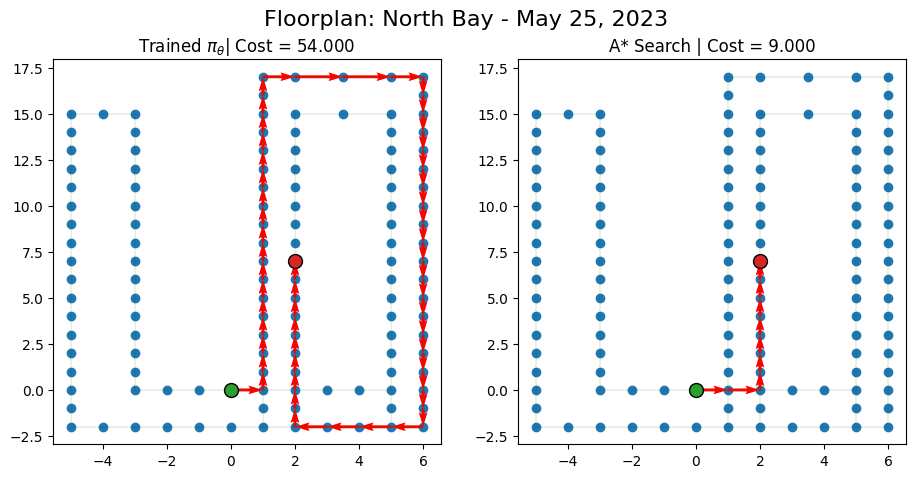

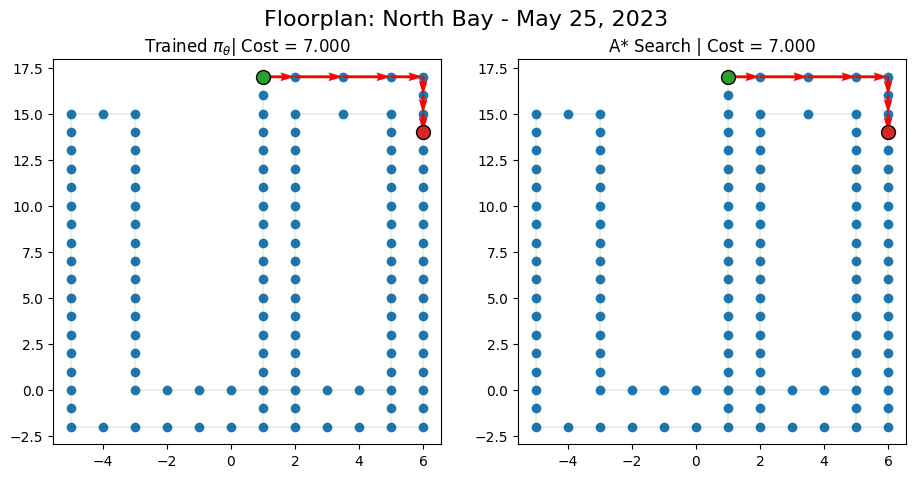

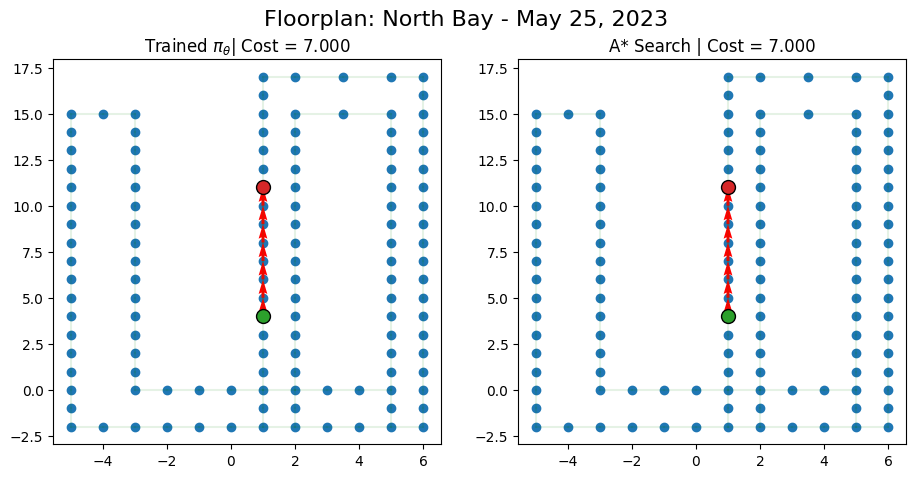

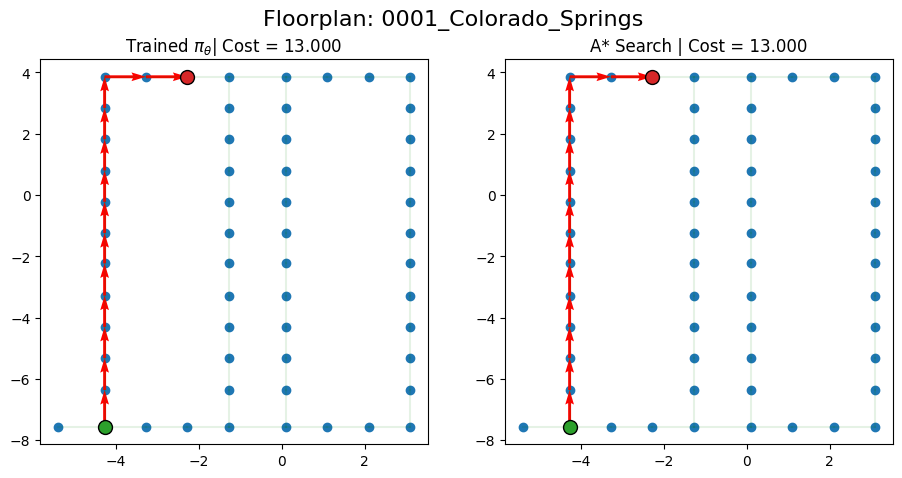

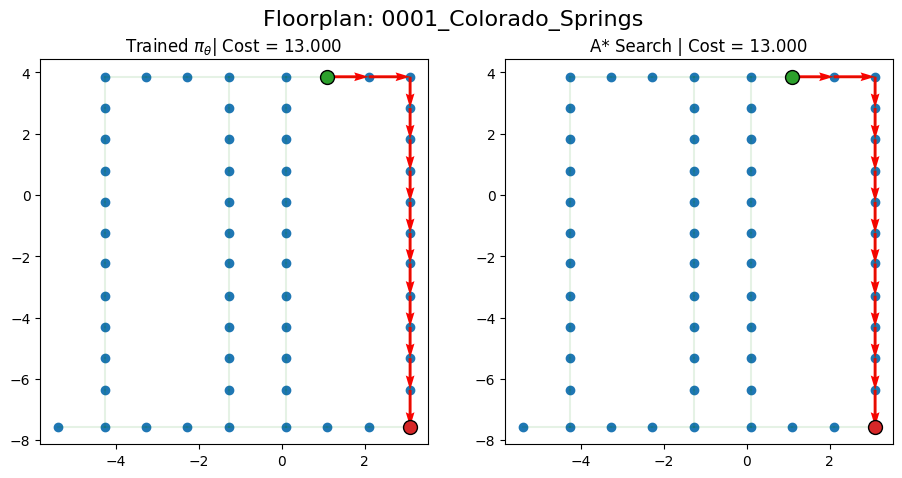

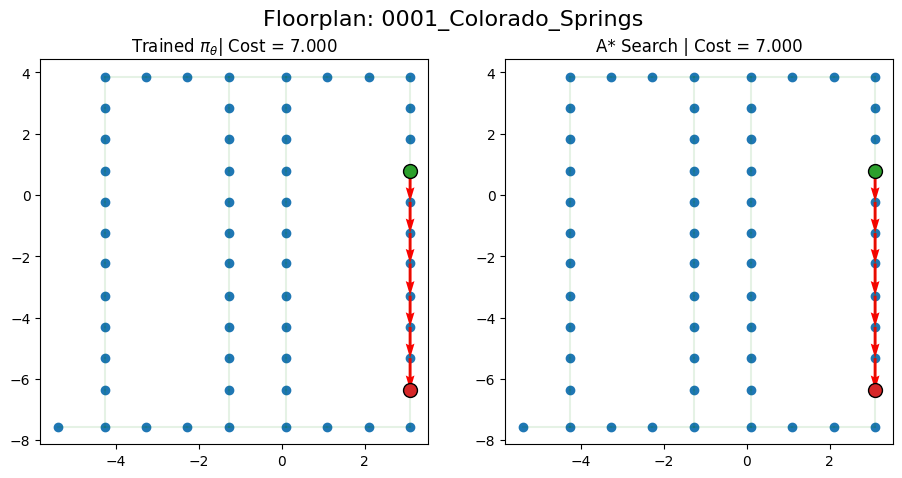

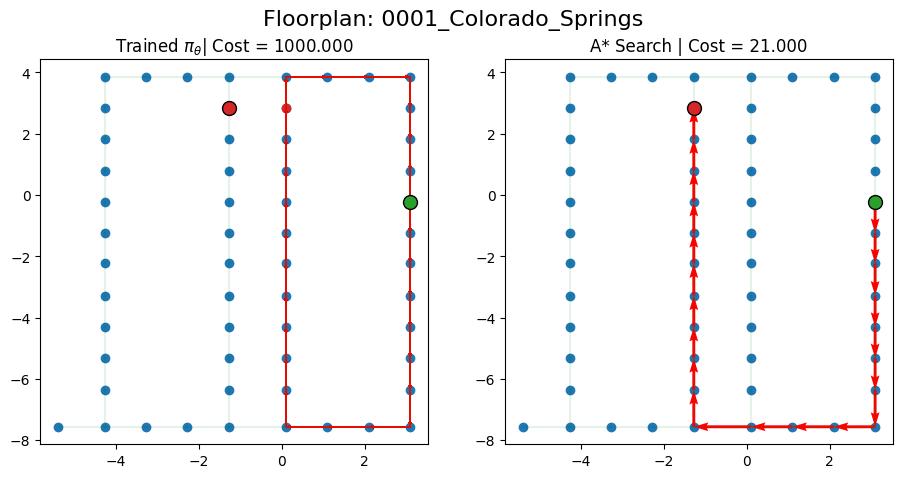

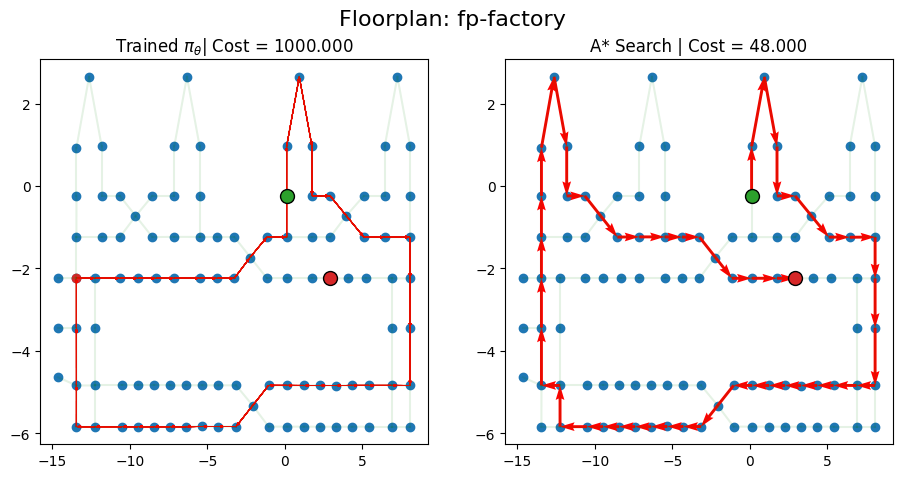

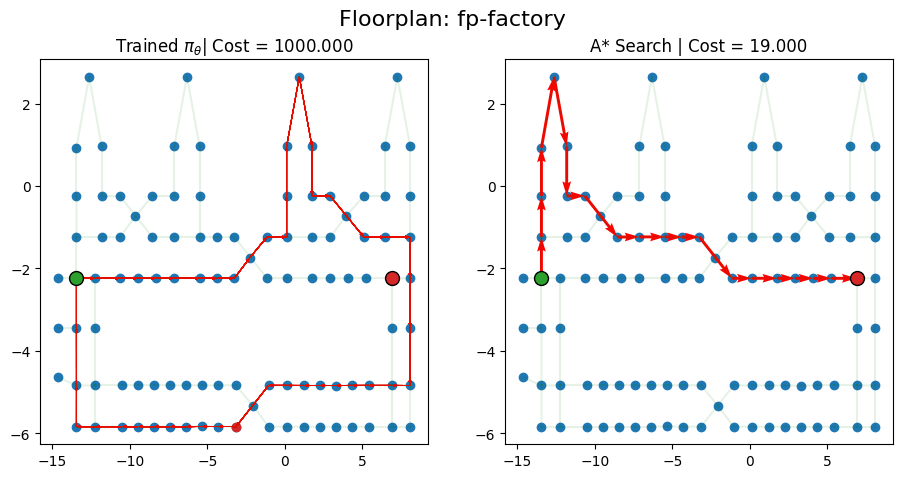

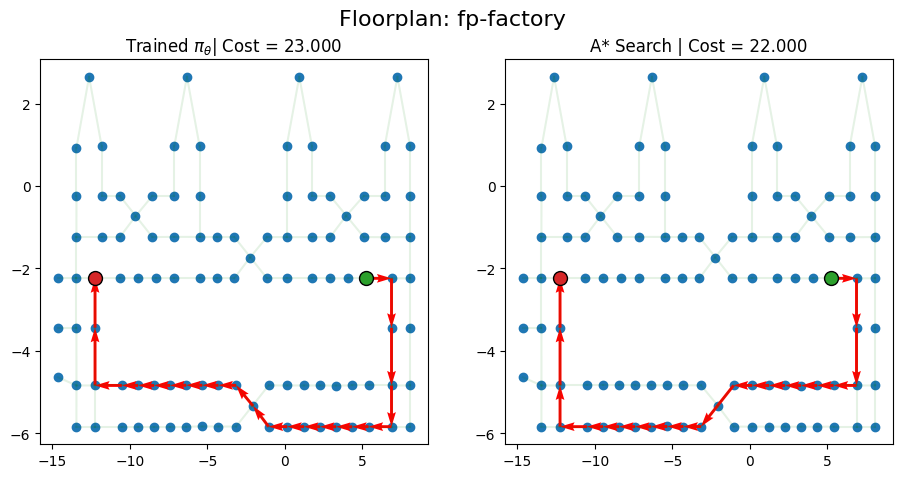

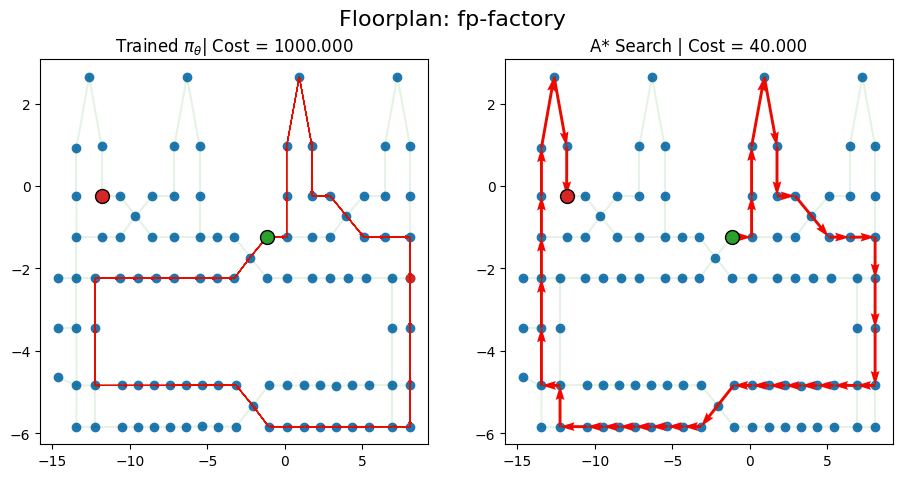

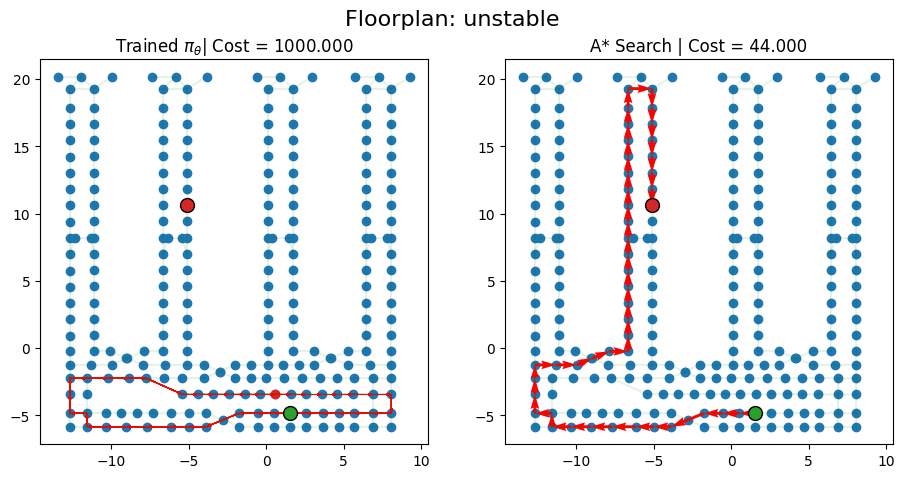

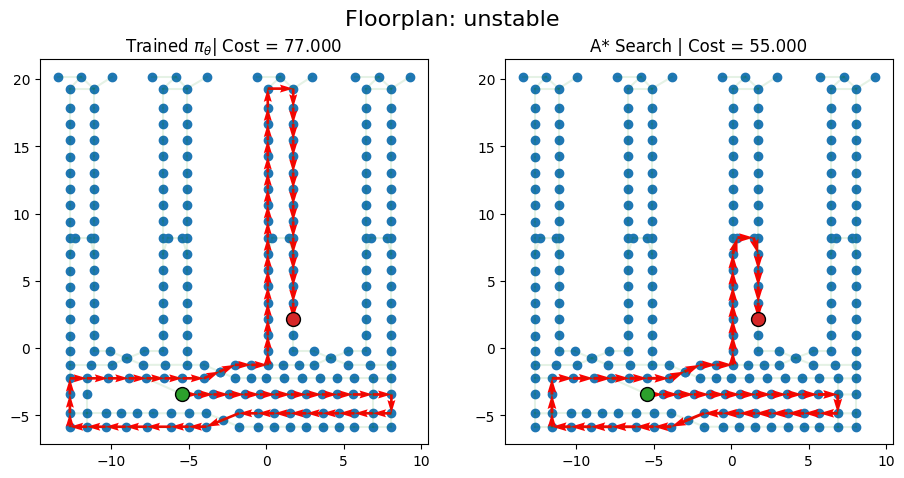

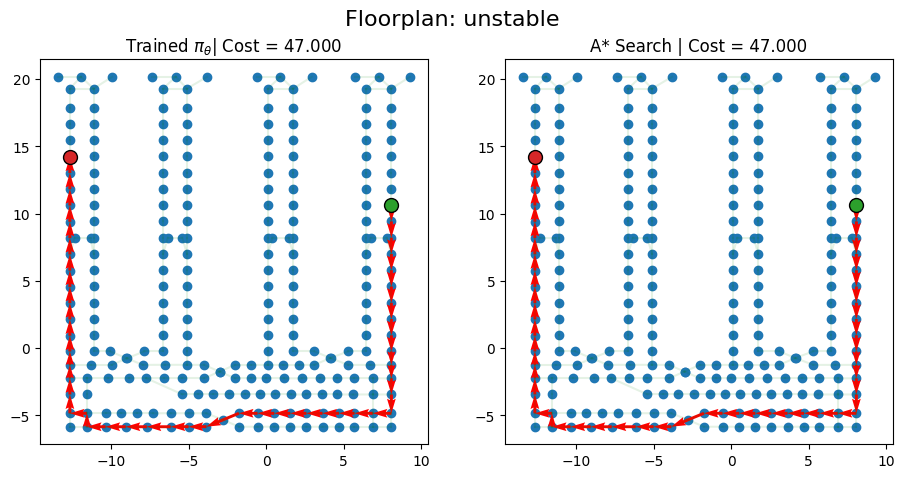

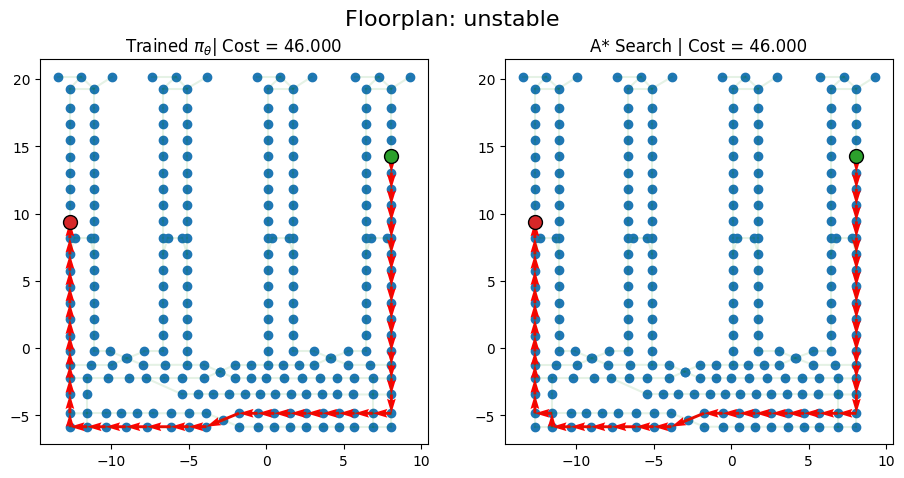

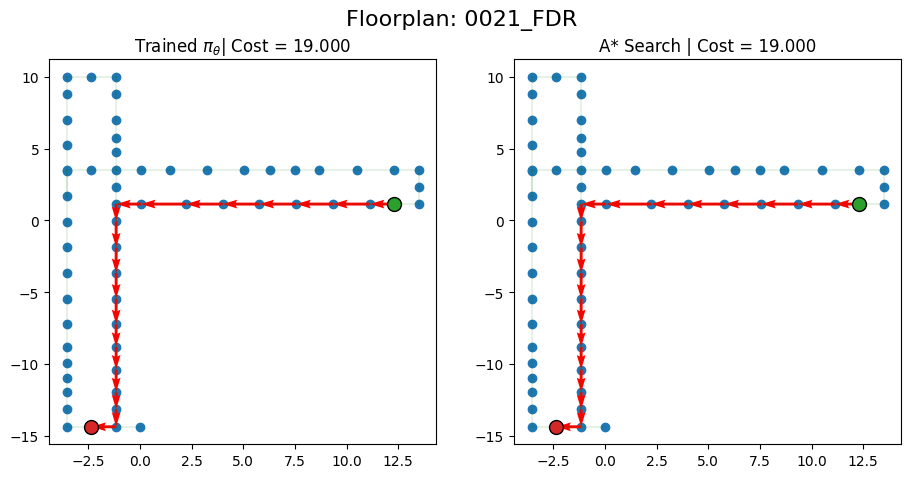

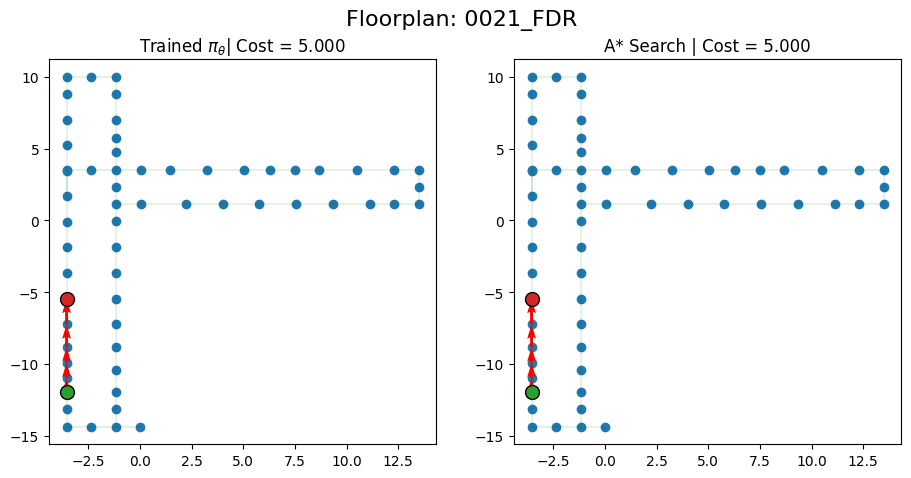

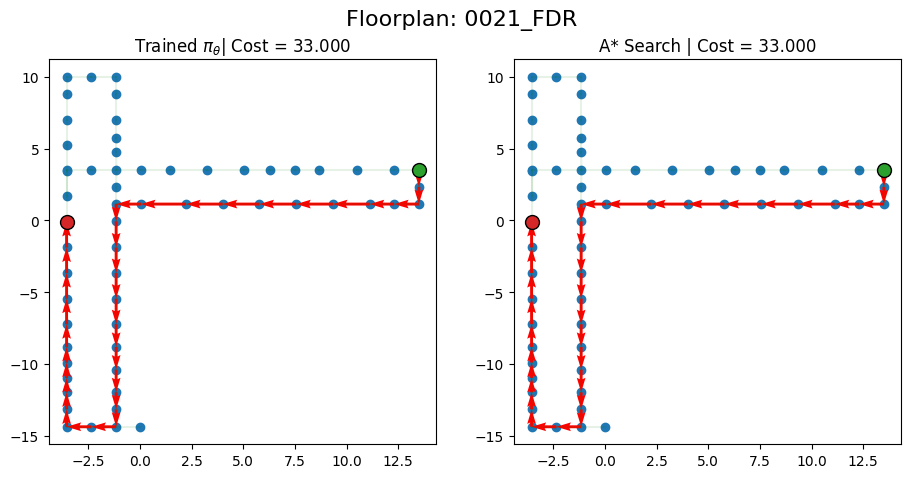

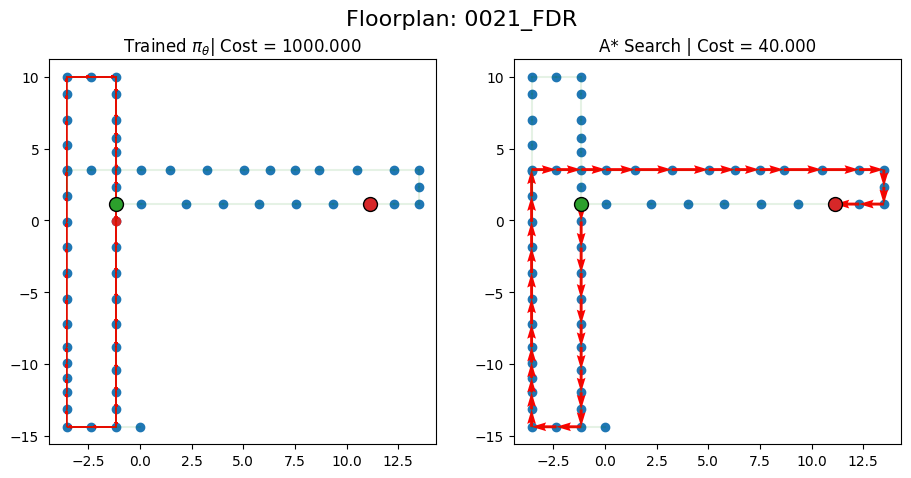

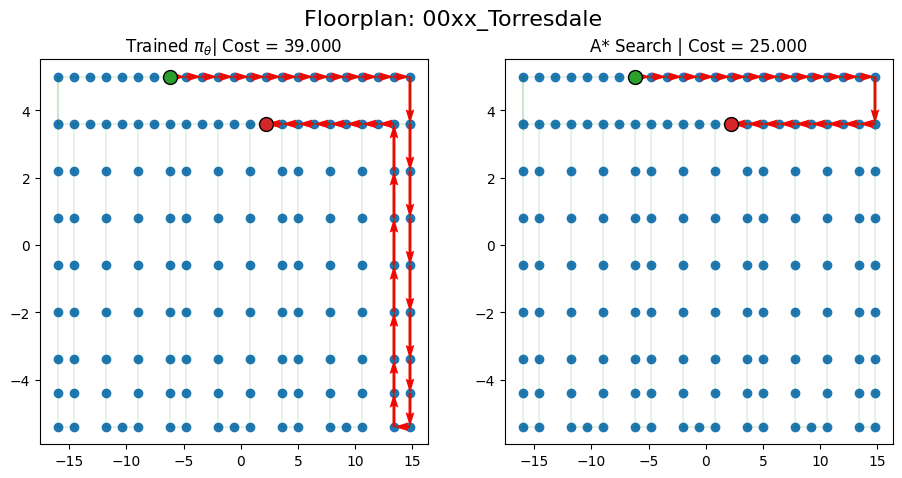

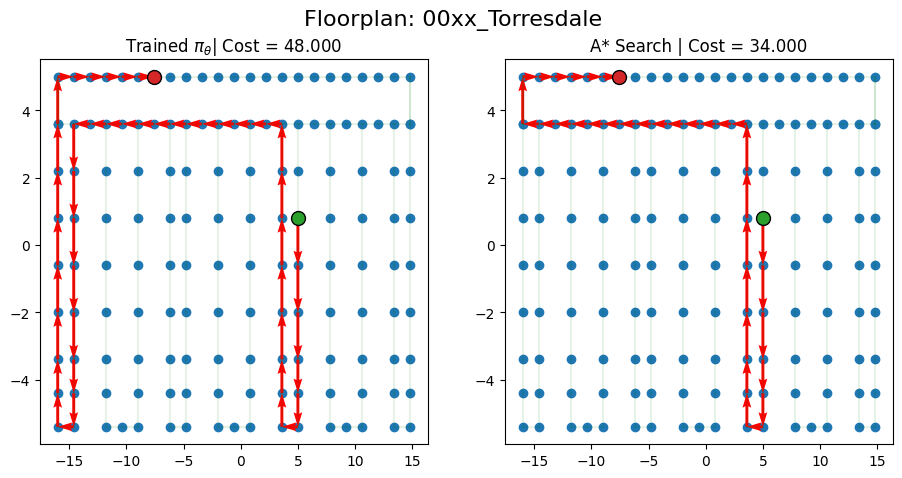

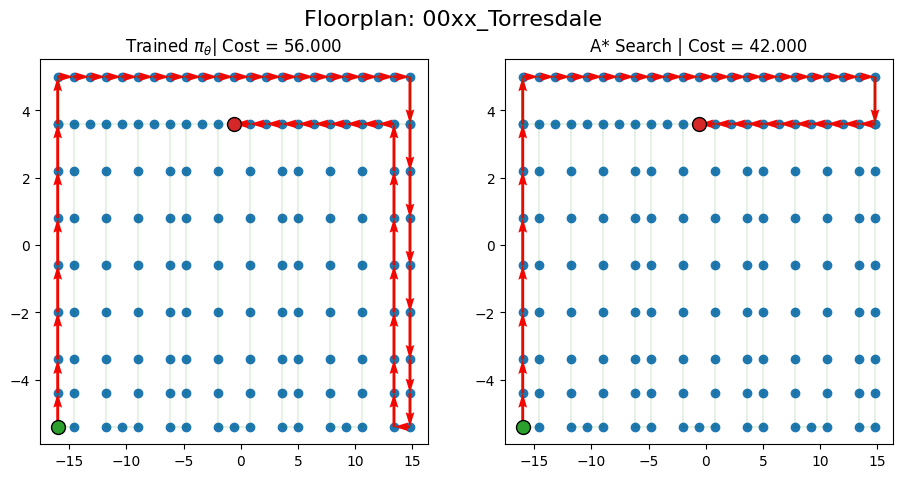

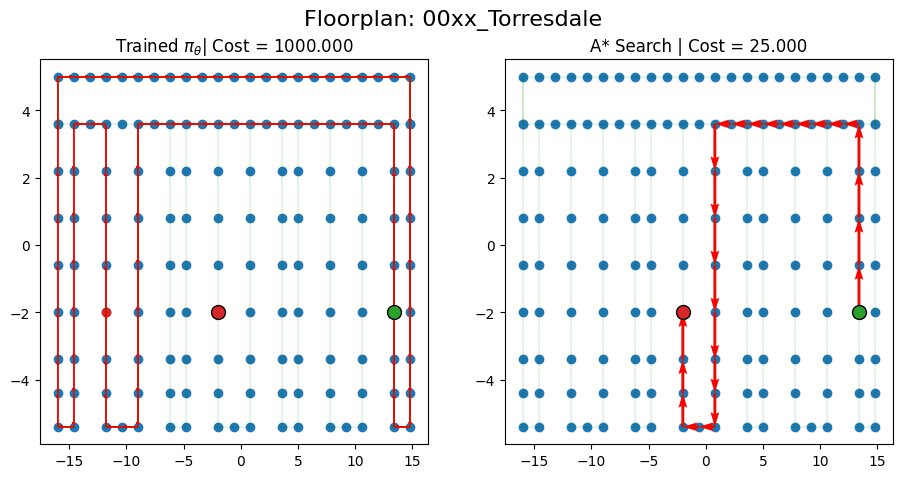

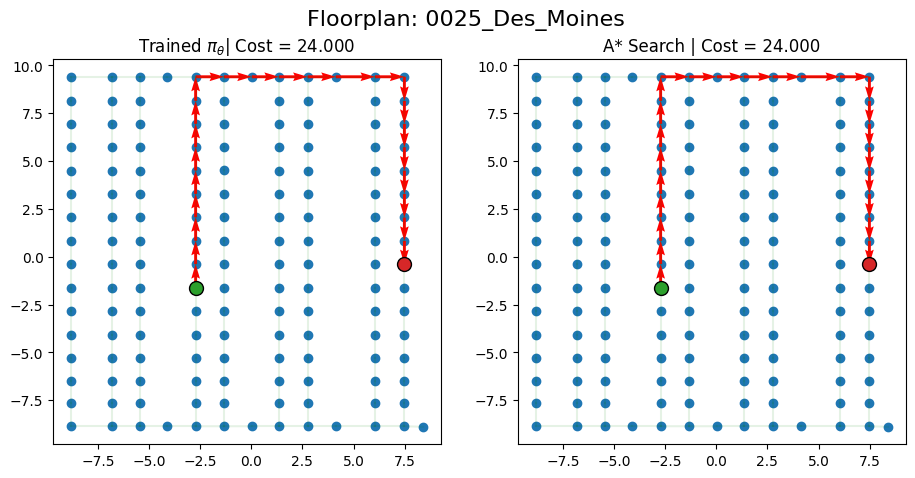

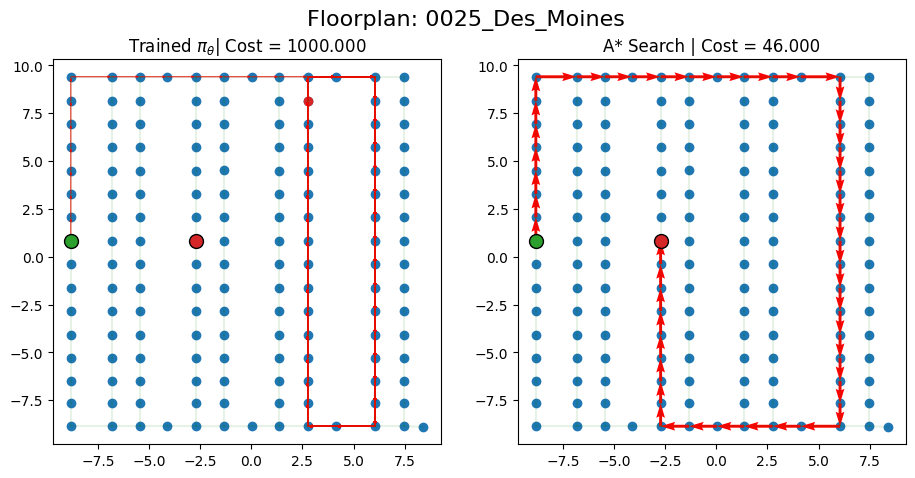

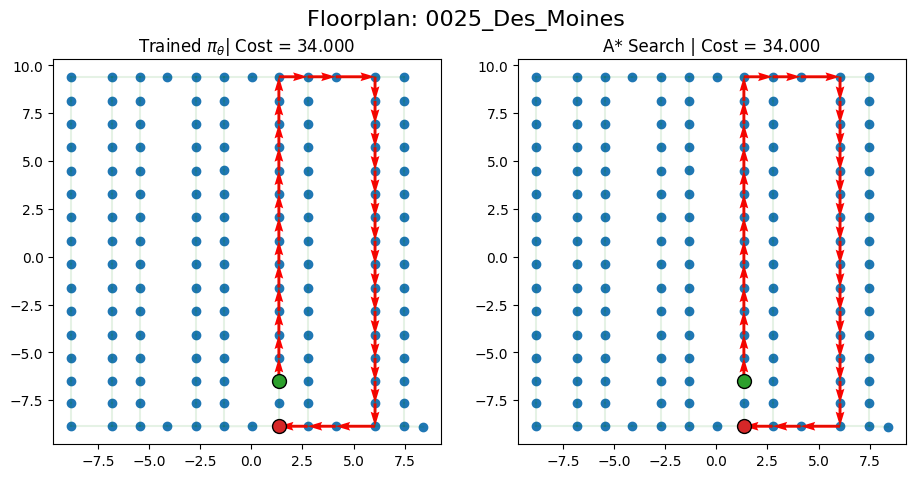

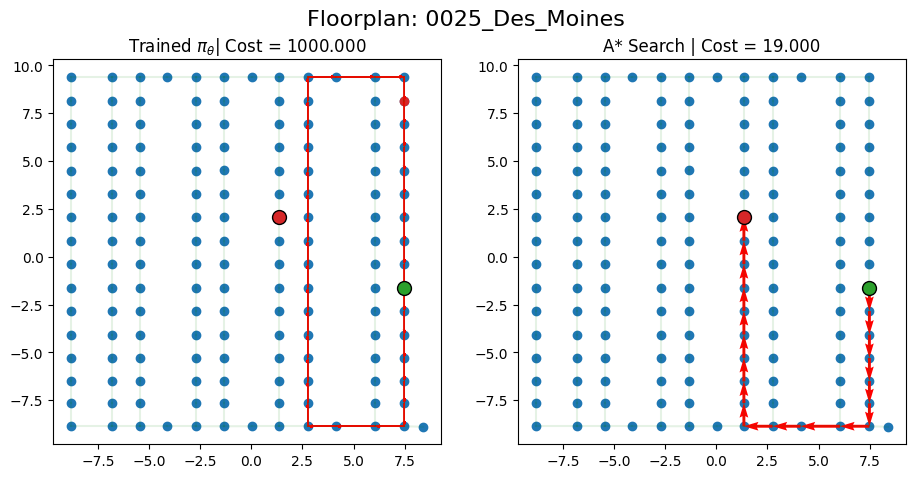

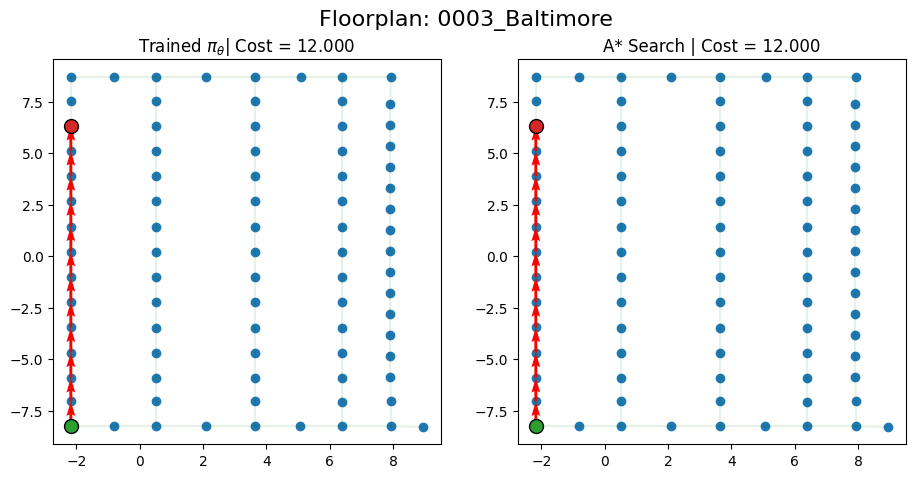

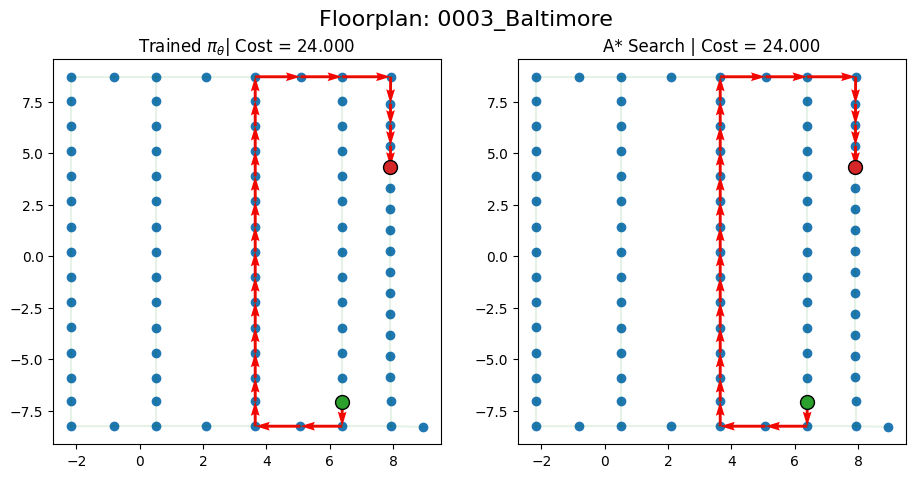

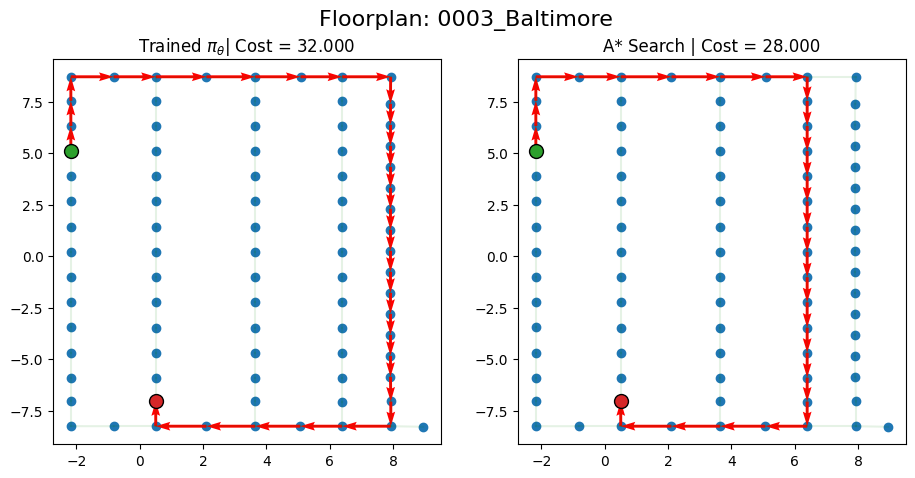

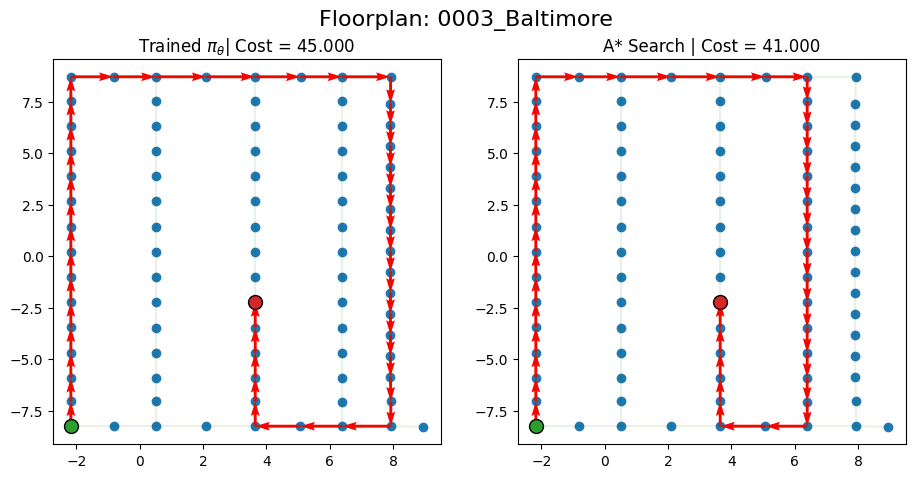

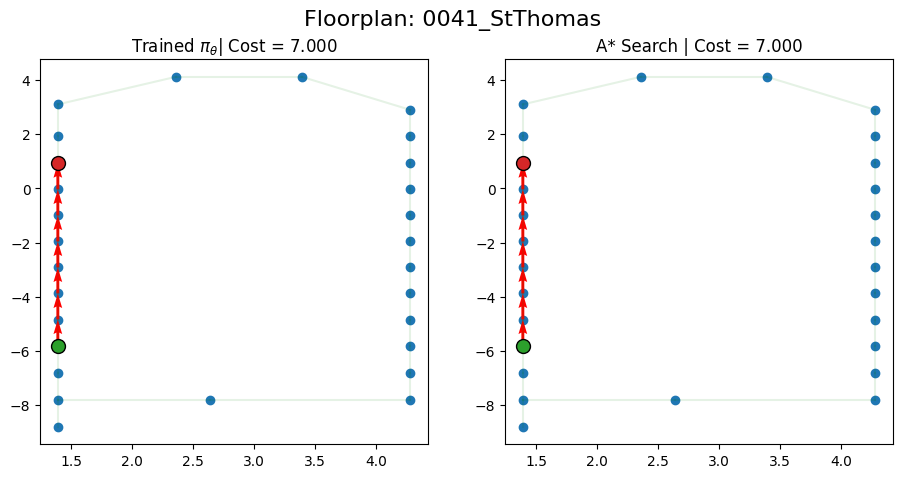

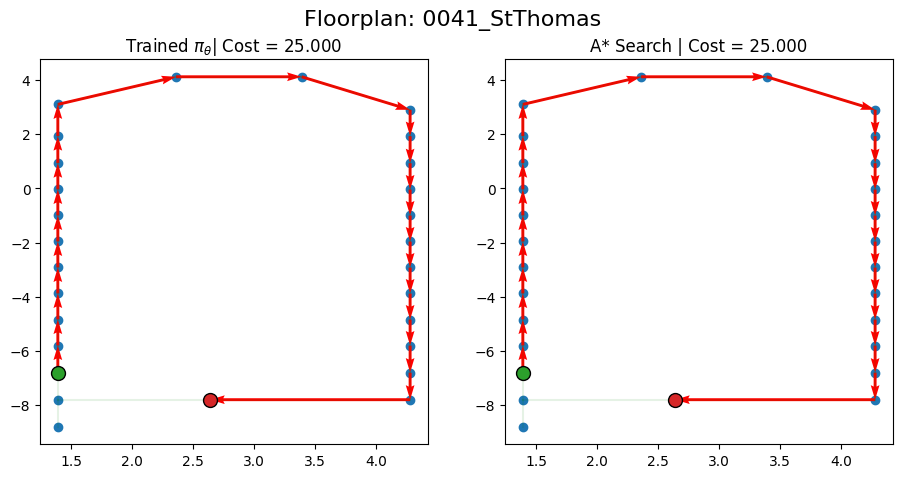

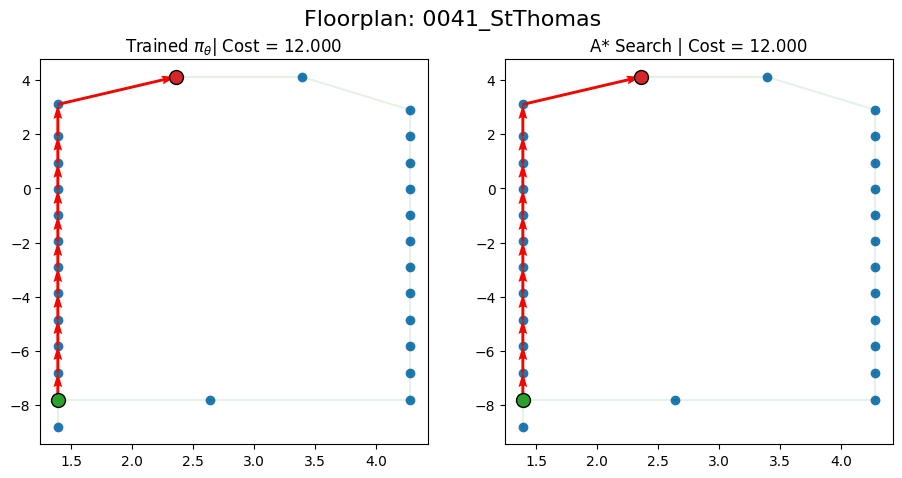

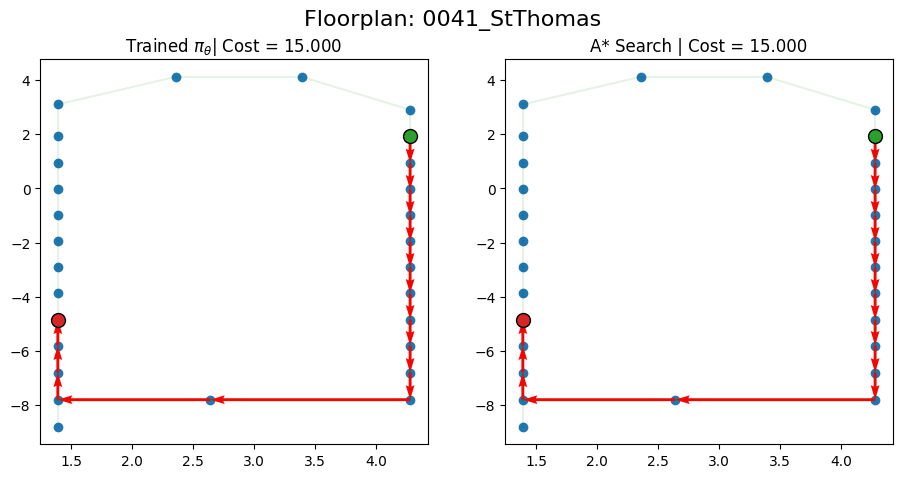

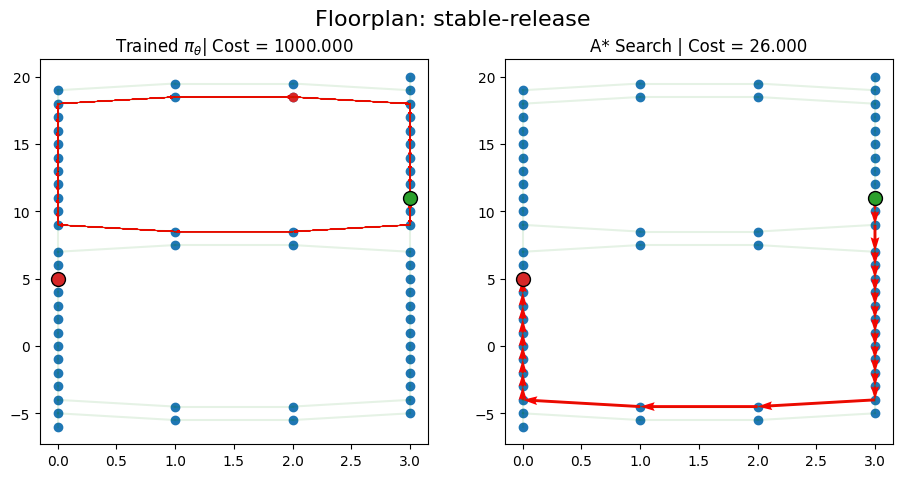

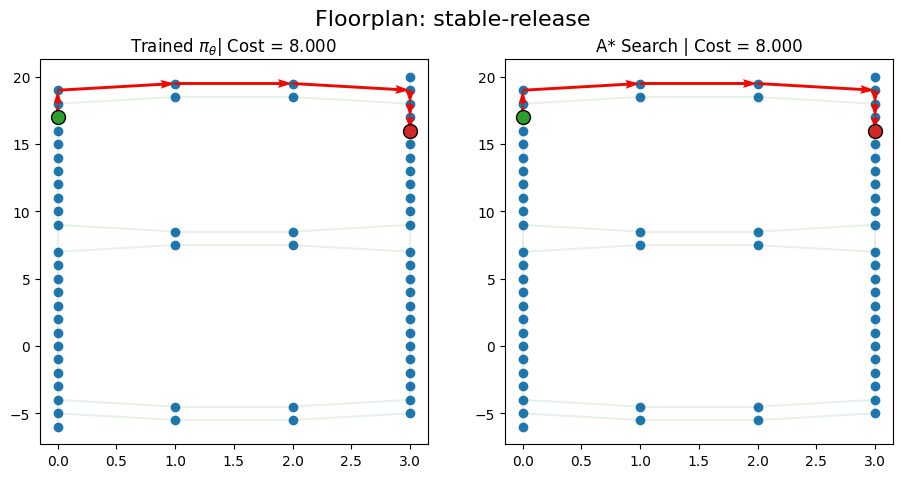

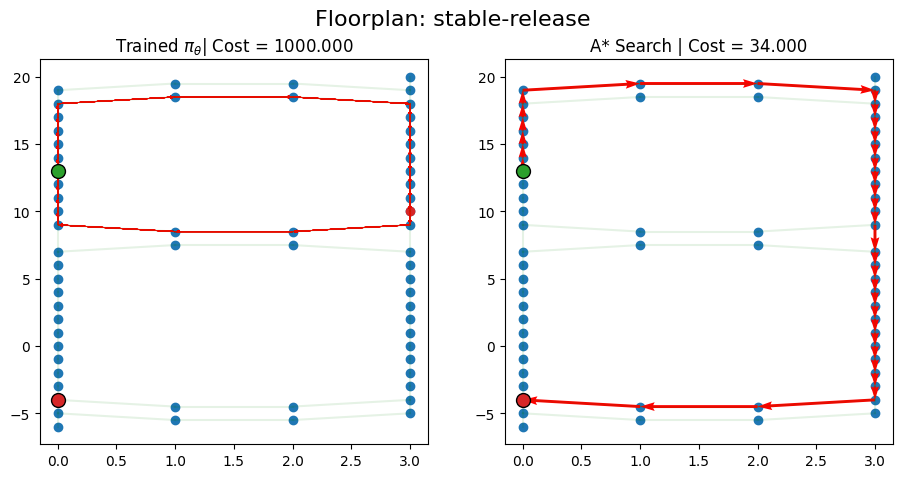

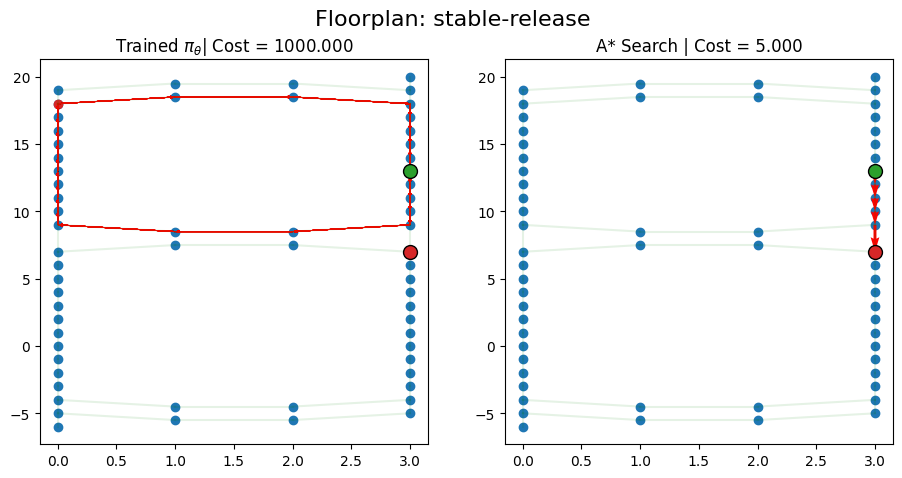

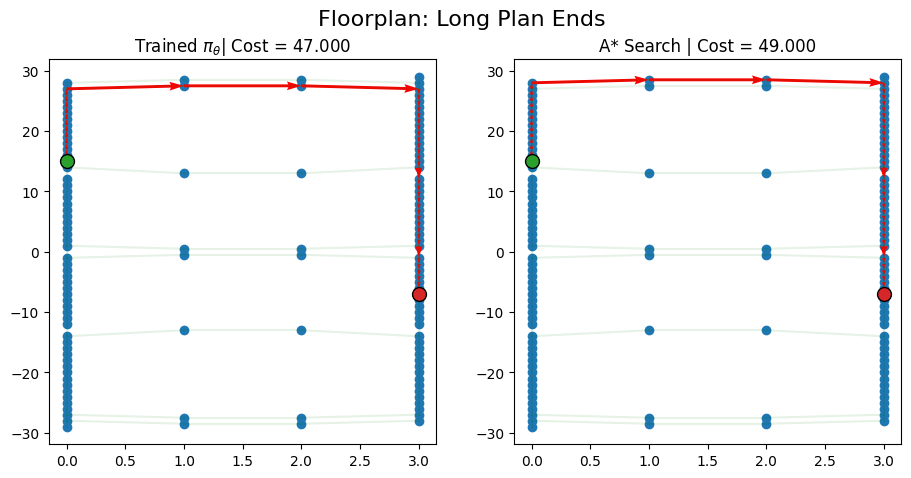

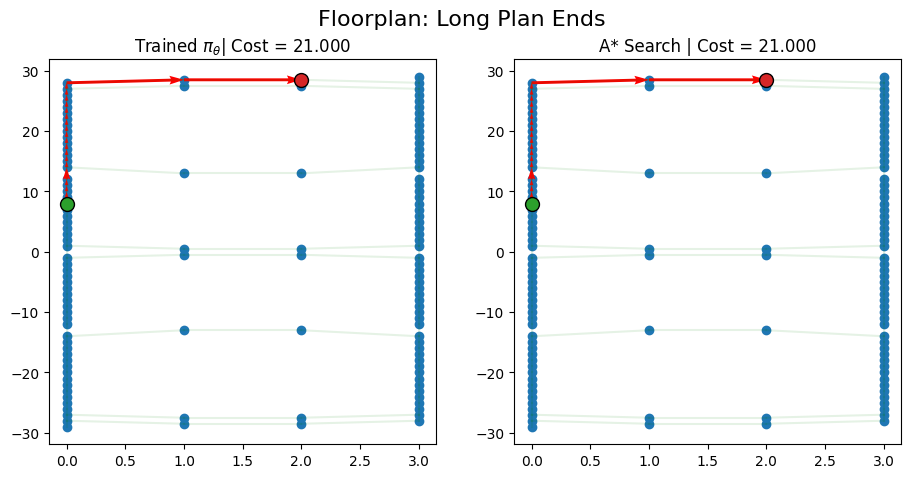

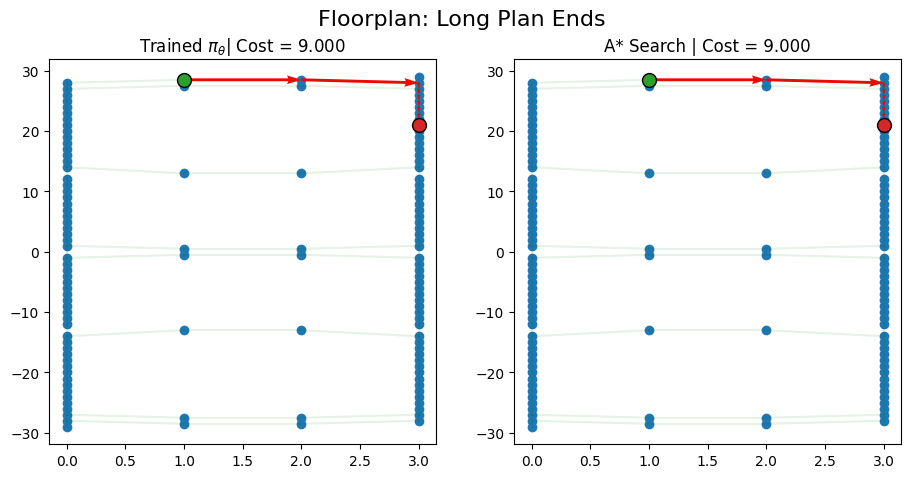

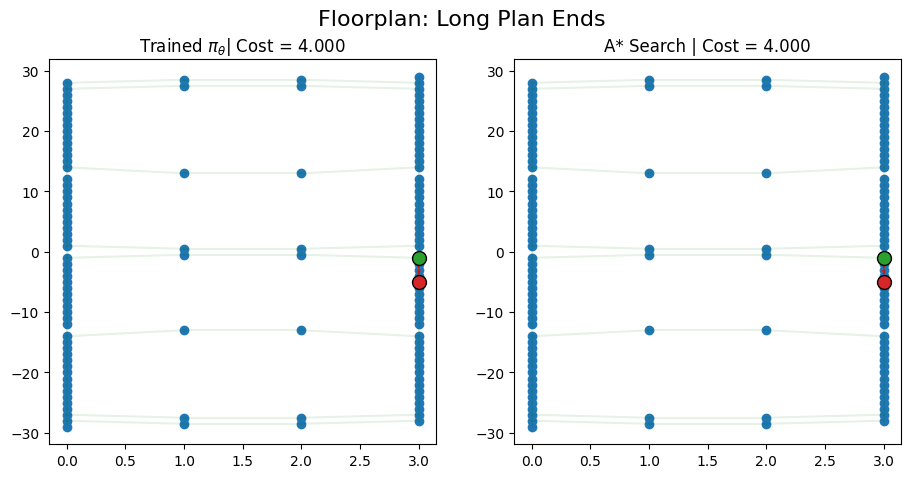

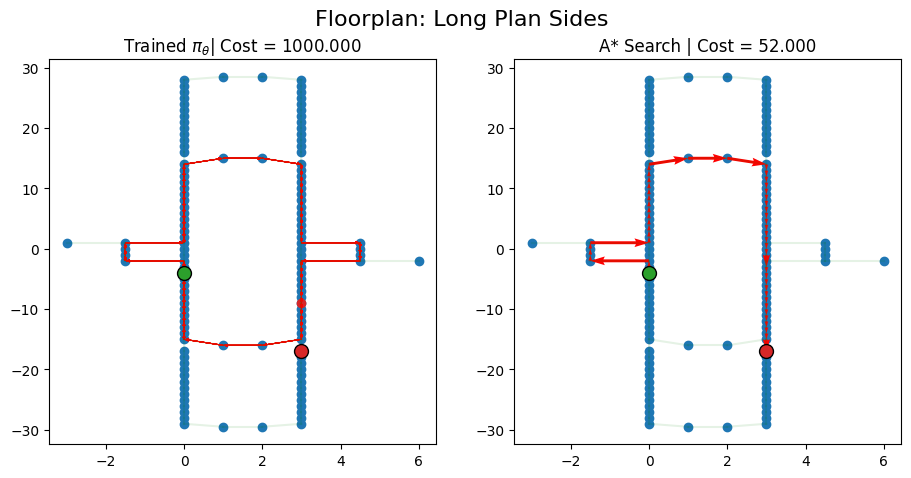

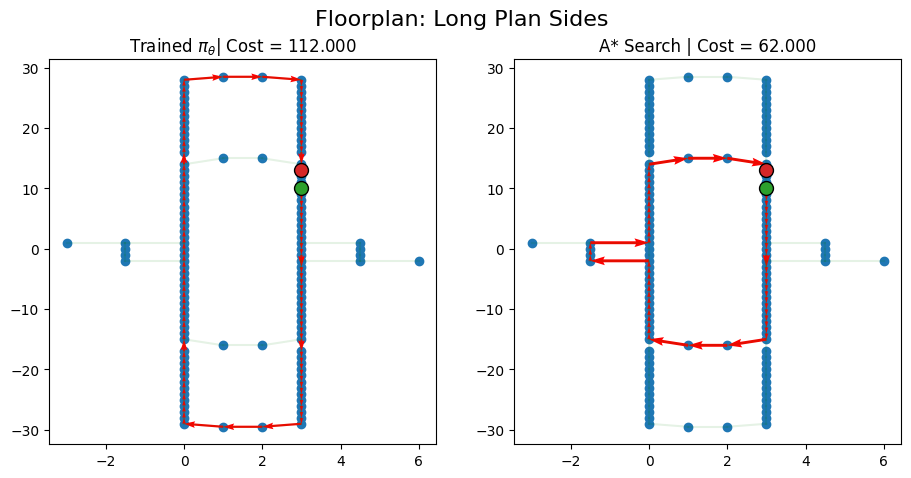

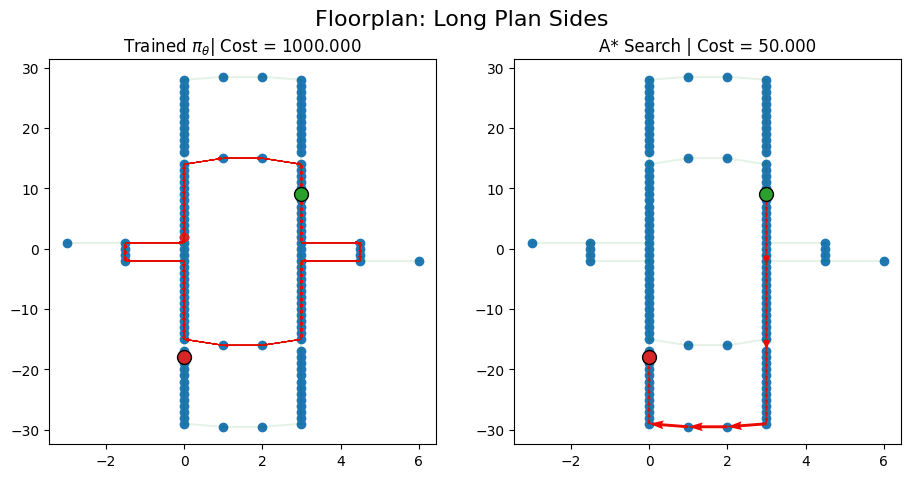

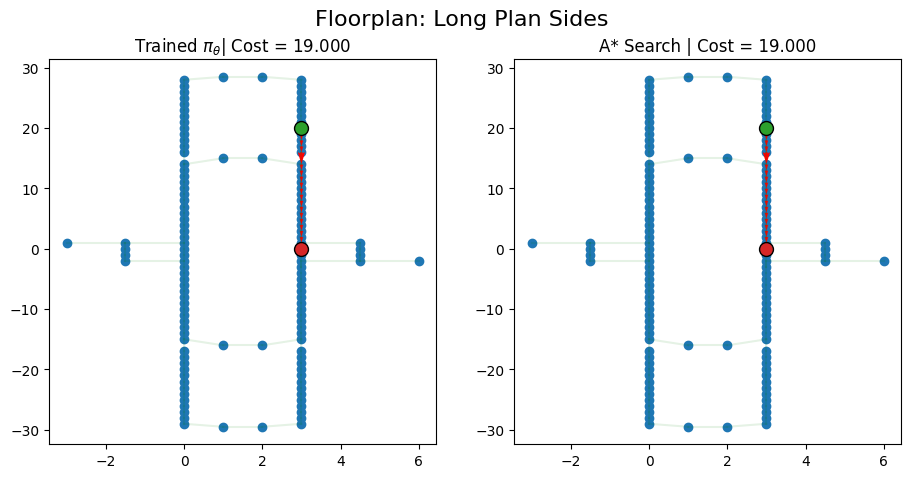

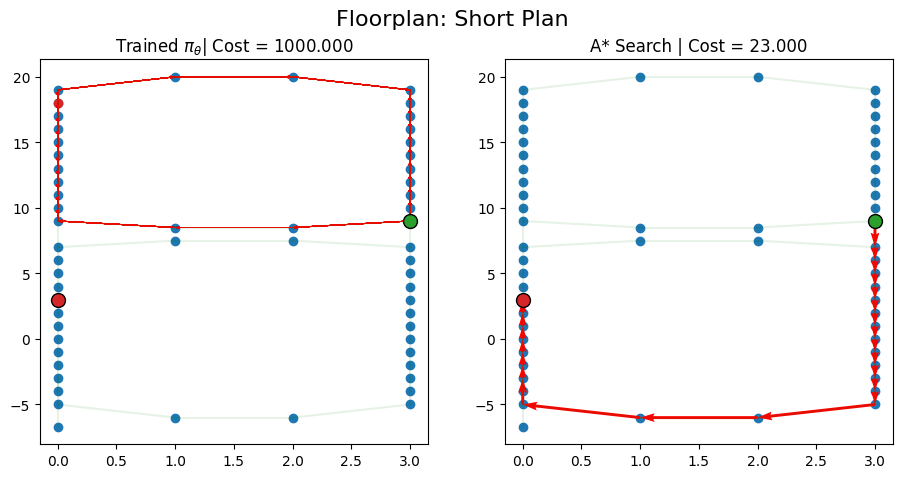

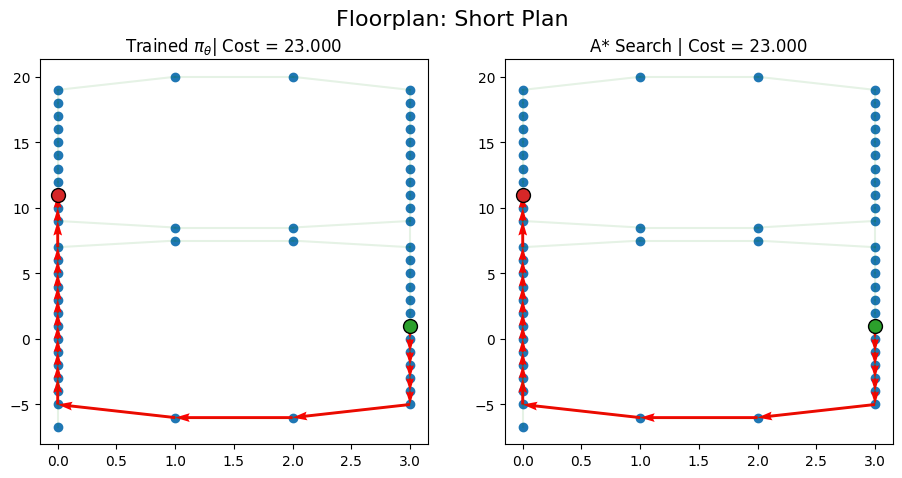

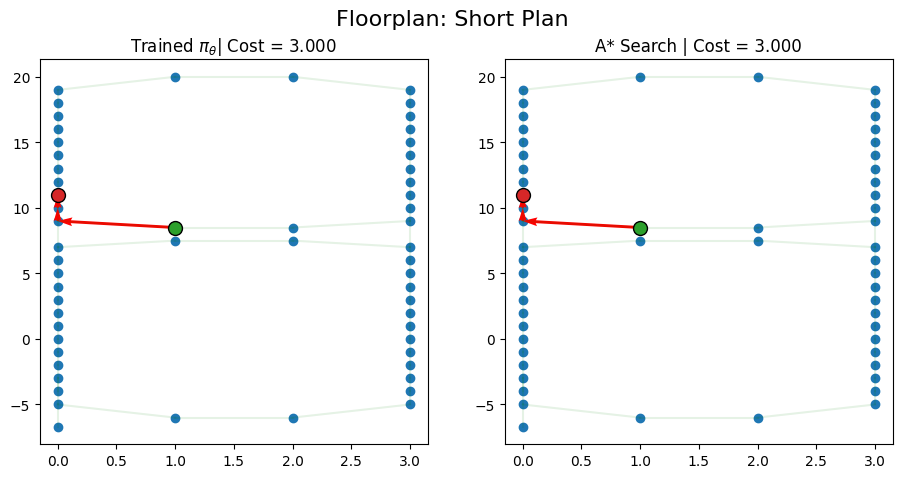

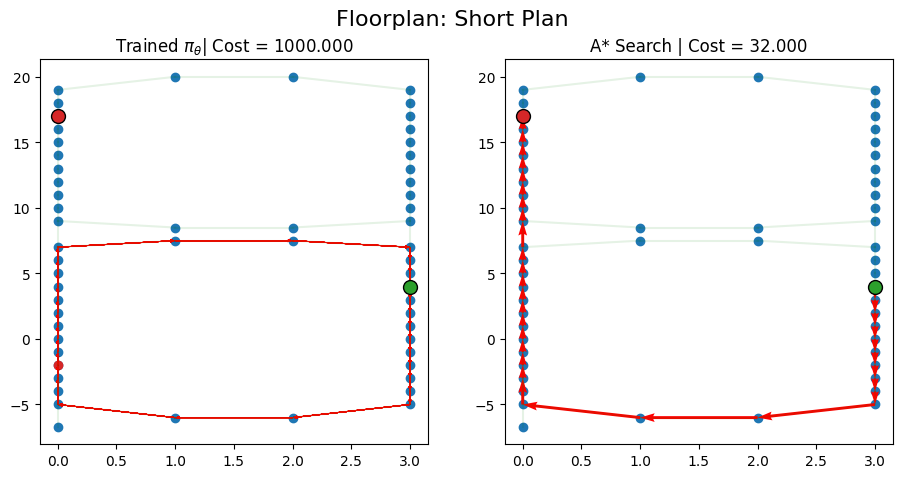

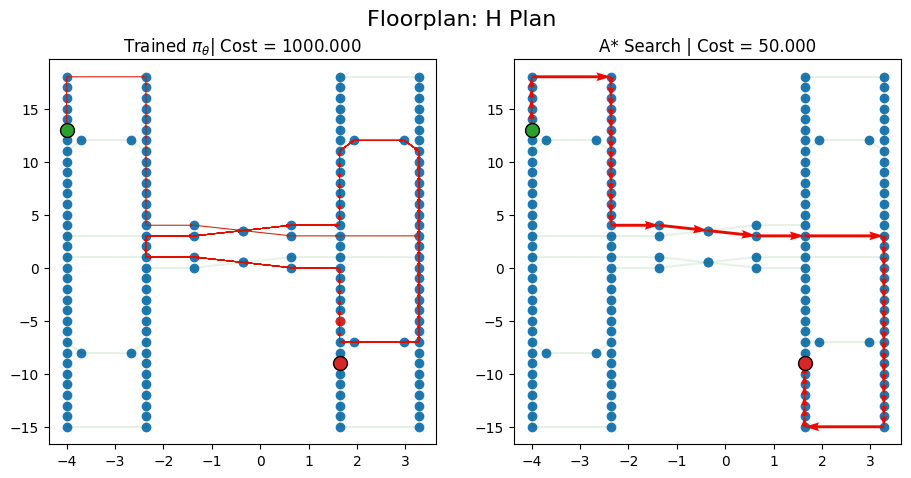

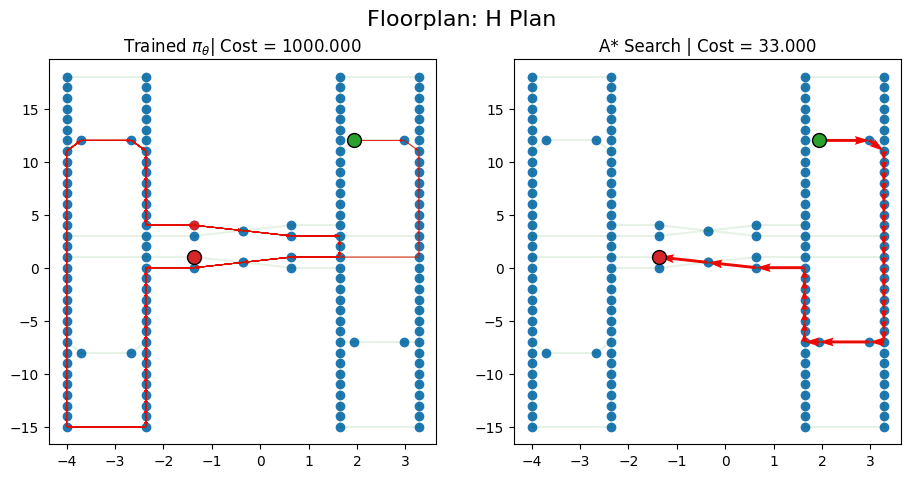

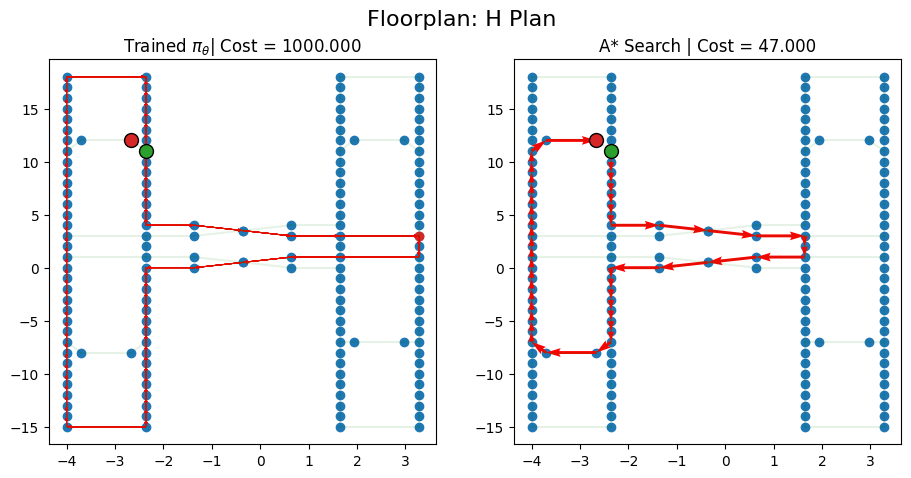

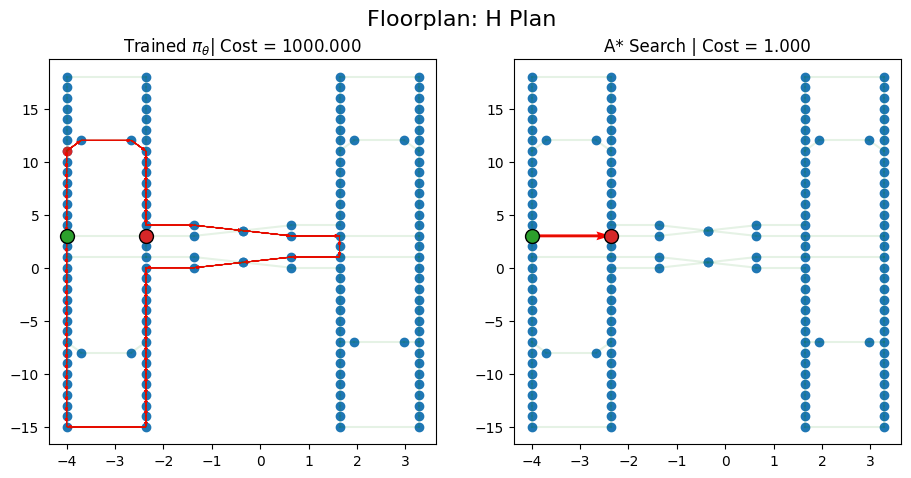

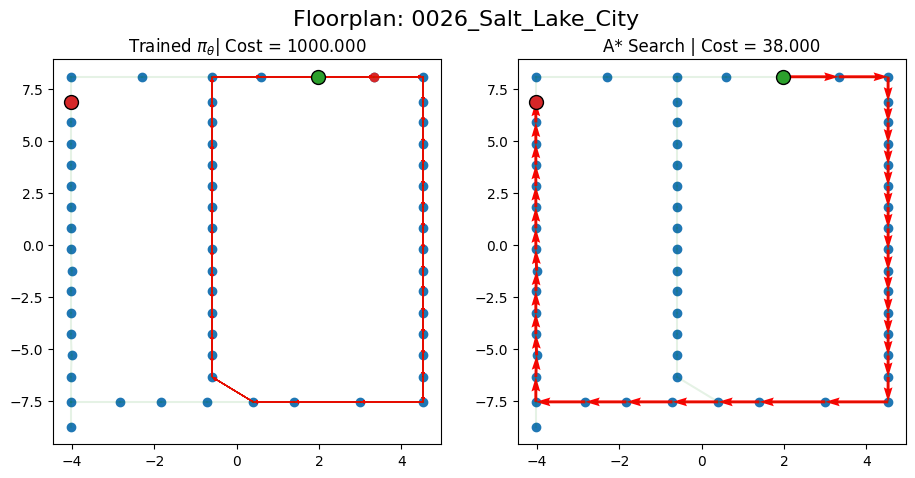

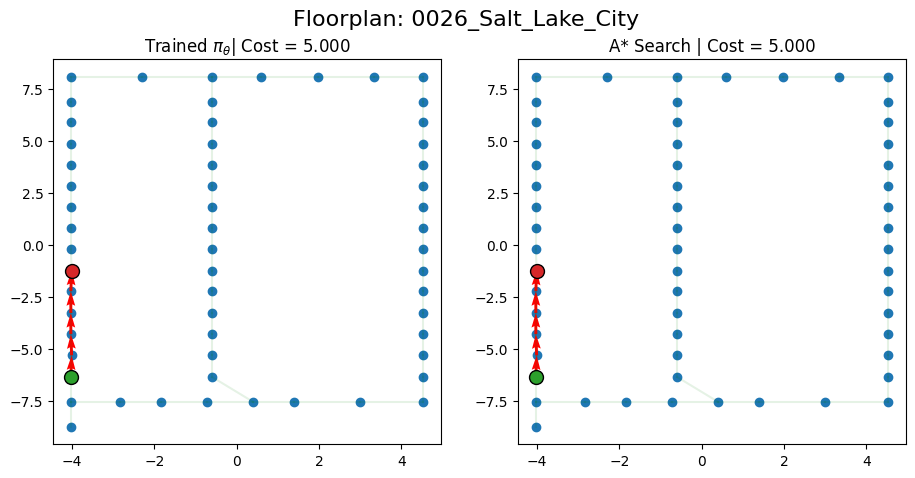

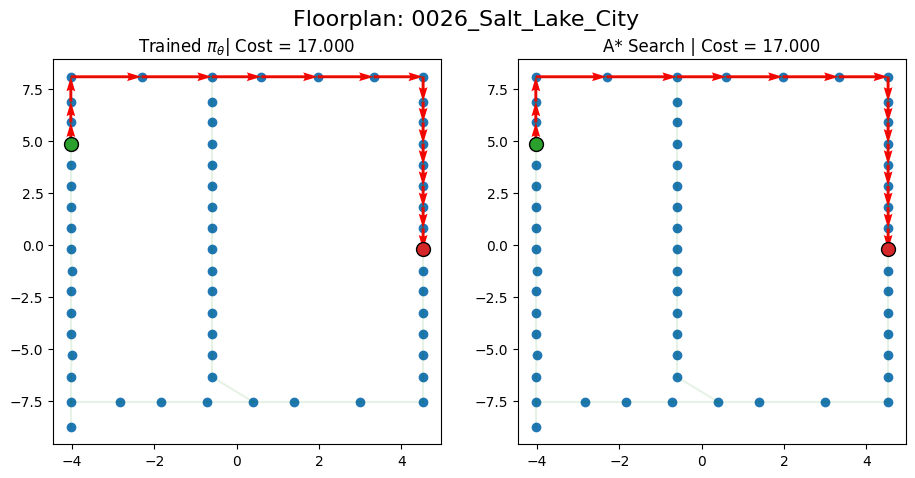

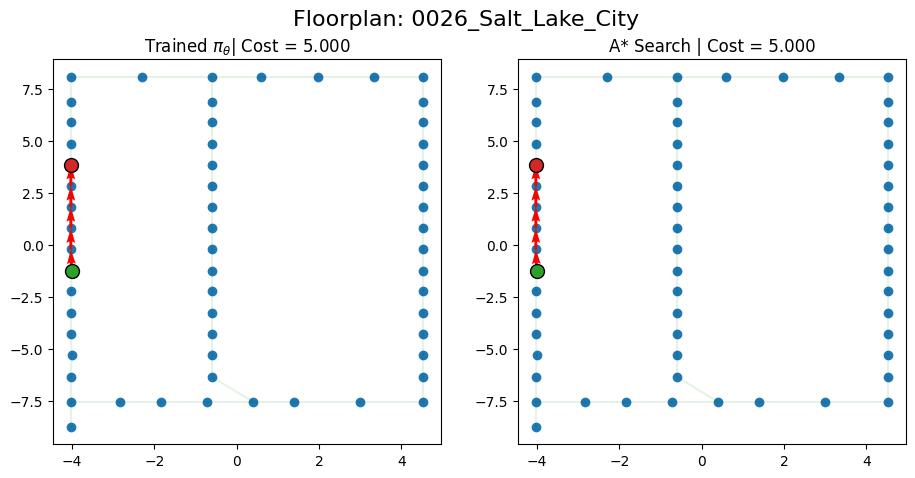

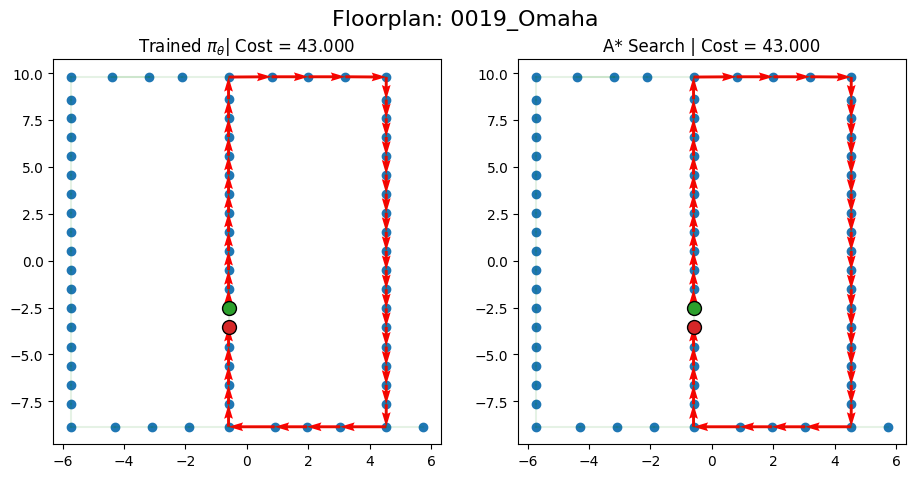

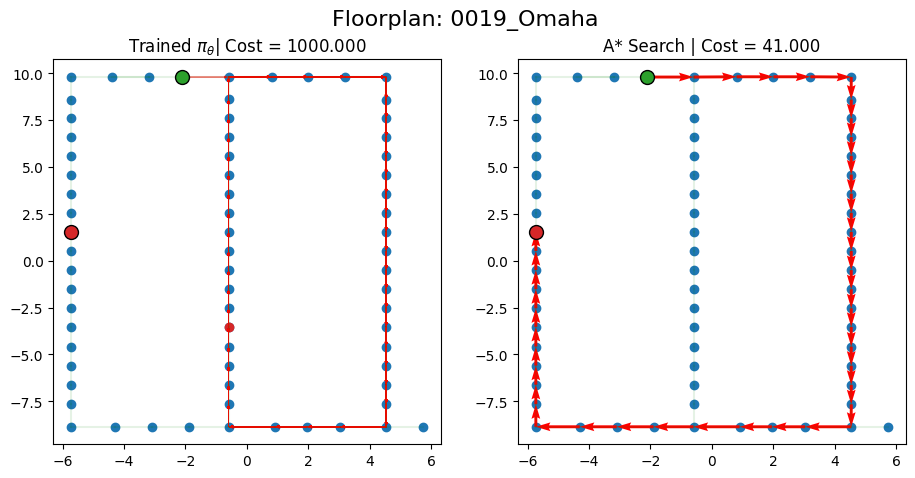

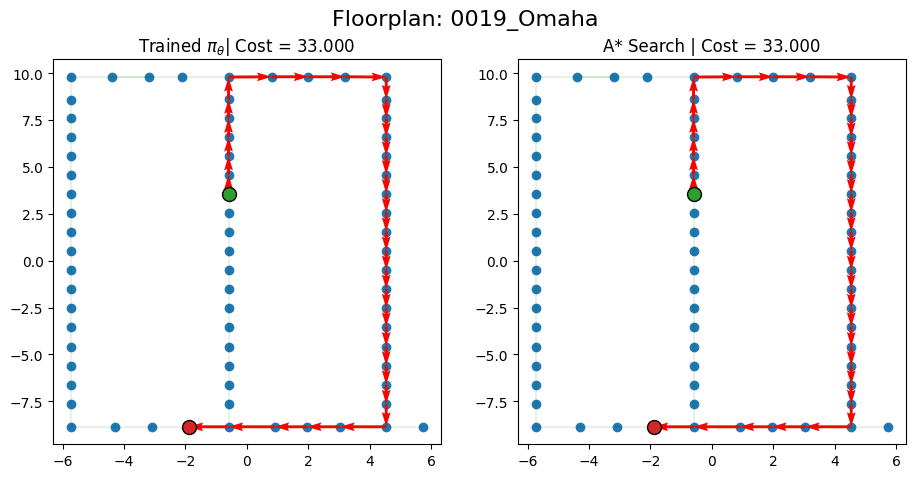

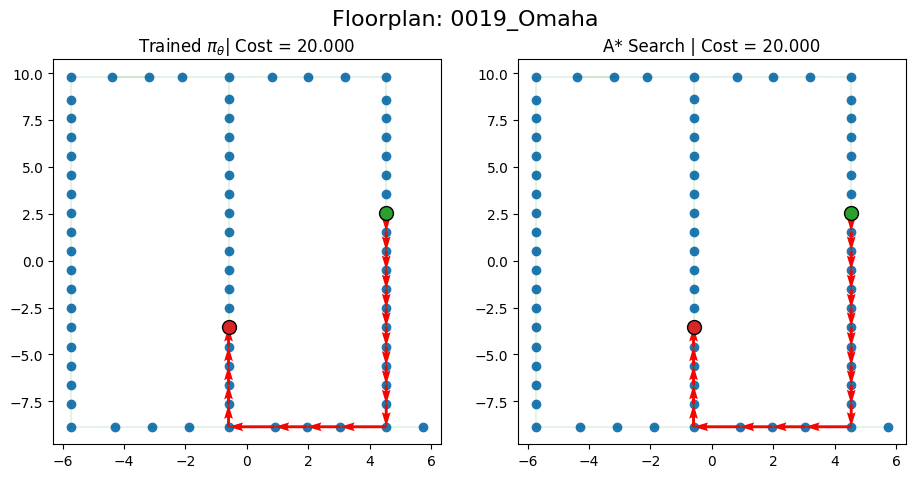

In [14]:
from FPenv import FPEnv
from astar import AStarSearch
from Floorplan_Codes.utils import get_paths
import torch

# Setup a device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

floorplans = get_paths("floorplan.json", "Floorplans/USPS", recursive=True, depth=1)
ids = []
for floorplan in floorplans:
    try:
        infer_env = FPEnv(fp_path=floorplan)
        td_init = infer_env.reset(batch_size=[4]).to(device)


        # Function to check for NaNs in a tensor dictionary
        nan_found = False
        for key, tensor in td_init.items():
            if torch.isnan(tensor).any():
              nan_found = True
              print(f"NaN values found in tensor '{key}'")
        if not nan_found:
            print("No NaN values found in the tensor dictionary.")

        policy = model.policy.to(device)

        out = policy(td_init.clone(), infer_env, phase="test", decode_type="greedy", return_actions=True)
        actions_trained = out['actions'].cpu().detach()

        # run A* search on the environment
        astar = AStarSearch(td_init.clone())
        astar_out = astar.search()
        actions_astar = astar_out["actions"].cpu().detach()

        # Plotting
        import matplotlib.pyplot as plt
        for i, td in enumerate(td_init):
            fig, axs = plt.subplots(1,2, figsize=(11,5))

            parts = floorplan.split('/')
            site = parts[-2]
            fig.suptitle("Floorplan: " + site, fontsize=16)

            infer_env.render(td, actions_trained[i], ax=axs[0])
            axs[0].set_title(r"Trained $\pi_\theta$" + f"| Cost = {-out['reward'][i].item():.3f}")

            infer_env.render(td, actions_astar[i], ax=axs[1])
            axs[1].set_title("A* Search | Cost = {:.3f}".format(-astar_out["reward"][i].item()))
    except Exception as e:
        print(e)
        continue


# Save the Trained Model

In [15]:
# Save the entire model
torch.save(model, 'Models/TrainOnFloorplansResults5.pth')